In [63]:
import pypsa
from pypsa.optimization.compat import define_constraints, get_var, join_exprs, linexpr
import matplotlib.pyplot as plt
import xarray as xr
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns
import pandas as pd 
import geopandas as gpd
import numpy as np
import cartopy.crs as ccrs
from regiondefinitions import regions_dic, links_dic
from data_import import syntheticdemand_gis, historic_demand, vre_gen_potential_atlite, region_area
from interconnectors import calculate_flows, efficiency_link, calculate_distance
from pyproj import Geod
import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning, message="The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.")
#warnings.filterwarnings("ignore", category=UserWArning, message="warnings.filterwarnings("ignore", category=FutureWarning, message="

# Setup of global grid

### Interconnectors

In [2]:
# DISTIANCES BETWEEN NODES
for key, value in links_dic.items():
    value["length"] = calculate_distance(value["bus0"][1], value["bus1"][1])

# EFFICIENCY OF INTERCONNECTORS
cable_capacity = 1200 # MW
cable_voltage = 1100 # kV
cable_resistivity = 0.01286 # ohms/km
converter_losses = 0.015 # [-]
for key, value in links_dic.items():
    value["efficiency"] = efficiency_link(cable_capacity, cable_voltage, cable_resistivity, value["length"]) - converter_losses

# SYNTHETIC -> excludes Europe
path = "/Volumes/fi246disk/synde/resources/gegis/output"
load_profile_dic = {}
for key, value in regions_dic.items():
    load_profile_dic[key] = {}
    if key != "north_america" and key != "europe" and key != "alaska":
        load_profile_dic[key]["load"] = syntheticdemand_gis(path, key, "ssp1-26" ) # MW

# HISTORIC -> includes Europe and USA
demand_mult_ssp1_26_oecd = 1.36
load_profile_dic["europe"]["load"] = historic_demand('/Users/frederickivens/Documents/MPhil_Energy_Technologies/Dissertation_Project/Codes/data/demand/total_hourly_demand_europe_node_9_utc.csv', 2017, demand_mult_ssp1_26_oecd)
historic_load_usa = historic_demand('/Users/frederickivens/Documents/MPhil_Energy_Technologies/Dissertation_Project/Codes/data/demand/total_hourly_demand_usa_2017_utc.csv', 2017, demand_mult_ssp1_26_oecd)
synthetic_load_north_america_usa = syntheticdemand_gis(path, "north_america_usa", "ssp1-26")
load_profile_dic["north_america"]["load"] = synthetic_load_north_america_usa

# RENEWABLE PROFILES
res_potential_dic = {}
for key, value in regions_dic.items():
    #if key != "oceania": #and key != "south_asia" and key != "middle_east" and key != "europe" and key != "north_africa":
    res_potential_dic[key] = {}
    res_potential_dic[key]["wind"] = vre_gen_potential_atlite(key, "wind", 2023, density=10, land_available=1)
    res_potential_dic[key]["pv"] = vre_gen_potential_atlite(key, "pv", 2023, density=45, land_available=1) # MW




### PyPSA --> Create the grid (actual grid)

In [3]:
# Initialise the network
n = pypsa.Network() 
snapshots = pd.date_range(start="2050-01-01 00:00:00", end="2050-12-31 23:00:00", freq="h")
n.set_snapshots(snapshots)

# Loop over the dictionary to add the buses
for key, value in regions_dic.items():
    n.add(class_name = "Bus", name = key, carrier = "DC", x = value["coordinates"][0] , y = value["coordinates"][1]) 
    
# Loop over the dictionary to add the links
for key, value in links_dic.items():
    n.add(class_name="Link", name=f'{value["name"]}_0', bus0=value["bus0"][1], bus1=value["bus1"][1], efficiency=value["efficiency"] , marginal_cost=0, p_nom_max= np.inf, p_nom_extendable=True)
    n.add(class_name="Link", name=f'{value["name"]}_1', bus0=value["bus1"][1], bus1=value["bus0"][1], efficiency=value["efficiency"] , marginal_cost=0, p_nom_max= np.inf, p_nom_extendable=True)

# Loop over the dictionary to add the renewable profiles --> these are the renewable potential generated with Atlite
for key, value in res_potential_dic.items():
    n.add(class_name="Generator", name=f'wind_{key}', type="Wind", bus=key, p_nom_extendable = True, p_nom_max=1.0, p_max_pu=value["wind"][snapshots],p_min_pu=value["wind"][snapshots],capital_cost = 0, marginal_cost = 1)
    n.add(class_name="Generator", name=f'pv_{key}', type="PV", bus=key, p_nom_extendable = True, p_nom_max=1.0, p_max_pu=value["pv"][snapshots],p_min_pu=value["pv"][snapshots], capital_cost =0, marginal_cost = 1)
    n.add(class_name="Generator", name=f'curtailment_{key}', type="Curtailment", bus=key, p_nom_extendable = True, marginal_cost = 0, sign=-1)

# Loop over the dictionary to add the demand profiles --> these are the demand profiles for each region
for key, value in load_profile_dic.items():
    n.add(class_name="Load", name=f"load_{key}", bus=key, p_set=value["load"][snapshots])

m = n.optimize.create_model();

n.optimize(solver_name='gurobi')

    

INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2025-06-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-06-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00,  5.63it/s]
INFO:linopy.io: Writing time: 4.81s


Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-m0yg_ded.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/ds/cj7372k1487ccc2t6pwv92m80000gn/T/linopy-problem-m0yg_ded.lp


Reading time = 2.16 seconds


INFO:gurobipy:Reading time = 2.16 seconds


obj: 1463023 rows, 674597 columns, 3192367 nonzeros


INFO:gurobipy:obj: 1463023 rows, 674597 columns, 3192367 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E214)


INFO:gurobipy:


CPU model: Apple M2


INFO:gurobipy:CPU model: Apple M2


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1463023 rows, 674597 columns and 3192367 nonzeros


INFO:gurobipy:Optimize a model with 1463023 rows, 674597 columns and 3192367 nonzeros


Model fingerprint: 0x6b8ef741


INFO:gurobipy:Model fingerprint: 0x6b8ef741


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [5e-04, 3e+09]


INFO:gurobipy:  Matrix range     [5e-04, 3e+09]


  Objective range  [1e+00, 1e+00]


INFO:gurobipy:  Objective range  [1e+00, 1e+00]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e+00, 3e+06]


INFO:gurobipy:  RHS range        [1e+00, 3e+06]


INFO:gurobipy:Warning: Model contains large matrix coefficient range


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1349143 rows and 341691 columns


INFO:gurobipy:Presolve removed 1349143 rows and 341691 columns


Presolve time: 1.00s


INFO:gurobipy:Presolve time: 1.00s


Presolved: 113880 rows, 332906 columns, 860292 nonzeros


INFO:gurobipy:Presolved: 113880 rows, 332906 columns, 860292 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 26


INFO:gurobipy: Dense cols : 26


 AA' NZ     : 3.610e+05


INFO:gurobipy: AA' NZ     : 3.610e+05


 Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


INFO:gurobipy: Factor NZ  : 3.033e+06 (roughly 200 MB of memory)


 Factor Ops : 8.318e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 8.318e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.70079704e+14 -4.24328052e+14  2.02e+03 3.77e+08  6.59e+12     1s


INFO:gurobipy:   0   3.70079704e+14 -4.24328052e+14  2.02e+03 3.77e+08  6.59e+12     1s


   1   4.26048753e+14 -5.84007185e+14  1.73e+03 5.53e+09  4.37e+12     1s


INFO:gurobipy:   1   4.26048753e+14 -5.84007185e+14  1.73e+03 5.53e+09  4.37e+12     1s


   2   4.15888240e+14 -1.31464437e+15  1.41e+03 4.47e+09  3.12e+12     1s


INFO:gurobipy:   2   4.15888240e+14 -1.31464437e+15  1.41e+03 4.47e+09  3.12e+12     1s


   3   3.86232673e+14 -2.63242479e+15  1.21e+03 1.82e+09  1.40e+12     2s


INFO:gurobipy:   3   3.86232673e+14 -2.63242479e+15  1.21e+03 1.82e+09  1.40e+12     2s


   4   2.56699365e+14 -3.45078261e+15  8.37e+02 1.06e+09  8.75e+11     2s


INFO:gurobipy:   4   2.56699365e+14 -3.45078261e+15  8.37e+02 1.06e+09  8.75e+11     2s


   5   1.95990515e+14 -3.96557677e+15  5.96e+02 4.97e+08  4.78e+11     2s


INFO:gurobipy:   5   1.95990515e+14 -3.96557677e+15  5.96e+02 4.97e+08  4.78e+11     2s


   6   1.68772799e+14 -4.71008627e+15  4.99e+02 3.93e+08  3.91e+11     2s


INFO:gurobipy:   6   1.68772799e+14 -4.71008627e+15  4.99e+02 3.93e+08  3.91e+11     2s


   7   9.56368250e+13 -5.78686269e+15  2.32e+02 1.78e+08  1.95e+11     2s


INFO:gurobipy:   7   9.56368250e+13 -5.78686269e+15  2.32e+02 1.78e+08  1.95e+11     2s


   8   3.36559137e+13 -6.21917453e+15  2.42e+01 4.18e+07  4.03e+10     2s


INFO:gurobipy:   8   3.36559137e+13 -6.21917453e+15  2.42e+01 4.18e+07  4.03e+10     2s


   9   2.56639964e+13 -1.50675082e+15  1.01e-02 2.06e+06  4.62e+09     2s


INFO:gurobipy:   9   2.56639964e+13 -1.50675082e+15  1.01e-02 2.06e+06  4.62e+09     2s


  10   2.56252824e+13 -7.30457545e+12  2.29e-11 4.42e+04  9.91e+07     2s


INFO:gurobipy:  10   2.56252824e+13 -7.30457545e+12  2.29e-11 4.42e+04  9.91e+07     2s


  11   2.13815164e+13 -3.95751044e+12  1.49e-11 3.26e+04  7.49e+07     2s


INFO:gurobipy:  11   2.13815164e+13 -3.95751044e+12  1.49e-11 3.26e+04  7.49e+07     2s


  12   1.35880115e+13 -3.53538674e+12  7.85e-12 3.11e+04  5.11e+07     2s


INFO:gurobipy:  12   1.35880115e+13 -3.53538674e+12  7.85e-12 3.11e+04  5.11e+07     2s


  13   1.26169475e+13 -1.90048701e+12  6.90e-12 2.41e+04  4.26e+07     2s


INFO:gurobipy:  13   1.26169475e+13 -1.90048701e+12  6.90e-12 2.41e+04  4.26e+07     2s


  14   1.22076738e+13 -1.05246692e+12  6.61e-12 1.97e+04  3.84e+07     2s


INFO:gurobipy:  14   1.22076738e+13 -1.05246692e+12  6.61e-12 1.97e+04  3.84e+07     2s


  15   9.14821631e+12 -9.08436866e+11  5.62e-12 1.02e+04  2.76e+07     2s


INFO:gurobipy:  15   9.14821631e+12 -9.08436866e+11  5.62e-12 1.02e+04  2.76e+07     2s


  16   6.44161848e+12 -5.83176775e+11  3.78e-12 5.21e+03  1.88e+07     3s


INFO:gurobipy:  16   6.44161848e+12 -5.83176775e+11  3.78e-12 5.21e+03  1.88e+07     3s


  17   4.13157977e+12 -2.90279569e+11  7.08e-12 1.83e+03  1.16e+07     3s


INFO:gurobipy:  17   4.13157977e+12 -2.90279569e+11  7.08e-12 1.83e+03  1.16e+07     3s


  18   2.85382731e+12 -1.76592314e+11  4.89e-12 1.25e+03  7.93e+06     3s


INFO:gurobipy:  18   2.85382731e+12 -1.76592314e+11  4.89e-12 1.25e+03  7.93e+06     3s


  19   2.29455028e+12 -1.45174790e+11  3.87e-12 9.15e+02  6.38e+06     3s


INFO:gurobipy:  19   2.29455028e+12 -1.45174790e+11  3.87e-12 9.15e+02  6.38e+06     3s


  20   8.94730921e+11 -3.71033953e+10  1.54e-12 2.97e+02  2.43e+06     3s


INFO:gurobipy:  20   8.94730921e+11 -3.71033953e+10  1.54e-12 2.97e+02  2.43e+06     3s


  21   3.85776580e+11  3.03922302e+10  7.03e-13 1.05e+02  9.23e+05     3s


INFO:gurobipy:  21   3.85776580e+11  3.03922302e+10  7.03e-13 1.05e+02  9.23e+05     3s


  22   1.91005083e+11  4.13791551e+10  1.17e-12 2.43e+01  3.88e+05     3s


INFO:gurobipy:  22   1.91005083e+11  4.13791551e+10  1.17e-12 2.43e+01  3.88e+05     3s


  23   9.44778659e+10  4.86592870e+10  6.61e-13 7.97e-01  1.19e+05     3s


INFO:gurobipy:  23   9.44778659e+10  4.86592870e+10  6.61e-13 7.97e-01  1.19e+05     3s


  24   8.46307536e+10  5.23839098e+10  5.40e-13 2.75e-01  8.37e+04     3s


INFO:gurobipy:  24   8.46307536e+10  5.23839098e+10  5.40e-13 2.75e-01  8.37e+04     3s


  25   8.26080277e+10  5.33114927e+10  5.54e-13 3.87e-01  7.60e+04     3s


INFO:gurobipy:  25   8.26080277e+10  5.33114927e+10  5.54e-13 3.87e-01  7.60e+04     3s


  26   8.17211220e+10  5.41814987e+10  5.12e-13 5.16e-01  7.14e+04     3s


INFO:gurobipy:  26   8.17211220e+10  5.41814987e+10  5.12e-13 5.16e-01  7.14e+04     3s


  27   7.89969861e+10  5.57998128e+10  1.88e-11 1.30e-01  6.02e+04     3s


INFO:gurobipy:  27   7.89969861e+10  5.57998128e+10  1.88e-11 1.30e-01  6.02e+04     3s


  28   7.40207368e+10  5.92914144e+10  1.06e-11 5.56e-02  3.82e+04     3s


INFO:gurobipy:  28   7.40207368e+10  5.92914144e+10  1.06e-11 5.56e-02  3.82e+04     3s


  29   7.29315798e+10  6.35044976e+10  8.62e-12 1.75e-02  2.45e+04     3s


INFO:gurobipy:  29   7.29315798e+10  6.35044976e+10  8.62e-12 1.75e-02  2.45e+04     3s


  30   7.21617729e+10  6.44843648e+10  2.61e-11 1.44e-02  1.99e+04     4s


INFO:gurobipy:  30   7.21617729e+10  6.44843648e+10  2.61e-11 1.44e-02  1.99e+04     4s


  31   7.20925697e+10  6.47735323e+10  1.71e-06 1.39e-02  1.90e+04     4s


INFO:gurobipy:  31   7.20925697e+10  6.47735323e+10  1.71e-06 1.39e-02  1.90e+04     4s


  32   7.22066394e+10  6.57573622e+10  7.86e-04 1.11e-02  1.67e+04     4s


INFO:gurobipy:  32   7.22066394e+10  6.57573622e+10  7.86e-04 1.11e-02  1.67e+04     4s


  33   7.21133259e+10  6.66773315e+10  6.95e-04 9.48e-03  1.41e+04     4s


INFO:gurobipy:  33   7.21133259e+10  6.66773315e+10  6.95e-04 9.48e-03  1.41e+04     4s


  34   7.15971192e+10  6.80638049e+10  1.40e-04 6.20e-03  9.17e+03     4s


INFO:gurobipy:  34   7.15971192e+10  6.80638049e+10  1.40e-04 6.20e-03  9.17e+03     4s


  35   7.13229077e+10  6.87648276e+10  2.29e-03 4.67e-03  6.74e+03     4s


INFO:gurobipy:  35   7.13229077e+10  6.87648276e+10  2.29e-03 4.67e-03  6.74e+03     4s


  36   7.12223610e+10  6.94701758e+10  2.89e-03 3.60e-03  4.70e+03     4s


INFO:gurobipy:  36   7.12223610e+10  6.94701758e+10  2.89e-03 3.60e-03  4.70e+03     4s


  37   7.12132042e+10  7.01015752e+10  2.83e-03 2.15e-03  3.06e+03     4s


INFO:gurobipy:  37   7.12132042e+10  7.01015752e+10  2.83e-03 2.15e-03  3.06e+03     4s


  38   7.11870264e+10  7.03908700e+10  2.62e-03 1.31e-03  2.26e+03     4s


INFO:gurobipy:  38   7.11870264e+10  7.03908700e+10  2.62e-03 1.31e-03  2.26e+03     4s


  39   7.11644620e+10  7.09718855e+10  2.44e-03 7.48e-04  7.42e+02     4s


INFO:gurobipy:  39   7.11644620e+10  7.09718855e+10  2.44e-03 7.48e-04  7.42e+02     4s


  40   7.11711893e+10  7.11095455e+10  2.25e-03 5.19e-04  3.92e+02     4s


INFO:gurobipy:  40   7.11711893e+10  7.11095455e+10  2.25e-03 5.19e-04  3.92e+02     4s


  41   7.11738664e+10  7.11648367e+10  2.10e-03 7.02e-04  2.56e+02     4s


INFO:gurobipy:  41   7.11738664e+10  7.11648367e+10  2.10e-03 7.02e-04  2.56e+02     4s


  42   7.11835996e+10  7.11920078e+10  1.70e-03 3.97e-04  1.78e+02     4s


INFO:gurobipy:  42   7.11835996e+10  7.11920078e+10  1.70e-03 3.97e-04  1.78e+02     4s


  43   7.11940546e+10  7.12331857e+10  1.35e-03 8.54e-04  7.68e+01     4s


INFO:gurobipy:  43   7.11940546e+10  7.12331857e+10  1.35e-03 8.54e-04  7.68e+01     4s


  44   7.12037235e+10  7.12461291e+10  1.20e-03 8.32e-04  4.60e+01     4s


INFO:gurobipy:  44   7.12037235e+10  7.12461291e+10  1.20e-03 8.32e-04  4.60e+01     4s


  45   7.12110552e+10  7.12556400e+10  1.32e-03 1.05e-03  2.75e+01     5s


INFO:gurobipy:  45   7.12110552e+10  7.12556400e+10  1.32e-03 1.05e-03  2.75e+01     5s


  46   7.12114289e+10  7.12565010e+10  1.32e-03 1.28e-03  2.59e+01     5s


INFO:gurobipy:  46   7.12114289e+10  7.12565010e+10  1.32e-03 1.28e-03  2.59e+01     5s


  47   7.12204323e+10  7.12568552e+10  1.28e-03 1.21e-03  2.54e+01     5s


INFO:gurobipy:  47   7.12204323e+10  7.12568552e+10  1.28e-03 1.21e-03  2.54e+01     5s


  48   7.12341575e+10  7.12598956e+10  8.84e-04 4.12e-04  1.94e+01     5s


INFO:gurobipy:  48   7.12341575e+10  7.12598956e+10  8.84e-04 4.12e-04  1.94e+01     5s


  49   7.12389934e+10  7.12625352e+10  7.26e-04 1.92e-03  1.29e+01     5s


INFO:gurobipy:  49   7.12389934e+10  7.12625352e+10  7.26e-04 1.92e-03  1.29e+01     5s


  50   7.12591977e+10  7.12653489e+10  2.43e-04 6.79e-04  5.88e+00     5s


INFO:gurobipy:  50   7.12591977e+10  7.12653489e+10  2.43e-04 6.79e-04  5.88e+00     5s


  51   7.12618554e+10  7.12665832e+10  1.65e-04 8.01e-05  2.70e+00     5s


INFO:gurobipy:  51   7.12618554e+10  7.12665832e+10  1.65e-04 8.01e-05  2.70e+00     5s


  52   7.12618894e+10  7.12666757e+10  1.64e-04 1.89e-03  2.48e+00     5s


INFO:gurobipy:  52   7.12618894e+10  7.12666757e+10  1.64e-04 1.89e-03  2.48e+00     5s


  53   7.12663438e+10  7.12669571e+10  1.09e-04 1.53e-04  1.77e+00     5s


INFO:gurobipy:  53   7.12663438e+10  7.12669571e+10  1.09e-04 1.53e-04  1.77e+00     5s


  54   7.12671546e+10  7.12669810e+10  8.13e-05 3.05e-04  1.71e+00     5s


INFO:gurobipy:  54   7.12671546e+10  7.12669810e+10  8.13e-05 3.05e-04  1.71e+00     5s


  55   7.12671591e+10  7.12672660e+10  8.05e-05 3.36e-04  9.79e-01     5s


INFO:gurobipy:  55   7.12671591e+10  7.12672660e+10  8.05e-05 3.36e-04  9.79e-01     5s


  56   7.12680146e+10  7.12672815e+10  3.44e-05 4.50e-04  9.35e-01     5s


INFO:gurobipy:  56   7.12680146e+10  7.12672815e+10  3.44e-05 4.50e-04  9.35e-01     5s


  57   7.12669005e+10  7.12676286e+10  1.15e-04 3.17e-04  3.41e-02     5s


INFO:gurobipy:  57   7.12669005e+10  7.12676286e+10  1.15e-04 3.17e-04  3.41e-02     5s


  58   7.12676283e+10  7.12676396e+10  4.41e-06 8.85e-04  5.53e-03     6s


INFO:gurobipy:  58   7.12676283e+10  7.12676396e+10  4.41e-06 8.85e-04  5.53e-03     6s


  59   7.12674496e+10  7.12676410e+10  6.75e-05 5.19e-04  2.31e-05     6s


INFO:gurobipy:  59   7.12674496e+10  7.12676410e+10  6.75e-05 5.19e-04  2.31e-05     6s


  60   7.12677350e+10  7.12676410e+10  5.08e-05 2.08e-03  1.05e-09     6s


INFO:gurobipy:  60   7.12677350e+10  7.12676410e+10  5.08e-05 2.08e-03  1.05e-09     6s


  61   7.12676327e+10  7.12676410e+10  2.37e-05 3.20e-03  2.94e-12     6s


INFO:gurobipy:  61   7.12676327e+10  7.12676410e+10  2.37e-05 3.20e-03  2.94e-12     6s


  62   7.12675924e+10  7.12676410e+10  1.84e-05 3.05e-05  7.76e-15     6s


INFO:gurobipy:  62   7.12675924e+10  7.12676410e+10  1.84e-05 3.05e-05  7.76e-15     6s


  63   7.12677833e+10  7.12676410e+10  4.91e-06 3.05e-05  1.54e-16     6s


INFO:gurobipy:  63   7.12677833e+10  7.12676410e+10  4.91e-06 3.05e-05  1.54e-16     6s


INFO:gurobipy:


Barrier solved model in 63 iterations and 5.85 seconds (6.62 work units)


INFO:gurobipy:Barrier solved model in 63 iterations and 5.85 seconds (6.62 work units)


Optimal objective 7.12677833e+10


INFO:gurobipy:Optimal objective 7.12677833e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


   30686 DPushes remaining with DInf 0.0000000e+00                 6s


INFO:gurobipy:   30686 DPushes remaining with DInf 0.0000000e+00                 6s


       0 DPushes remaining with DInf 0.0000000e+00                 6s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 6s


INFO:gurobipy:


  301561 PPushes remaining with PInf 5.1357298e-01                 6s


INFO:gurobipy:  301561 PPushes remaining with PInf 5.1357298e-01                 6s


       0 PPushes remaining with PInf 1.0910771e-03                 7s


INFO:gurobipy:       0 PPushes remaining with PInf 1.0910771e-03                 7s


INFO:gurobipy:


  Push phase complete: Pinf 1.0910771e-03, Dinf 5.1692668e+09      7s


INFO:gurobipy:  Push phase complete: Pinf 1.0910771e-03, Dinf 5.1692668e+09      7s


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


  301728    7.1267747e+10   0.000000e+00   5.169267e+09      7s


INFO:gurobipy:  301728    7.1267747e+10   0.000000e+00   5.169267e+09      7s


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Extra simplex iterations after uncrush: 73


INFO:gurobipy:Extra simplex iterations after uncrush: 73


  302012    7.1267642e+10   0.000000e+00   0.000000e+00      9s


INFO:gurobipy:  302012    7.1267642e+10   0.000000e+00   0.000000e+00      9s


INFO:gurobipy:


Solved in 302012 iterations and 9.47 seconds (11.36 work units)


INFO:gurobipy:Solved in 302012 iterations and 9.47 seconds (11.36 work units)


Optimal objective  7.126764178e+10


INFO:gurobipy:Optimal objective  7.126764178e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 674597 primals, 1463023 duals
Objective: 7.13e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.


('ok', 'optimal')

# Analysis of global grid

### Installed capacity, generation, load, and curtailment

In [4]:
year = 2050
for key, value in regions_dic.items(): # Annual (total) values
    for carrier in ["pv", "wind"]: 
        regions_dic[key][f"{carrier}_installed"] = n.generators_t.p[f"{carrier}_{key}"].max() * 1e-3 # GW # Installed capacities for each node in MW
        regions_dic[key][f"total_{carrier}_yearly"] = n.generators_t.p[f"{carrier}_{key}"].sum(axis=0) * 1e-3 # GW # Total energy generated at each node in MWh
    
    regions_dic[key][f"total_curtailment_yearly"] = n.generators_t.p[f"curtailment_{key}"].sum(axis=0) * 1e-3 # GW # Curtailment at each node in MWh
    regions_dic[key][f"total_load_yearly"] = n.loads_t.p[f"load_{key}"].sum(axis=0) * 1e-3 # GW
 
for key, value in regions_dic.items():
    for carrier in ["pv", "wind"]:
        series_g = n.generators_t.p[f"{carrier}_{key}"] * 1e-3 # GW
        regions_dic[key][f"mean_{carrier}_monthly"] = series_g.groupby(series_g.index.to_period('M')).mean() # MW
        regions_dic[key][f"total_{carrier}_monthly"] = series_g.groupby(series_g.index.to_period('M')).sum() # MWh
        regions_dic[key][f"mean_{carrier}_daily"] = series_g.groupby(series_g.index.date).mean() # MW
        regions_dic[key][f"total_{carrier}_daily"] = series_g.groupby(series_g.index.date).sum() # MW

    series_c = n.generators_t.p[f"curtailment_{key}"] * 1e-3 # GW
    regions_dic[key][f"total_curtailment_daily"] = series_c.groupby(series_c.index.date).sum() # MW
    regions_dic[key][f"mean_curtailment_daily"] = series_c.groupby(series_c.index.date).mean() # MW
    regions_dic[key][f"mean_curtailment_monthly"] = series_c.groupby(series_c.index.to_period('M')).mean() # MW
    regions_dic[key][f"total_curtailment_monthly"] = series_c.groupby(series_c.index.to_period('M')).sum() # MWh

    series_l = n.loads_t.p[f"load_{key}"] * 1e-3 # GW
    regions_dic[key][f"total_load_daily"] = series_l.groupby(series_l.index.date).mean() # MW
    regions_dic[key][f"mean_load_daily"] = series_l.groupby(series_l.index.date).mean() # MW
    regions_dic[key][f"mean_load_monthly"] = series_l.groupby(series_l.index.to_period('M')).mean() # MW
    regions_dic[key][f"total_load_monthly"] = series_l.groupby(series_l.index.to_period('M')).sum() # MWh
    
    

# Daily hourly values of specific days
dates = pd.to_datetime([f"{year}-03-21", f"{year}-06-21", f"{year}-09-21", f"{year}-12-21", f"{year}-04-06"])
for date in dates:
    for key, value in regions_dic.items():
        for carrier in ["pv", "wind"]:
            regions_dic[key][f"hourly_{carrier}_{date}"] = n.generators_t.p[f"{carrier}_{key}"].loc[date.strftime('%Y-%m-%d')] # Generation profile for specific day

        regions_dic[key][f"hourly_load_{date}"] = n.loads_t.p[f"load_{key}"].loc[date.strftime('%Y-%m-%d')] # Load profile for a specific day
        regions_dic[key][f"houtly_curtailment_{date}"] = n.generators_t.p[f"curtailment_{key}"].loc[date.strftime('%Y-%m-%d')] # Curtailment profile for specific day


### Link losses, inflow, and outflow

In [47]:
# Store hourly losses for each link in dictionary
for key, value in links_dic.items():
    p0_0, p1_0 = n.links_t.p0[f'{value["name"]}_0'], n.links_t.p1[f'{value["name"]}_0']
    p0_1, p1_1 = n.links_t.p0[f'{value["name"]}_1'], n.links_t.p1[f'{value["name"]}_1']
    abs_losses = abs(p0_0 + p1_0) + abs(p0_1 + p1_1)
    p_trans = p0_0 + p0_1
    value["hourly_p_trans"] = p_trans
    value["hourly_abs_losses"] = abs_losses

# Calculate inflow, outflow, and 
for region_key, region_value in regions_dic.items():
    inflow = 0
    outflow = 0
    inflow_series = pd.Series(0, index=n.snapshots)
    outflow_series = pd.Series(0, index=n.snapshots)
    for link_key, link_value in links_dic.items():
        if region_value["bus"] == link_value["bus0"][0]:
            p0_0 = n.links_t.p0[f"{link_value["name"]}_0"]
            p1_1 = n.links_t.p1[f"{link_value["name"]}_1"]
            sum_p0_0 = abs(sum(p0_0))
            sum_p1_1 = abs(sum(p1_1))
            outflow += sum_p0_0
            inflow += sum_p1_1
            outflow_series += p0_0
            inflow_series += p1_1
        elif region_value["bus"] == link_value["bus1"][0]:
            p0_1 = n.links_t.p0[f"{link_value["name"]}_1"]
            p1_0 = n.links_t.p1[f"{link_value["name"]}_0"]
            sum_p0_1 = abs(sum(p0_1))
            sum_p1_0 = abs(sum(p1_0))
            outflow += sum_p0_1
            inflow += sum_p1_0
            outflow_series += p0_1
            inflow_series += p1_0
    region_value["inflow"] = inflow * 1e-3 # GW
    region_value["outflow"] = outflow * 1e-3 # GW
    region_value["netflow"] = (inflow - outflow) * 1e-3 # GW
    region_value["actualflow"] = (outflow_series - inflow_series) * 1e-3 # GW
    region_value["actualflow"] = np.where(region_value["actualflow"] < 0, 0, region_value["actualflow"])

# Compute total power transmitted for each hour
total_actual_flow = pd.Series(0, index=n.snapshots)
for key, value in regions_dic.items():
    total_actual_flow += value["actualflow"]

# Compute inflow, outflow direction per link
flow_statements = []
netflows_links = []
for link_key, link_value in links_dic.items():
    p0_0 = n.links_t.p0[f"{link_value["name"]}_0"]
    p0_1 = n.links_t.p0[f"{link_value["name"]}_1"]
    p1_1 = n.links_t.p1[f"{link_value["name"]}_1"]
    sum_p0_0 = abs(sum(p0_0))
    sum_p0_1 = abs(sum(p1_1))
    net_flow = abs(sum_p0_0 - sum_p0_1)
    if sum_p0_0 > sum_p0_1:
        flow_statement = True # outflow
    else:
        flow_statement = False
    flow_statements.append(flow_statement)
    netflows_links.append(net_flow)

# Sum the losses of the links
total_hourly_abs_losses = pd.Series(0, index=n.snapshots)
total_hourly_p_trans = pd.Series(0, index=n.snapshots)
for key, value in links_dic.items():
    total_hourly_abs_losses += value["hourly_abs_losses"]
    total_hourly_p_trans += value["hourly_p_trans"]

# Absolute losses
total_daily_abs_losses = total_hourly_abs_losses.groupby(total_hourly_abs_losses.index.date).sum()
total_monthly_abs_losses = total_hourly_abs_losses.groupby(total_hourly_abs_losses.index.to_period('M')).sum()
total_annual_abs_losses = total_hourly_abs_losses.sum()

# Power transmitted
total_daily_p_trans = total_hourly_p_trans.groupby(total_hourly_p_trans.index.date).sum()
total_monthly_p_trans = total_hourly_p_trans.groupby(total_hourly_p_trans.index.to_period('M')).sum()
total_annual_p_trans = total_hourly_p_trans.sum()

# Relative losses
daily_rel_losses = total_daily_abs_losses / total_daily_p_trans
monthly_rel_losses = total_monthly_abs_losses / total_monthly_p_trans
annual_rel_losses = total_annual_abs_losses / total_annual_p_trans

# Statistics of the losses
mean_losses = total_hourly_abs_losses.mean()
std_losses = total_hourly_abs_losses.std()
daily_deviation = daily_rel_losses - daily_rel_losses.mean()
monthly_deviation = monthly_rel_losses - monthly_rel_losses.mean()

In [6]:
# Sum loads of dictionaries
total_hourly_load = pd.Series(0, index=n.snapshots)
for key, value in regions_dic.items():
    total_hourly_load += n.loads_t.p[f"load_{key}"]

# Load 
total_daily_load = total_hourly_load.groupby(total_hourly_load.index.date).sum()
total_monthly_load = total_hourly_load.groupby(total_hourly_load.index.to_period('M')).sum()
total_annual_load = total_hourly_load.sum()

# Losses relative to load
hourly_losses_rel_to_load = total_hourly_abs_losses / total_hourly_load
daily_losses_rel_to_load = total_daily_abs_losses / total_daily_load
monthly_losses_rel_to_load = total_monthly_abs_losses / total_monthly_load
annual_losses_rel_to_load = total_annual_abs_losses / total_annual_load

In [50]:
# Sum generation of nodes
total_hourly_gen = pd.Series(0, index=n.snapshots)
total_hourly_wind = pd.Series(0, index=n.snapshots)
total_hourly_pv = pd.Series(0, index=n.snapshots)
total_hourly_cur = pd.Series(0, index=n.snapshots)
for key, value in regions_dic.items():
    total_hourly_gen += n.generators_t.p[f"wind_{key}"] + n.generators_t.p[f"pv_{key}"]
    total_hourly_cur += n.generators_t.p[f"curtailment_{key}"]
    total_hourly_pv += n.generators_t.p[f"pv_{key}"]
    total_hourly_wind += n.generators_t.p[f"wind_{key}"]

# Generation total
total_daily_gen = total_hourly_gen.groupby(total_hourly_gen.index.date).sum()
total_monthly_gen = total_hourly_gen.groupby(total_hourly_gen.index.to_period('M')).sum()
total_annual_gen = total_hourly_gen.sum()

# Generation wind
total_daily_wind = total_hourly_wind.groupby(total_hourly_wind.index.date).sum()
total_monthly_wind = total_hourly_wind.groupby(total_hourly_wind.index.to_period('M')).sum()
total_annual_wind = total_hourly_wind.sum()

# Generation pv
total_daily_pv = total_hourly_pv.groupby(total_hourly_pv.index.date).sum()
total_monthly_pv = total_hourly_pv.groupby(total_hourly_pv.index.to_period('M')).sum()
total_annual_pv = total_hourly_pv.sum()

# Curtailment
total_daily_cur = total_hourly_cur.groupby(total_hourly_cur.index.date).sum()
total_monthly_cur = total_hourly_cur.groupby(total_hourly_cur.index.to_period('M')).sum()
total_annual_cur = total_hourly_cur.sum()

# Losses relative to gen
hourly_losses_rel_to_gen = total_hourly_abs_losses / total_hourly_gen
daily_losses_rel_to_gen = total_daily_abs_losses / total_daily_gen
monthly_losses_rel_to_gen = total_monthly_abs_losses / total_monthly_gen
annual_losses_rel_to_gen = total_annual_abs_losses / total_annual_gen

# Curtailment relative to gen
hourly_cur_rel_to_gen = total_hourly_cur / total_hourly_gen
daily_cur_rel_to_gen = total_daily_cur / total_daily_gen
monthly_cur_rel_to_gen = total_monthly_cur / total_monthly_gen
annual_cur_rel_to_gen = total_annual_cur / total_annual_gen

# Power transmitted rel to gen
hourly_p_trans_rel_gen = total_hourly_p_trans / total_hourly_gen
daily_p_trans_rel_gen = total_hourly_p_trans.groupby(total_hourly_p_trans.index.date).sum() / total_daily_gen
monthly_p_trans_rel_gen = total_hourly_p_trans.groupby(total_hourly_p_trans.index.to_period('M')).sum() / total_monthly_gen
annual_p_trans_rel_gen = total_hourly_p_trans.sum() / total_annual_gen

# Actual flow 
hourly_actual_flow_rel_gen = total_actual_flow / total_hourly_gen

# Statistics of the losses
daily_deviation_gen = daily_losses_rel_to_gen - daily_losses_rel_to_gen.mean()
monthly_deviation_gen = monthly_losses_rel_to_gen - monthly_losses_rel_to_gen.mean()

In [8]:
months = ['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']
month_periods = pd.period_range(start='2050-01', periods=12, freq='M')
month_to_period = {month: period for month, period in zip(months, month_periods)}
for i, month in enumerate(months):
    period = month_to_period[month]
    for region_key, region_value in regions_dic.items():
        inflow = 0
        outflow = 0
        for link_key, link_value in links_dic.items():
            if region_value["bus"] == link_value["bus0"][0]:
                p0_0 = n.links_t.p0[f"{link_value["name"]}_0"]
                p1_1 = n.links_t.p1[f"{link_value["name"]}_1"]
                monthly_p0_0 = p0_0.groupby(p0_0.index.to_period('M')).sum()
                monthly_p1_1 = p1_1.groupby(p1_1.index.to_period('M')).sum()
                sum_p0_0 = abs(monthly_p0_0.loc[period])
                sum_p1_1 = abs(monthly_p1_1.loc[period])
                outflow += sum_p0_0
                inflow += sum_p1_1
            elif region_value["bus"] == link_value["bus1"][0]:
                p0_0 = n.links_t.p0[f"{link_value["name"]}_1"]
                p1_1 = n.links_t.p1[f"{link_value["name"]}_0"]
                monthly_p0_0 = p0_0.groupby(p0_0.index.to_period('M')).sum()
                monthly_p1_1 = p1_1.groupby(p1_1.index.to_period('M')).sum()
                sum_p0_0 = abs(monthly_p0_0.loc[period])
                sum_p1_1 = abs(monthly_p1_1.loc[period])
                outflow += sum_p0_0
                inflow += sum_p1_1
        region_value[f"inflow_{month}"] = inflow * 1e-3 # GW
        region_value[f"outflow_{month}"] = outflow * 1e-3 # GW
        region_value[f"netflow_{month}"] = (inflow - outflow) * 1e-3 # GW


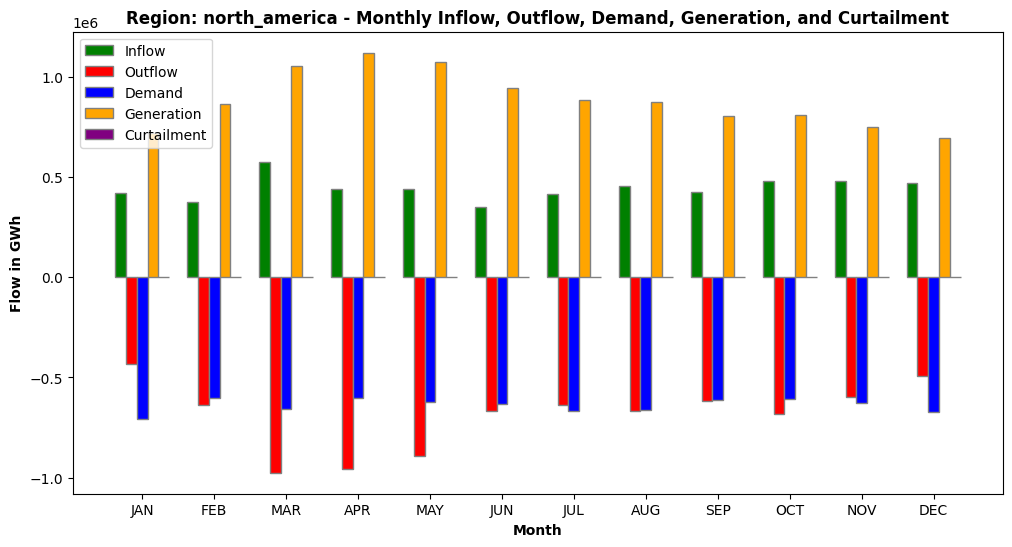

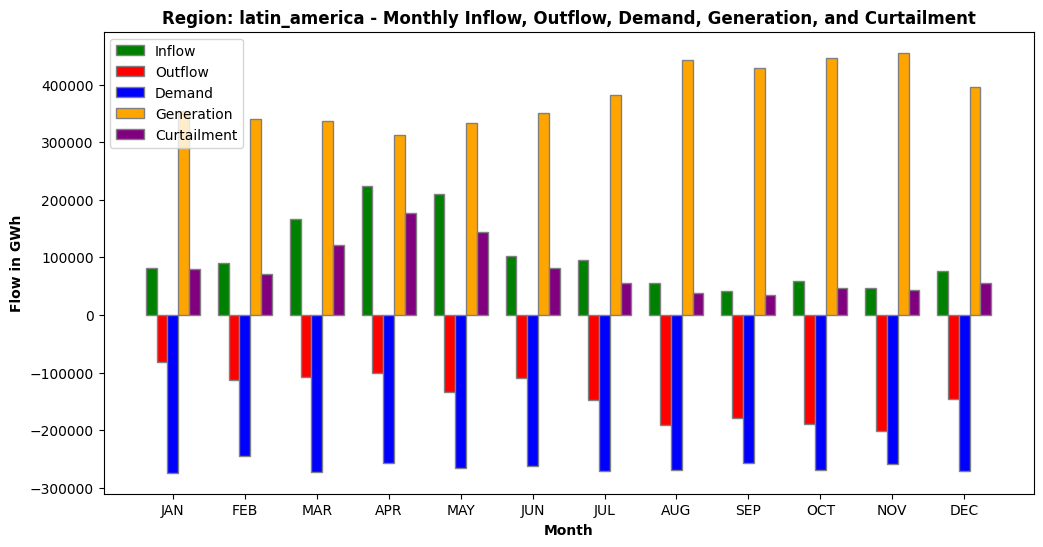

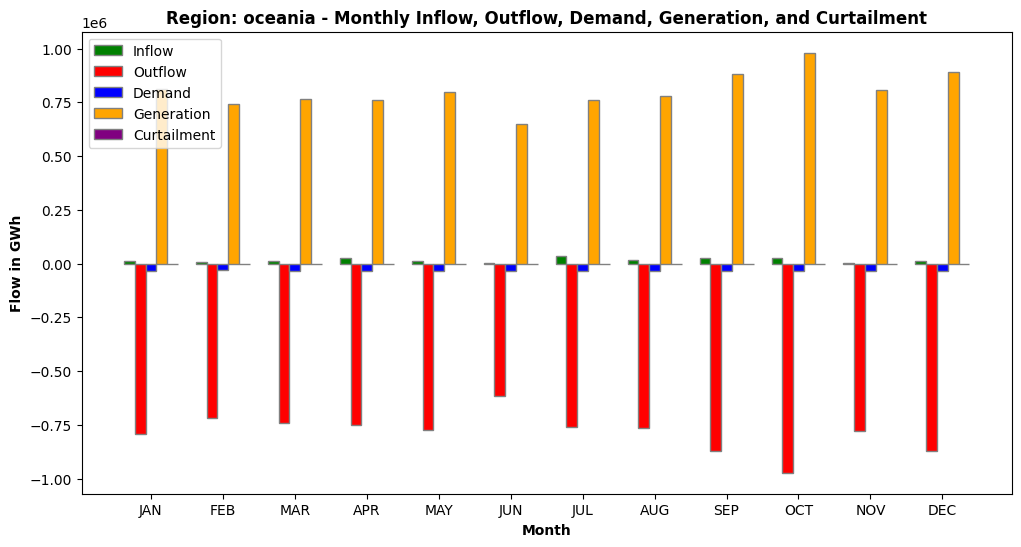

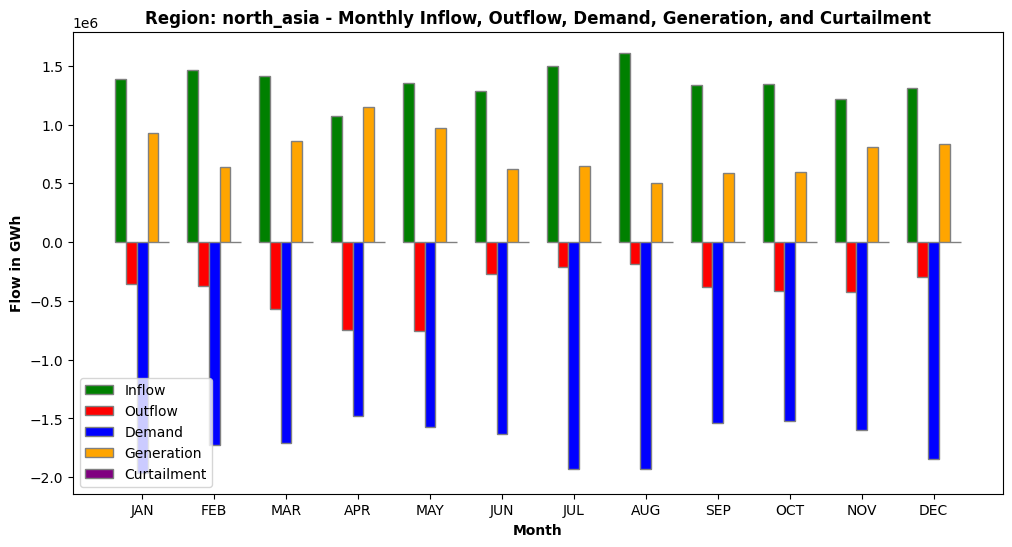

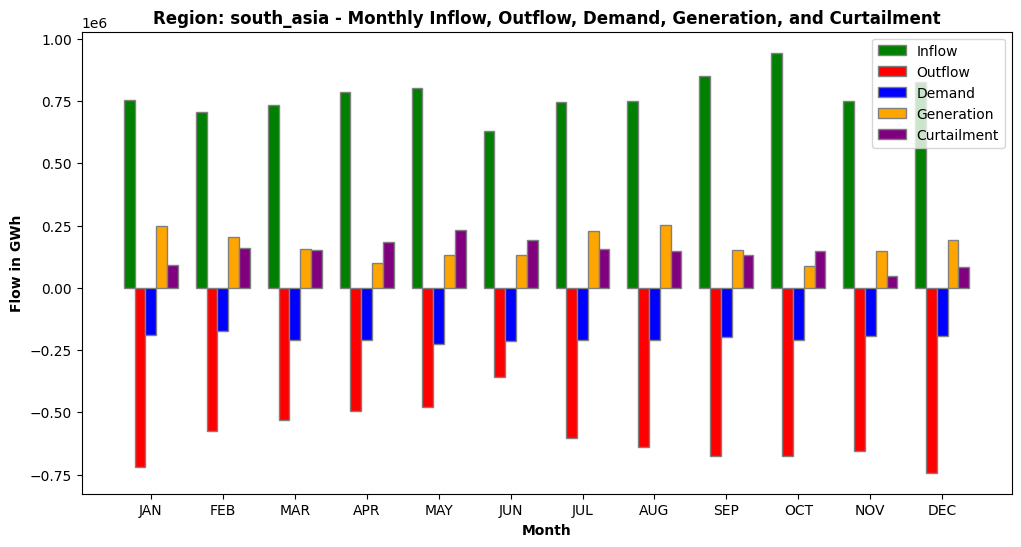

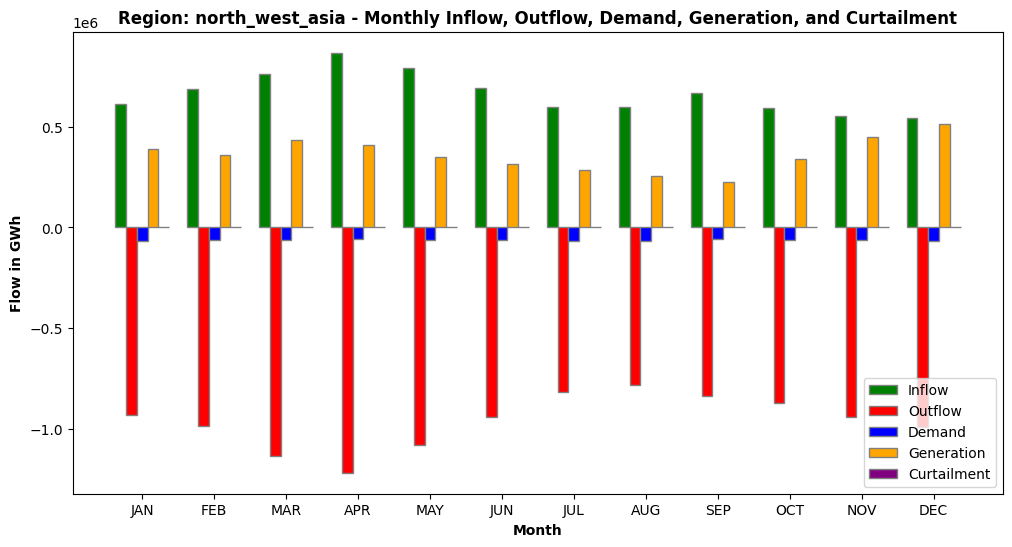

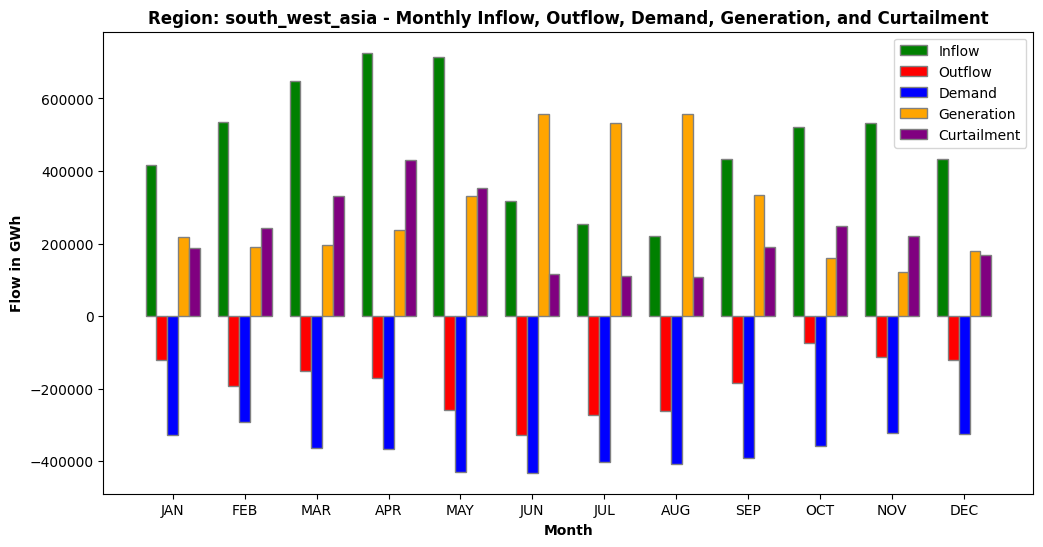

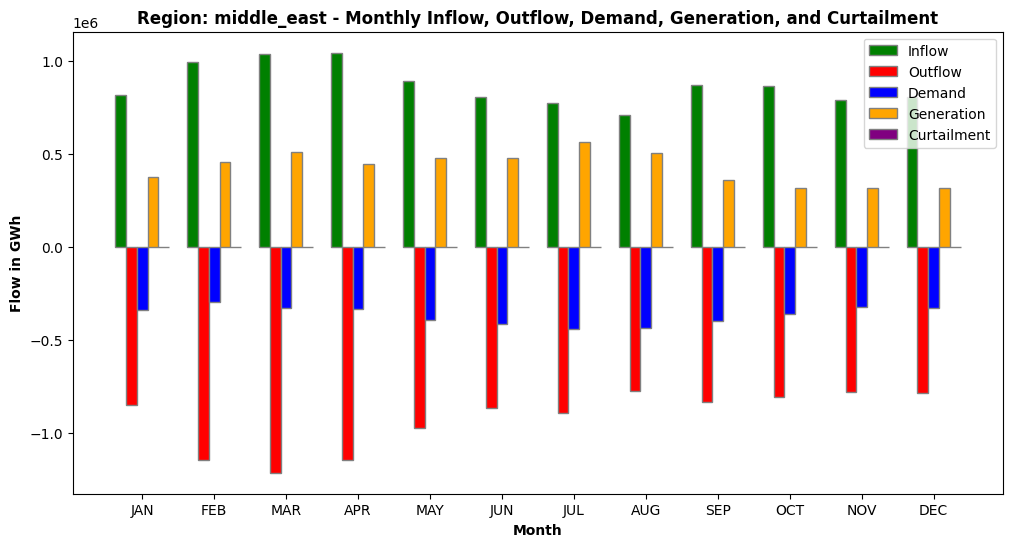

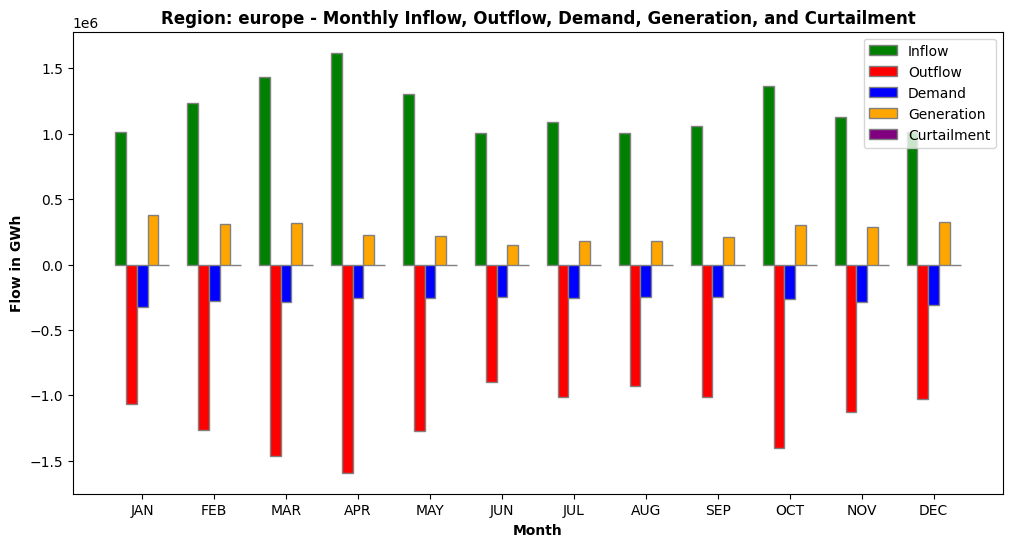

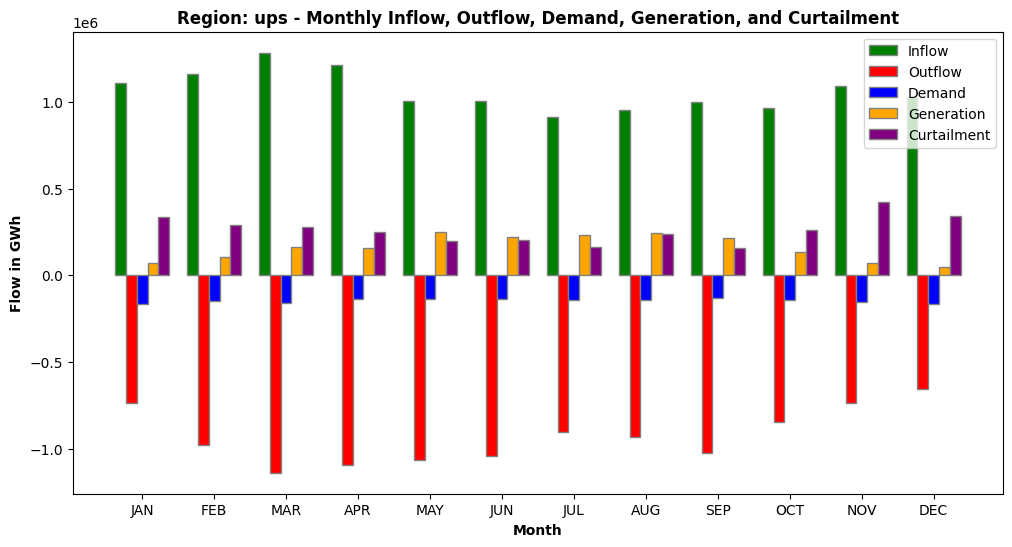

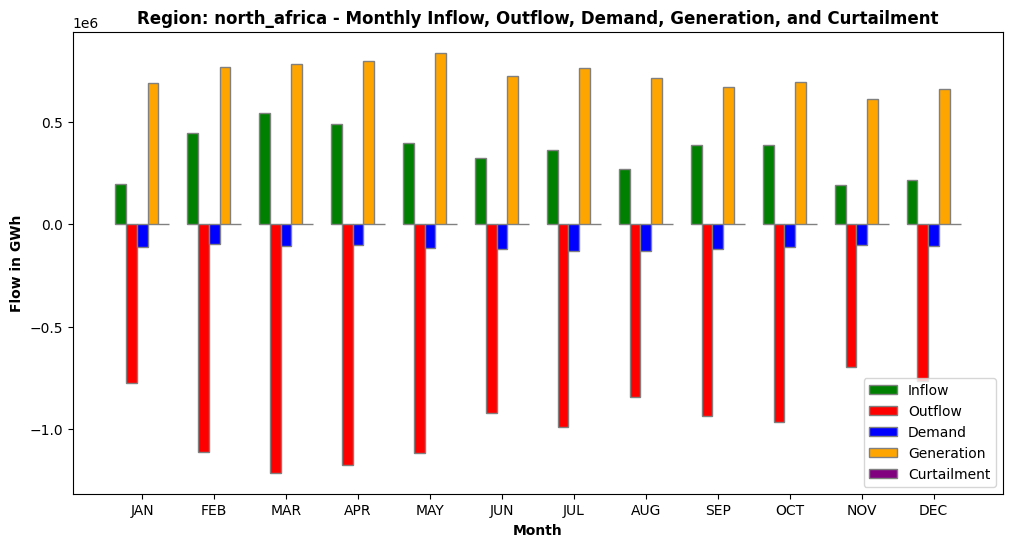

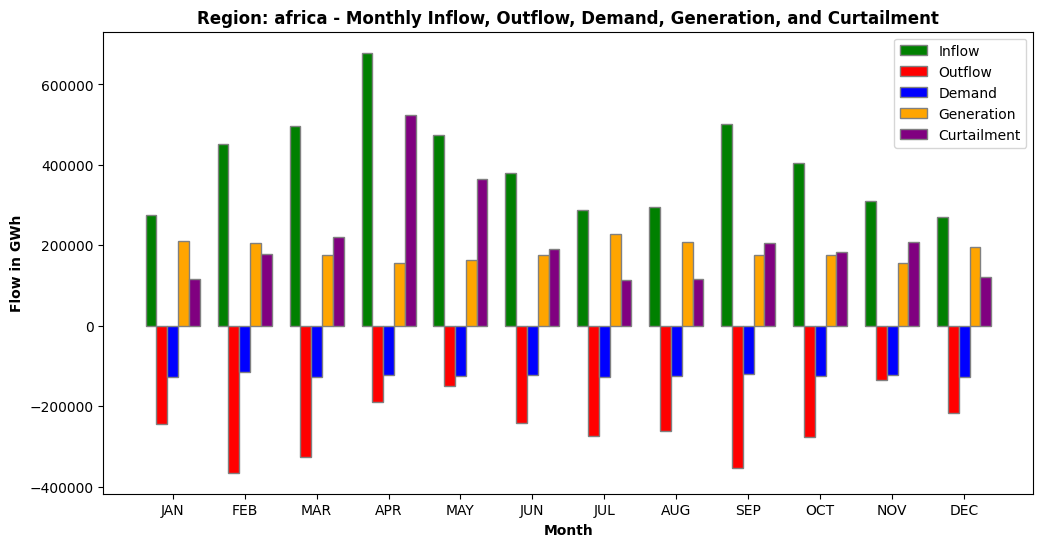

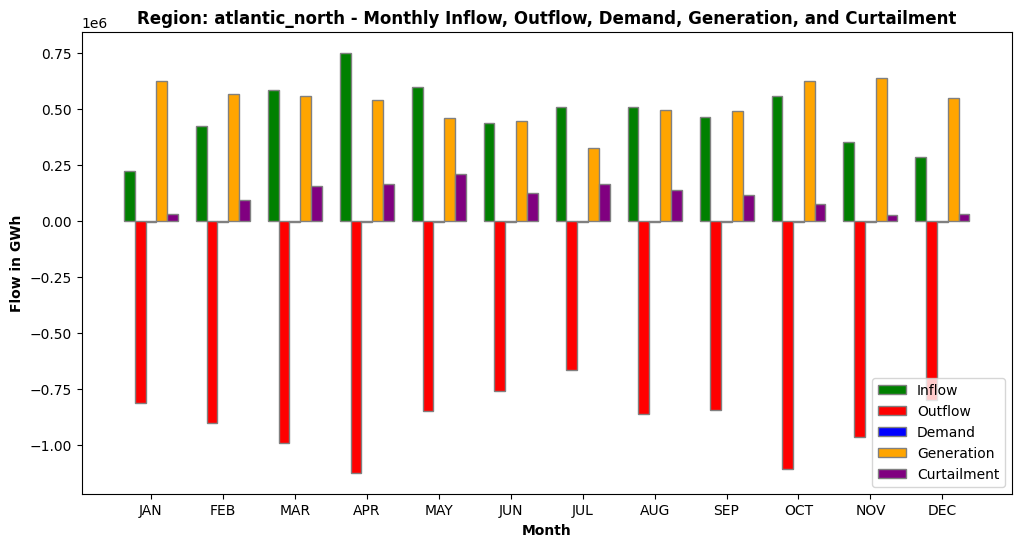

In [9]:
import matplotlib.pyplot as plt
import pandas as pd

# Define months and their corresponding periods
months = ['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']
month_periods = pd.period_range(start='2050-01', periods=12, freq='M')

# Function to create bar charts for each region
def plot_region_monthly_data(region_key, region_value):
    inflows = [region_value[f'inflow_{month}'] for month in months]
    outflows = [region_value[f'outflow_{month}'] for month in months]
    loads = [region_value[f'total_load_monthly'].loc[period]  for period in month_periods]
    generations = [(region_value[f'total_pv_monthly'].loc[period] + region_value[f'total_wind_monthly'].loc[period])  for period in month_periods]
    curtailments = [region_value[f'total_curtailment_monthly'].loc[period] for period in month_periods]

    # Create a bar chart
    fig, ax = plt.subplots(figsize=(12, 6))

    # Define the width of the bars
    bar_width = 0.15
    # Define the positions of the bars
    r1 = range(len(months))
    r2 = [x + bar_width for x in r1]
    r3 = [x + bar_width for x in r2]
    r4 = [x + bar_width for x in r3]
    r5 = [x + bar_width for x in r4]

    # Plotting the bars
    ax.bar(r1, inflows, color='green', width=bar_width, edgecolor='grey', label='Inflow')
    ax.bar(r2, [-outflow for outflow in outflows], color='red', width=bar_width, edgecolor='grey', label='Outflow')
    ax.bar(r3, [-load for load in loads], color='blue', width=bar_width, edgecolor='grey', label='Demand')
    ax.bar(r4, generations, color='orange', width=bar_width, edgecolor='grey', label='Generation')
    ax.bar(r5, curtailments, color='purple', width=bar_width, edgecolor='grey', label='Curtailment')

    # Add labels and title
    ax.set_xlabel('Month', fontweight='bold')
    ax.set_ylabel('Flow in GWh', fontweight='bold')
    ax.set_title(f'Region: {region_key} - Monthly Inflow, Outflow, Demand, Generation, and Curtailment', fontweight='bold')
    ax.set_xticks([r + 2*bar_width for r in range(len(months))])
    ax.set_xticklabels(months)
    ax.legend()

    # Show plot
    plt.show()

# Plot bar charts for each region
for region_key, region_value in regions_dic.items():
    plot_region_monthly_data(region_key, region_value)


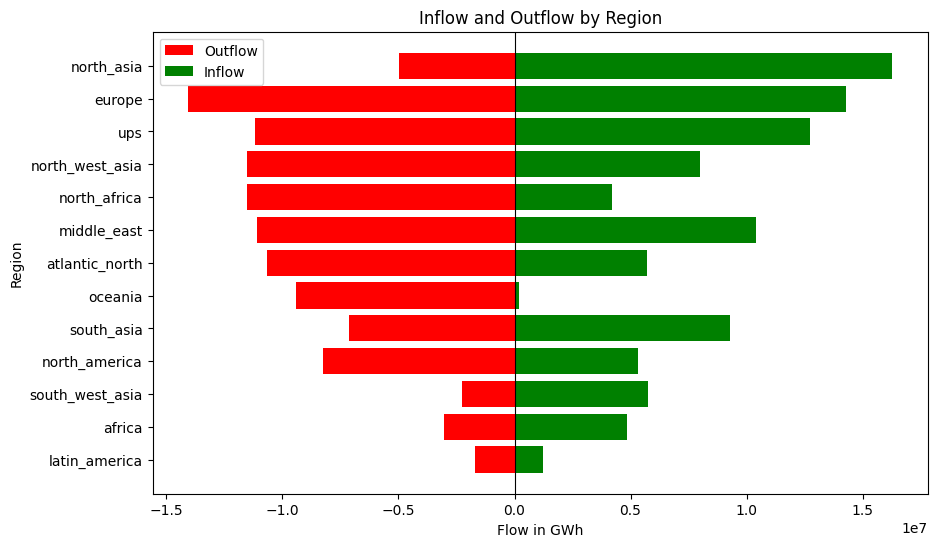

In [10]:
# Calculate the maximum flow for each region and store it along with region data
regions_data = [
    (region_key, region_value['inflow'], region_value['outflow'], max(region_value['inflow'], region_value['outflow']))
    for region_key, region_value in regions_dic.items()
]

# Sort the regions by the maximum flow in descending order
regions_data.sort(key=lambda x: x[3], reverse=False)

# Extract sorted data
regions = [item[0] for item in regions_data]
inflows = [item[1] for item in regions_data]
outflows = [item[2] for item in regions_data]

# Create a horizontal bar chart
fig, ax = plt.subplots(figsize=(10, 6))

# Plot outflows (negative values for left side)
ax.barh(regions, [-outflow for outflow in outflows], color='red', label='Outflow')

# Plot inflows
ax.barh(regions, inflows, color='green', label='Inflow')

# Add a vertical line at x=0 to separate inflows and outflows
ax.axvline(x=0, color='black', linewidth=0.8)

# Add labels and title
ax.set_xlabel('Flow in GWh')
ax.set_ylabel('Region')
ax.set_title('Inflow and Outflow by Region')
ax.legend()

# Show plot
plt.show()

timetraces of in and outflow
fitting fourier series and looking at grequency 

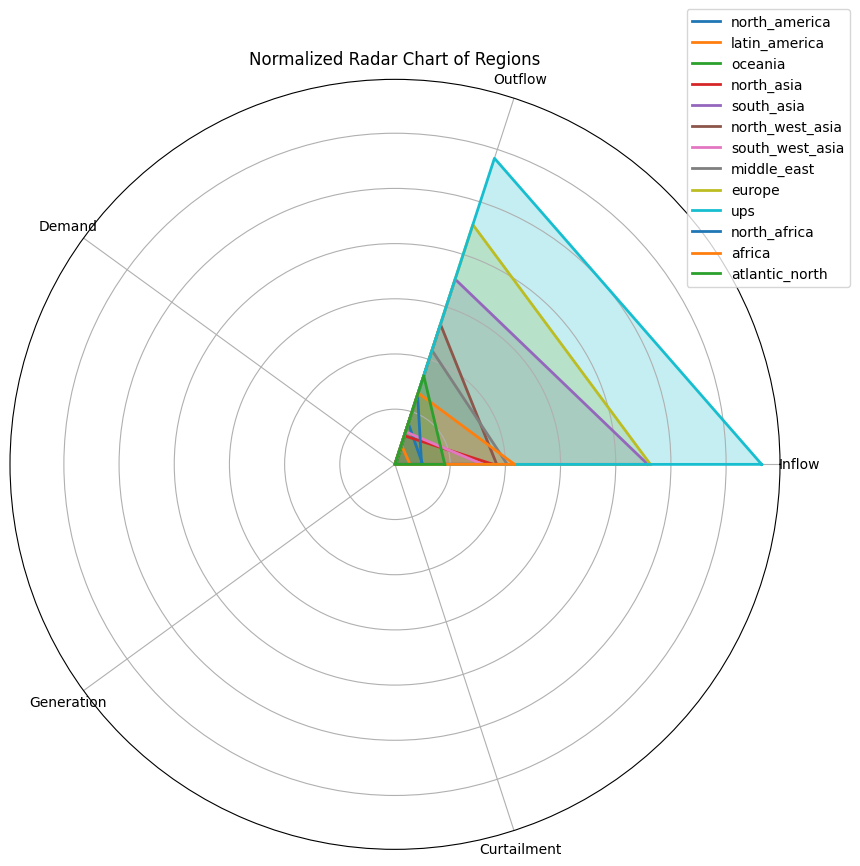

In [11]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from math import pi

# Sample data preparation (using the actual data from your regions_dic)
regions = list(regions_dic.keys())
variables = ['Inflow', 'Outflow', 'Demand', 'Generation', 'Curtailment']

# Prepare data
data = {
    region_key: [
        region_value['inflow'] / ((region_value['total_wind_yearly'] + region_value['total_pv_yearly']) / 1e3),  # Normalize to generation
        region_value['outflow'] / ((region_value['total_wind_yearly'] + region_value['total_pv_yearly']) / 1e3),  # Normalize to generation
        (region_value['total_load_yearly'] / 1e3) / ((region_value['total_wind_yearly'] + region_value['total_pv_yearly']) / 1e3),  # Normalize to generation
        1,  # Generation normalized to itself
        (region_value['total_curtailment_yearly'] / 1e3) / ((region_value['total_wind_yearly'] + region_value['total_pv_yearly']) / 1e3)  # Normalize to generation
    ]
    for region_key, region_value in regions_dic.items()
}

# Convert data to DataFrame
df = pd.DataFrame(data, index=variables)

# Number of variables
num_vars = len(variables)

# Compute angle for each axis
angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
angles += angles[:1]  # Complete the loop

# Initialize the radar chart
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

# Plot each region
for region in df.columns:
    values = df[region].tolist()
    values += values[:1]  # Complete the loop
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=region)
    ax.fill(angles, values, alpha=0.25)

# Add labels
ax.set_xticks(angles[:-1])
ax.set_xticklabels(variables)

# Add y-ticks
ax.set_yticklabels([])

# Add a title and legend
plt.title('Normalized Radar Chart of Regions')
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))

# Show the plot
plt.show()


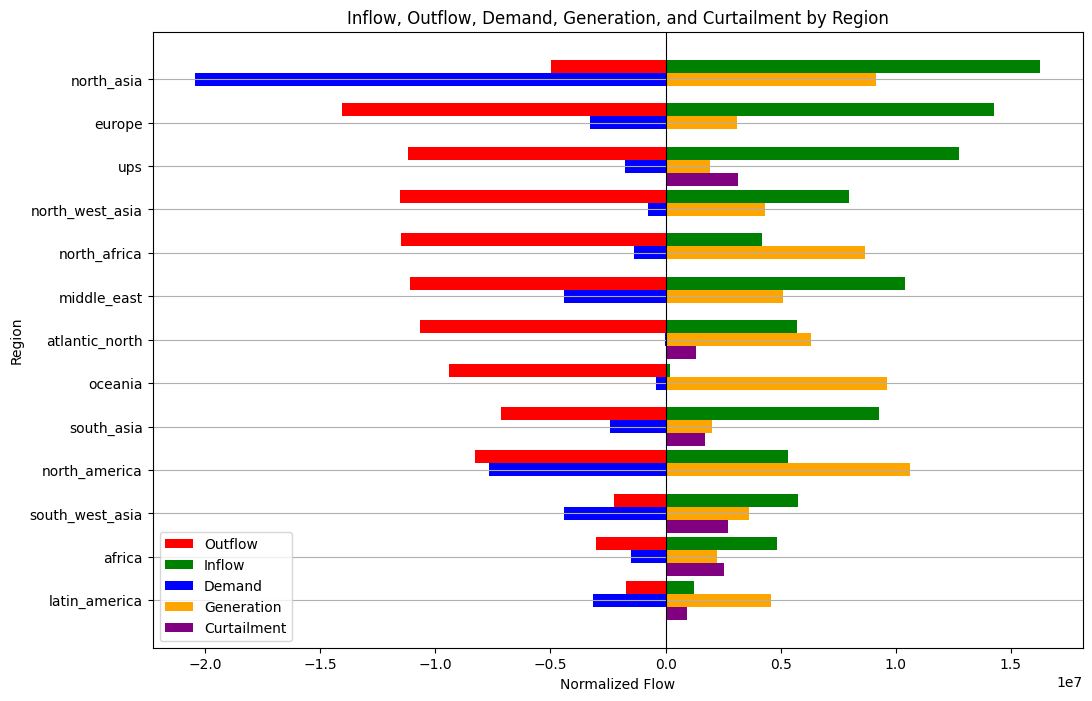

In [12]:
# Calculate the maximum flow for each region and store it along with region data
regions_data = [
    (
        region_key,
        region_value['inflow'] ,  
        region_value['outflow'] ,  
        region_value['total_load_yearly'] ,  
        (region_value['total_wind_yearly'] + region_value['total_pv_yearly']),  
        region_value['total_curtailment_yearly'] , 
        max(
            abs(region_value['inflow']),
            abs(region_value['outflow'])
        ) 
    )
    for region_key, region_value in regions_dic.items()
]

# Sort the regions by the maximum flow in descending order
regions_data.sort(key=lambda x: x[6], reverse=False)

# Extract sorted data
regions = [item[0] for item in regions_data]
inflows = [item[1] for item in regions_data]
outflows = [item[2] for item in regions_data]
loads = [item[3] for item in regions_data]
generations = [item[4] for item in regions_data]
curtailments = [item[5] for item in regions_data]

# Create a horizontal bar chart
fig, ax = plt.subplots(figsize=(12, 8))

# Calculate the y positions for the bars
y_positions = range(len(regions))

# Plot outflows (negative values for left side)
ax.barh([y + 0.3 for y in y_positions], [-outflow for outflow in outflows], color='red', label='Outflow', height=0.3)

# Plot inflows
ax.barh([y + 0.3 for y in y_positions], inflows, color='green', label='Inflow', height=0.3)

# Plot loads (negative values for left side)
ax.barh([y for y in y_positions], [-load for load in loads], color='blue', label='Demand', height=0.3)

# Plot generations
ax.barh([y for y in y_positions], generations, color='orange', label='Generation', height=0.3)

# Plot curtailments
ax.barh([y - 0.3 for y in y_positions], curtailments, color='purple', label='Curtailment', height=0.3)

# Add a vertical line at x=0 to separate inflows and outflows
ax.axvline(x=0, color='black', linewidth=0.8)

# Customize the grid
ax.grid(True, axis='y')  # Only show horizontal grid lines
ax.grid(False, axis='x')  # Remove vertical grid lines

# Add labels and title
ax.set_xlabel('Normalized Flow')
ax.set_ylabel('Region')
ax.set_title('Inflow, Outflow, Demand, Generation, and Curtailment by Region')
ax.set_yticks([y for y in y_positions])
ax.set_yticklabels(regions)
ax.legend()

# Show plot
plt.show()

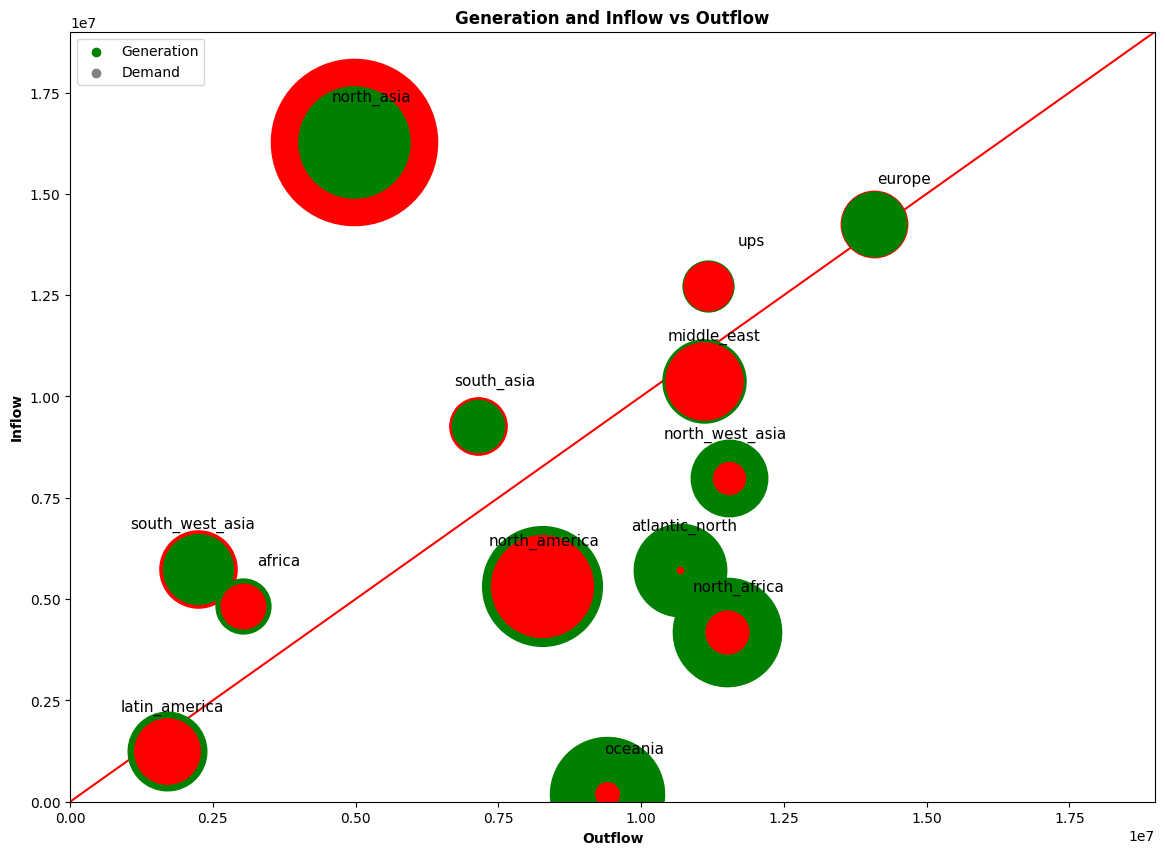

In [13]:
regions_data = [
    (
        region_key,
        region_value['inflow'],  
        region_value['outflow'], 
        region_value['total_load_yearly'], 
        (region_value['total_wind_yearly'] + region_value['total_pv_yearly']),  
    )
    for region_key, region_value in regions_dic.items()
]

# Extracting inflow, outflow, and generation
inflow = [data[1] for data in regions_data]
outflow = [data[2] for data in regions_data]
generation = [data[4] for data in regions_data]  # total_wind_yearly + total_pv_yearly
demand = [data[3] for data in regions_data]
region_names = [data[0] for data in regions_data]

# Plotting
plt.figure(figsize=(14, 10))
# Adding y=x line
plt.plot([0, 0, 1.9e7, 1.9e7], 
         [0, 0, 1.9e7, 1.9e7], 
         'r-',  zorder=0)
# Scatter plot with distinct colors
for i, name in enumerate(region_names):
    if generation[i] > demand[i]:
        plt.scatter(outflow[i], inflow[i], s=generation[i] * 0.7e-3 , alpha=1.0, color='green')
        plt.scatter(outflow[i], inflow[i], s=demand[i] * 0.7e-3 , alpha=1.0, color='red')
    elif generation[i] <= demand[i]:
        plt.scatter(outflow[i], inflow[i], s=demand[i] * 0.7e-3 , alpha=1.0, color='red')
        plt.scatter(outflow[i], inflow[i], s=generation[i] * 0.7e-3 , alpha=1.0, color='green')
plt.scatter([], [], color='green', label='Generation')
plt.scatter([], [], color='gray', label='Demand')
plt.legend()
# Labels and title
plt.xlabel('Outflow', fontweight='bold')
plt.ylabel('Inflow', fontweight='bold')
plt.xlim(0, 1.9e7)
plt.ylim(0, 1.9e7)
plt.title('Generation and Inflow vs Outflow', fontweight='bold')

# Annotating points with a small offset
offset = 0.1e7  
for i, name in enumerate(region_names):
    plt.annotate(name, (outflow[i] + offset, inflow[i] + offset), fontsize=11, ha='right')



plt.show()


Plot with generation over demand 

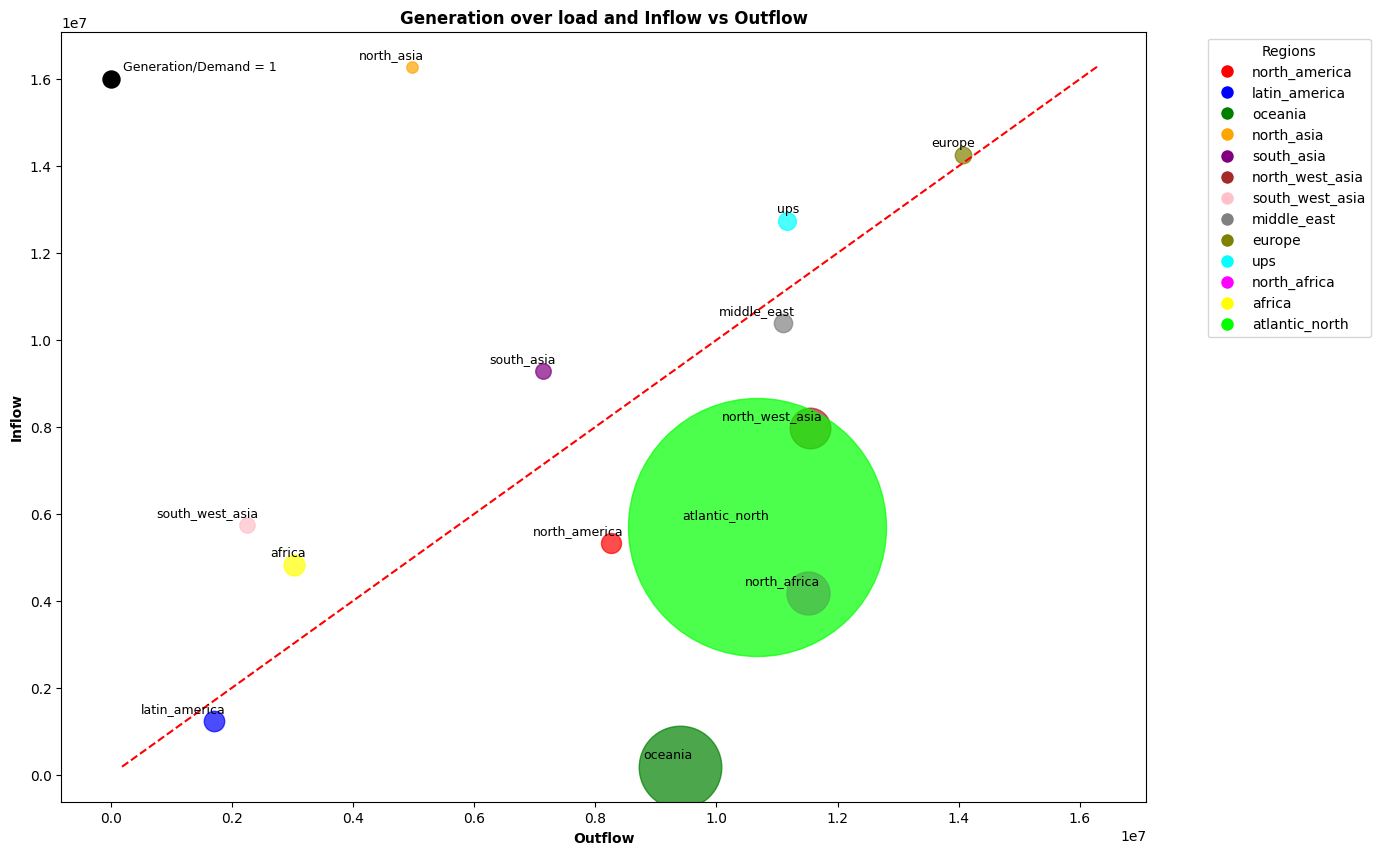

In [14]:
regions_data = [
    (
        region_key,
        region_value['inflow'],  
        region_value['outflow'], 
        region_value['total_load_yearly'], 
        (region_value['total_wind_yearly'] + region_value['total_pv_yearly']) / region_value['total_load_yearly'],  
    )
    for region_key, region_value in regions_dic.items()
]

# Extracting inflow, outflow, and generation
inflow = [data[1] for data in regions_data]
outflow = [data[2] for data in regions_data]
generation = [data[4] for data in regions_data]  # total_wind_yearly + total_pv_yearly
region_names = [data[0] for data in regions_data]

# Define a set of distinct colors
distinct_colors = [
    'red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan',
    'magenta', 'yellow', 'lime'
]

# Ensure the number of colors matches the number of regions
if len(region_names) > len(distinct_colors):
    raise ValueError("Number of regions exceeds the number of distinct colors available.")

# Plotting
plt.figure(figsize=(14, 10))

# Scatter plot with distinct colors
for i, name in enumerate(region_names):
    plt.scatter(outflow[i], inflow[i], s=generation[i] * 1.5e2, alpha=0.7, color=distinct_colors[i], label=name)
plt.scatter(0, 1.6e7, s=1.5e2, color='black', label='Generation/Demand = 1')
# Adding y=x line
plt.plot([min(min(inflow), min(outflow)), max(max(inflow), max(outflow))], 
         [min(min(inflow), min(outflow)), max(max(inflow), max(outflow))], 
         'r--', label='y=x')

# Labels and title
plt.xlabel('Outflow', fontweight='bold')
plt.ylabel('Inflow', fontweight='bold')
plt.title('Generation over load and Inflow vs Outflow', fontweight='bold')

# Annotating points with a small offset
offset = 0.02e7  # You can adjust the offset value as needed
for i, name in enumerate(region_names):
    plt.annotate(name, (outflow[i] + offset, inflow[i] + offset), fontsize=9, ha='right')
plt.annotate("Generation/Demand = 1", (0 + offset, 1.6e7 + offset), fontsize=9, ha='left')

# Create a legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=distinct_colors[i], markersize=10, label=region_names[i]) for i in range(len(region_names))]
plt.legend(handles=handles, title="Regions", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()


Chord diagram

In [15]:
regions_dic.keys()

dict_keys(['north_america', 'latin_america', 'oceania', 'north_asia', 'south_asia', 'north_west_asia', 'south_west_asia', 'middle_east', 'europe', 'ups', 'north_africa', 'africa', 'atlantic_north'])

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
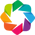

latin_america north_america -302322028.9102371
north_america ups 1767629457.7860885
north_america atlantic_north 912401499.3035512
oceania south_asia 9208321422.537376
south_asia north_asia -6500536645.290313
north_west_asia north_asia -2616861321.0324883
north_asia south_west_asia 459189532.9351423
ups north_asia -3830808075.969306
north_west_asia south_west_asia 3435784803.0083513
middle_east north_west_asia -2237978575.6369896
ups north_west_asia -669892475.1848702
europe middle_east -1927284526.5354404
middle_east ups 1801173415.6042883
north_africa middle_east -2776595228.1529207
middle_east africa 612733128.646589
europe ups 5106745958.30963
north_africa europe -2648535128.530526
atlantic_north europe -5440418186.383887
north_africa africa 1617450446.38747


:Chord   [source,target]   (value)

In [16]:
import pandas as pd
import holoviews as hv
from holoviews import opts, dim

hv.extension('bokeh')
hv.output(size=200)
# Calculate total flow for each link and store in data frame
link_flow_data = []
for link_key, link_value in links_dic.items():
    p0_0 = n.links_t.p0[f"{link_value["name"]}_0"]
    p0_1 = n.links_t.p0[f"{link_value["name"]}_1"]
    sum_p0_0 = abs(sum(p0_0))
    sum_p0_1 = abs(sum(p0_1))
    net_flow = sum_p0_0 - sum_p0_1
    if net_flow > 0:
        bus0 = link_value["bus0"][1]
        bus1 = link_value["bus1"][1]
    else:
        bus0 = link_value["bus1"][1]
        bus1 = link_value["bus0"][1]
    print(bus0, bus1, net_flow)
    link_flow_data.append((bus0, bus1, abs(net_flow)))
links = pd.DataFrame(link_flow_data, columns=['source', 'target', 'value'])

# Convert the keys of the dictionary to a list and create a DataFrame
regions_df = pd.DataFrame(list(regions_dic.keys()), columns=['index'])

# Create a Dataset for nodes
nodes = hv.Dataset(regions_df, 'index')

chord = hv.Chord((links, nodes)).select(value=(100, None))
chord.opts(
    opts.Chord(cmap='Category20', edge_cmap='Category20', edge_color=dim('source').str(), 
               labels='index', node_color=dim('index').str()))

## Plotting of just the map

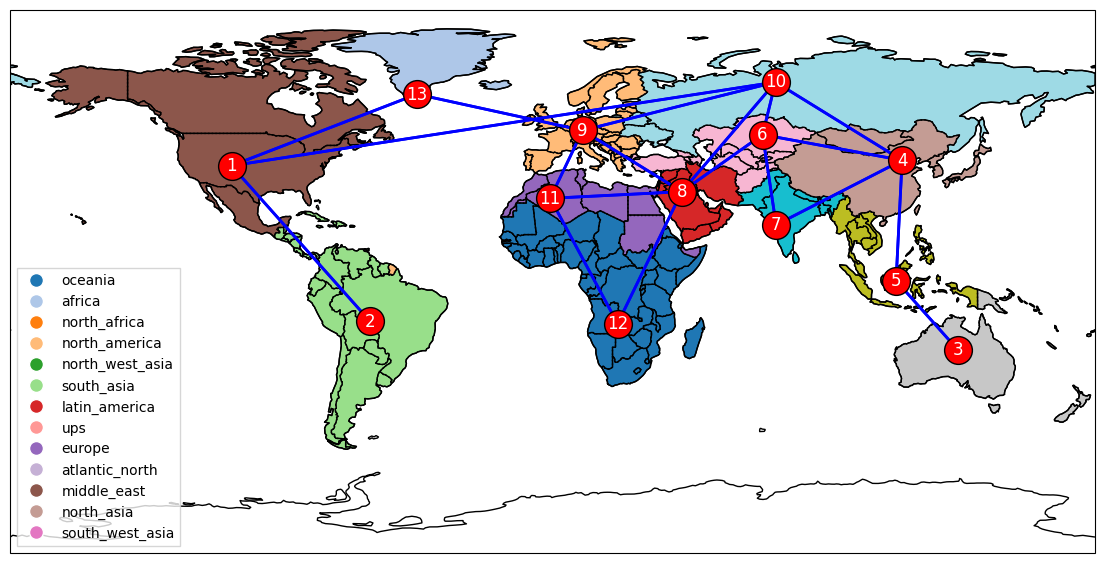

In [17]:
import warnings
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from pyproj import Geod
import geopandas as gpd
from cartopy.geodesic import Geodesic

warnings.filterwarnings("ignore", category=UserWarning)
plt.rc("figure", figsize=(14, 10))

# Load the naturalearth_lowres dataset
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Create a column in the world dataframe that matches the bus to country dictionary
world['bus'] = None
for key, value in regions_dic.items():
    for country in value["countries"]:
        world.loc[world['name'] == country, 'bus'] = key

# Plotting the network with results
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([-180, 180, -90, 90])  # Adjust extent as needed

# Add base map features
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Plot country regions without legend
world.plot(ax=ax, column='bus', cmap='tab20', legend=False, edgecolor='black', transform=ccrs.PlateCarree())

# Create a custom legend
unique_regions = world['bus'].dropna().unique()
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=plt.cm.tab20(i), markersize=10, label=region) for i, region in enumerate(unique_regions)]
ax.legend(handles=handles, loc='lower left', bbox_to_anchor=(0.0, 0.0), fancybox=False, shadow=False, ncol=1)

for i, bus in enumerate(n.buses.index, start=1):
    x, y = n.buses.loc[bus, ['x', 'y']]
    ax.scatter(x, y, s=400, color='red', edgecolor='k', zorder=5)
    ax.text(x, y, str(i), color='white', fontsize=12, ha='center', va='center', zorder=6)

# Define the Geod object for WGS84
geod = Geod(ellps="WGS84")

# Plot links
for link in n.links.index:
    bus0 = n.links.loc[link, 'bus0']
    bus1 = n.links.loc[link, 'bus1']
    x0, y0 = n.buses.loc[bus0, ['x', 'y']]
    x1, y1 = n.buses.loc[bus1, ['x', 'y']]

    if link == "Alaska to UPS":  # Specifically handle the link from North America to UPS
        # Calculate points along the great circle
        points = geod.npts(x0, y0, x1, y1, 100)
        lons, lats = zip(*points)
        lons = [(lon + 360) % 360 if lon < 0 else lon for lon in lons]  # Ensure all longitudes are positive
        ax.plot(lons, lats, color='blue', linewidth=2, zorder=4)
    else:
        ax.plot([x0, x1], [y0, y1], color='blue', linewidth=2, zorder=4)


make them relative values, maybe as a percentage of installed capacity, or per capita or per area

In [18]:
# import warnings
# import cartopy.crs as ccrs
# import cartopy.feature as cfeature
# import matplotlib.pyplot as plt
# import geopandas as gpd
# from pyproj import Geod
# from matplotlib.colors import Normalize
# import matplotlib.cm as cm

# warnings.filterwarnings("ignore", category=UserWarning)
# plt.rc("figure", figsize=(14, 10))

# installed_capacity_wind_dic = {}
# installed_capacity_pv_dic = {}
# installed_cap_pv_area = {}
# installed_cap_wind_area = {}
# curtailment_rel_to_gen = {}
# loads_dic = {}
# generation_area_dic = {}
# generation_dic = {}
# for key, value in regions_dic.items():
#     area = region_area(key)
#     installed_capacity_wind_dic[key] = value["wind_installed"] / 1e6
#     installed_capacity_pv_dic[key] = value["pv_installed"] / 1e6
#     installed_cap_pv_area[key] = value["wind_installed"] / area * 1e6
#     installed_cap_wind_area[key] = value["pv_installed"] / area * 1e6
#     curtailment_rel_to_gen[key] = value["total_curtailment_yearly"] / (value["total_wind_yearly"] + value["total_pv_yearly"])
#     loads_dic[key] = value["total_load_yearly"] / 1e6
#     generation_dic[key] = value["total_wind_yearly"] + value["total_pv_yearly"] / 1e6
# values_dics = [installed_capacity_pv_dic, installed_cap_pv_area,  installed_capacity_wind_dic,  installed_cap_wind_area, curtailment_rel_to_gen, generation_dic, loads_dic]

# # Load the naturalearth_lowres dataset
# world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# # Create a column in the world dataframe that matches the bus to country dictionary
# world['bus'] = None
# for key, value in regions_dic.items():
#     for country in value["countries"]:
#         world.loc[world['name'] == country, 'bus'] = key

# for i, values_dic in enumerate(values_dics):
#     # Add the values to the world GeoDataFrame
#     world['value'] = world['bus'].map(values_dic)

#     # Merge countries into regions, aggregating only the 'value' column
#     regions = world.dissolve(by='bus', aggfunc={'value': 'mean'})

#     # Plotting the network with results
#     fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
#     ax.set_extent([-180, 180, -90, 90])  # Adjust extent as needed

#     # Add base map features
#     ax.add_feature(cfeature.COASTLINE)

#     # Normalize the values for the colormap
#     norm = Normalize(vmin=min(values_dic.values()), vmax=max(values_dic.values()))
#     cmap = cm.YlOrRd

#     # Plot regions with the heatmap, making sure normalization is applied
#     regions.plot(ax=ax, column='value', cmap=cmap, norm=norm, legend=False, edgecolor='black', transform=ccrs.PlateCarree())

#     # for i, bus in enumerate(n.buses.index, start=1):
#     #     x, y = n.buses.loc[bus, ['x', 'y']]
#     #     ax.scatter(x, y, s=400, color='black', edgecolor='k', zorder=5)
#     #     ax.text(x, y, str(i), color='white', fontsize=12, ha='center', va='center', zorder=6)

#     # Add a title to the figure
#     if i == 0:
#         plt.title('Installed Wind Capacity', fontsize=16)
#     elif i == 1:
#         plt.title('Density of Installed Wind Capacity', fontsize=16)
#     elif i == 2:
#         plt.title('Installed Solar Capacity', fontsize=16)
#     elif i == 3:
#         plt.title('Density of Installed Solar Capacity', fontsize=16)
#     elif i == 4:
#         plt.title('Annual Curtailment over Generation', fontsize=16)
#     elif i == 5:
#         plt.title('Annual Electricity Generation', fontsize=16)
#     elif i == 6:
#         plt.title('Annual Electricity Demand', fontsize=16)

#     # Create and customize the color bar
#     sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
#     sm._A = []  # Dummy array for the scalar mappable
#     cbar = fig.colorbar(sm, ax=ax, orientation='vertical', shrink=0.5)
#     if i == np.any([1, 3]):
#         cbar.set_label('W/m2')
#     elif i == np.any([5, 6]):
#         cbar.set_label('TWh')
#     elif i == 4:
#         cbar.set_label('[-]')
#     else:
#         cbar.set_label('Terrawatts')


#     plt.show()

## Plotting of demand and supply graphs


In [19]:
plt.style.use('seaborn-v0_8-whitegrid')  

for key, value in regions_dic.items():
    print(key)
    # series_l = value["load"]
    # load = series_l.groupby(series_l.index.to_period('M')).sum()
    load = value['mean_load_monthly']
    wind = value["mean_wind_monthly"]
    pv = value["mean_pv_monthly"]

    # Extract values and months
    months = load.index.month
    load_values = load.values
    wind_values = wind.values
    pv_values = pv.values

    plt.figure(figsize=(12, 8))
    
    # # Stacked area plot for wind and PV
    plt.stackplot(months, wind_values, pv_values, labels=['Wind', 'PV'], colors=['blue', 'orange'], alpha=0.5)
    
    # Plot load on top
    plt.plot(months, load_values, label='Load', linestyle='--', color='red', linewidth=4)
    
    plt.title(f'{key}', fontsize=20, fontweight='bold')
    plt.xlabel('Month', fontsize=16)
    plt.ylabel('MW', fontsize=16)
    legend = plt.legend(loc='best', fontsize=16)
    for text in legend.get_texts():
        text.set_color('black')  # Set legend text color to black
        #text.set_fontweight('bold')  # Make legend text bold
    # Customize ticks
    plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], fontsize=16)
    plt.yticks(fontsize=16)
    # Tight layout to ensure everything fits without overlapping
    plt.tight_layout()
    
    
    # Show the plot
    plt.show()


In [57]:
print(total_monthly_wind.index)
print(total_monthly_pv.values)
print(total_monthly_wind.values)

PeriodIndex(['2050-01', '2050-02', '2050-03', '2050-04', '2050-05', '2050-06',
             '2050-07', '2050-08', '2050-09', '2050-10', '2050-11', '2050-12'],
            dtype='period[M]', name='snapshot')
[1.26754801e+09 1.38205134e+09 1.73995462e+09 1.77795501e+09
 1.88132370e+09 1.68776875e+09 1.74172869e+09 1.74769746e+09
 1.67492235e+09 1.55493646e+09 1.30139937e+09 1.24015406e+09]
[4.74556210e+09 4.36502962e+09 4.56774600e+09 4.63493206e+09
 4.52481259e+09 4.07113284e+09 4.27019628e+09 4.25739227e+09
 3.86227822e+09 4.10791145e+09 4.31053405e+09 4.55267448e+09]


## Plotting of losses

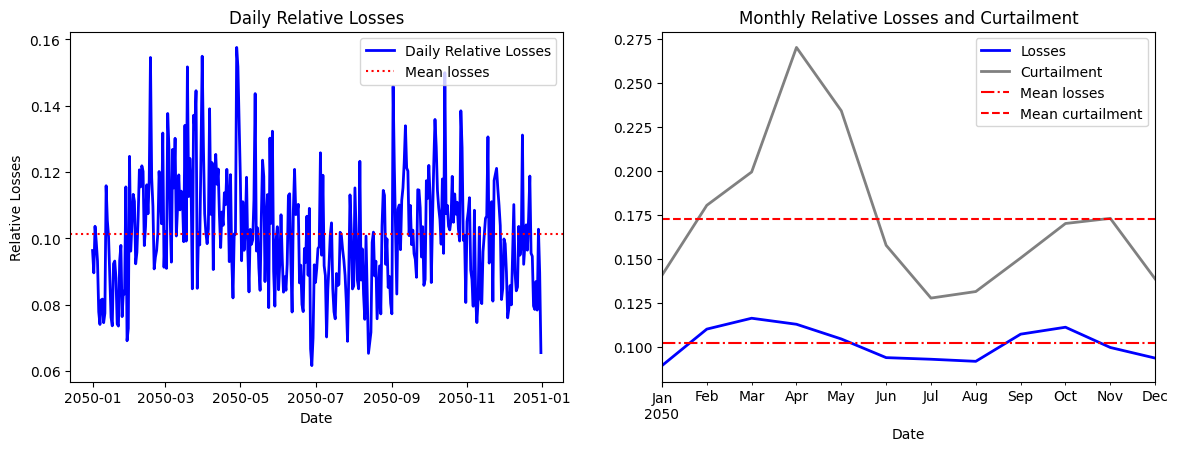

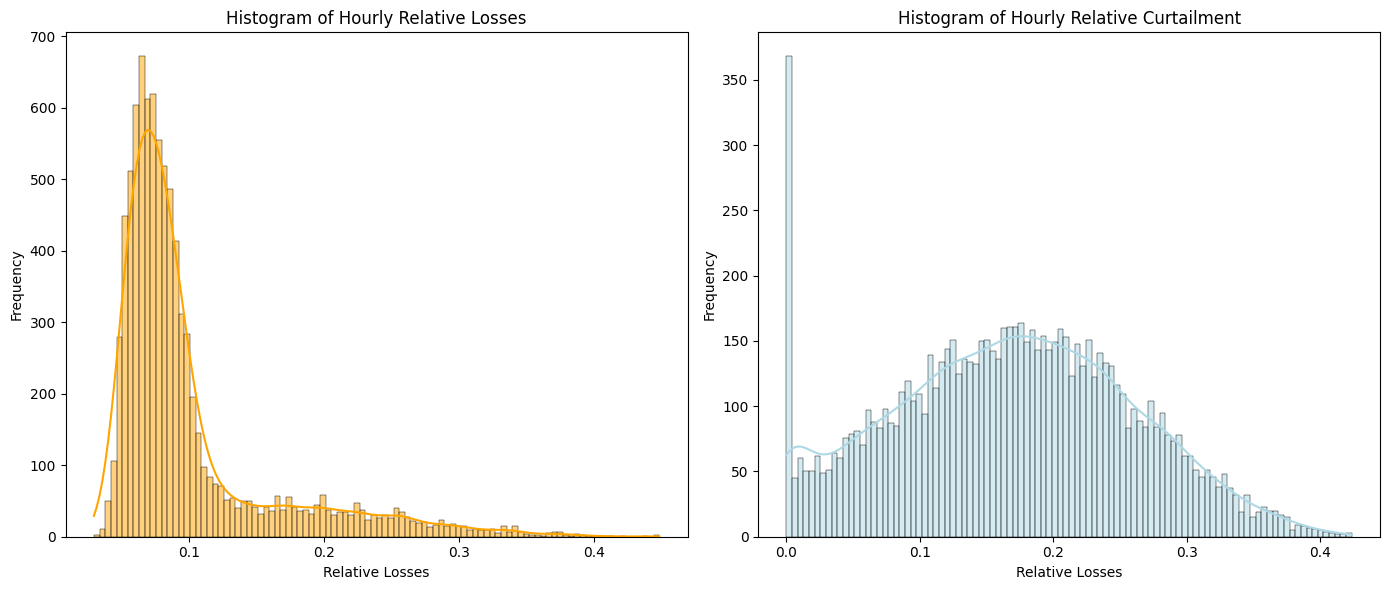

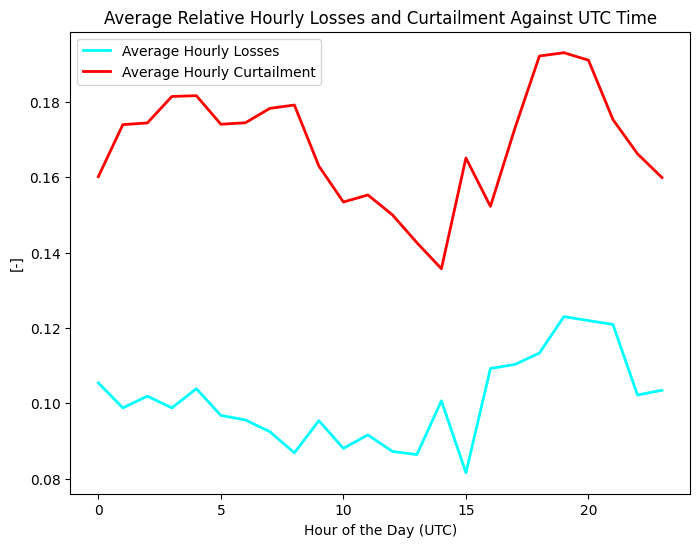

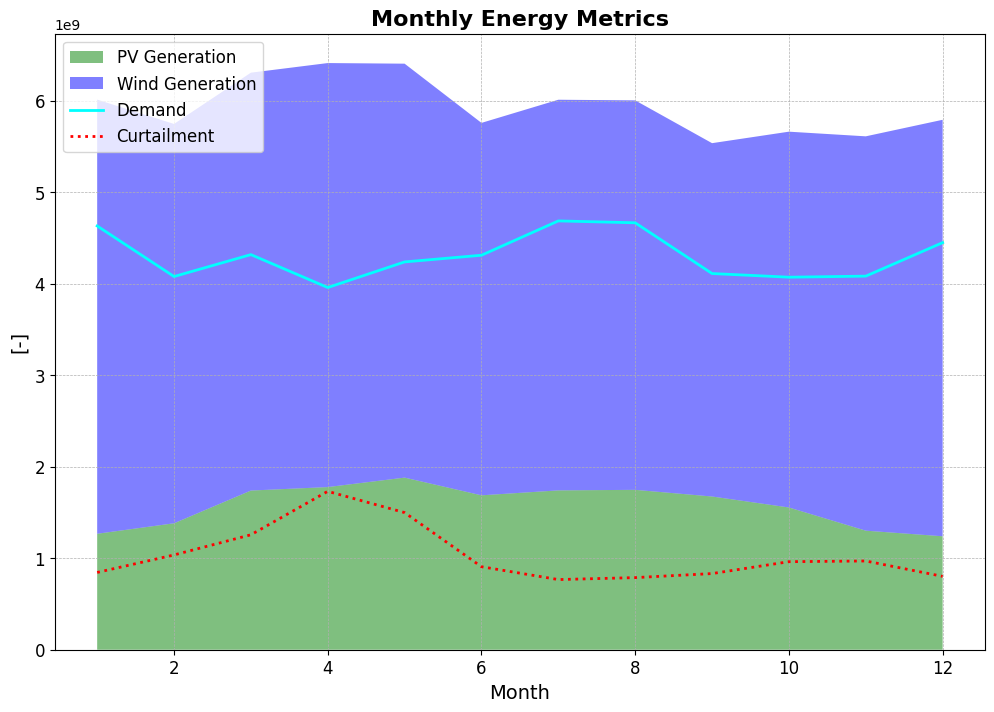

In [59]:
# Plot daily relative losses and compare to mean
plt.figure(figsize=(14, 10))

# Daily Relative Losses
plt.subplot(2, 2, 1)
daily_losses_rel_to_gen.plot(label='Daily Relative Losses', color='blue', linestyle='-', linewidth=2)
plt.axhline(y=daily_losses_rel_to_gen.mean(), color='red', linestyle=':', label='Mean losses')
plt.title('Daily Relative Losses')
plt.xlabel('Date')
plt.ylabel('Relative Losses')
plt.legend()

# Monthly Average Losses
plt.subplot(2, 2, 2)
monthly_losses_rel_to_gen.plot(label='Losses', color='blue', linewidth=2)
monthly_cur_rel_to_gen.plot(label='Curtailment', color='gray', linestyle='-', linewidth=2)
plt.axhline(y=monthly_losses_rel_to_gen.mean(), color='red', linestyle='-.', label='Mean losses')
plt.axhline(y=monthly_cur_rel_to_gen.mean(), color='red', linestyle='--', label='Mean curtailment')
plt.title('Monthly Relative Losses and Curtailment')
plt.xlabel('Date')
plt.legend()

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(hourly_losses_rel_to_gen, bins=100, kde=True, color='orange')
plt.title('Histogram of Hourly Relative Losses')
plt.xlabel('Relative Losses')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(hourly_cur_rel_to_gen, bins=100, kde=True, color='lightblue')
plt.title('Histogram of Hourly Relative Curtailment')
plt.xlabel('Relative Losses')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Losses against UTC time
hourly_losses = hourly_losses_rel_to_gen.groupby(hourly_losses_rel_to_gen.index.hour).mean()
hourly_cur = hourly_cur_rel_to_gen.groupby(hourly_cur_rel_to_gen.index.hour).mean()
plt.figure(figsize=(8, 6))
hourly_losses.plot(label='Average Hourly Losses', color='cyan', linewidth=2)
hourly_cur.plot(label='Average Hourly Curtailment', color='red', linewidth=2)
plt.title('Average Relative Hourly Losses and Curtailment Against UTC Time')
plt.xlabel('Hour of the Day (UTC)')
plt.ylabel('[-]')
plt.legend()
plt.show()

plt.figure(figsize=(12, 8))  # Increase figure size for better readability

# Plot stackplot for PV and wind generation
plt.stackplot(total_monthly_pv.index.month, total_monthly_pv.values, total_monthly_wind.values, labels=['PV Generation', 'Wind Generation'], colors=['green', 'blue'], alpha=0.5)

# Plot line plots for Demand and Curtailment
plt.plot(total_monthly_pv.index.month, total_monthly_load, label='Demand', color='cyan', linewidth=2, linestyle='-')
plt.plot(total_monthly_pv.index.month, total_monthly_cur, label='Curtailment', color='red', linewidth=2, linestyle=':')

plt.title('Monthly Energy Metrics', fontsize=16, fontweight='bold')  # Add title and increase font size
plt.xlabel('Month', fontsize=14)  # Increase font size
plt.ylabel('[-]', fontsize=14)  # Increase font size

plt.legend(loc='upper left', fontsize=12)  # Move legend to upper left and increase font size
plt.grid(True, which='both', linestyle='--', linewidth=0.5)  # Add grid for better readability

plt.xticks(fontsize=12)  # Increase x-tick font size
plt.yticks(fontsize=12)  # Increase y-tick font size

plt.show()



In [21]:
correlation_losses_to_cur = hourly_losses_rel_to_gen.corr(hourly_cur_rel_to_gen)
correlation_losses_to_gen = hourly_losses_rel_to_gen.corr(total_hourly_gen)

print(f'Correlation between losses and curtailment: {correlation_losses_to_cur}')
print(f'Correlation between losses and generation: {correlation_losses_to_cur}')

Correlation between losses and curtailment: -0.4511925742884743
Correlation between losses and generation: -0.4511925742884743


In [60]:
# Combine into a DataFrame
data = pd.DataFrame({
    'Generation': total_hourly_gen,
    'Demand': total_hourly_load,
    'Curtailment': total_hourly_cur,
    'Transmission': total_hourly_p_trans
})

# Calculate pairwise correlations
correlation_matrix = data.corr()
print(correlation_matrix)

              Generation    Demand  Curtailment  Transmission
Generation      1.000000  0.097717     0.695253      0.313972
Demand          0.097717  1.000000    -0.330257     -0.113369
Curtailment     0.695253 -0.330257     1.000000     -0.258611
Transmission    0.313972 -0.113369    -0.258611      1.000000


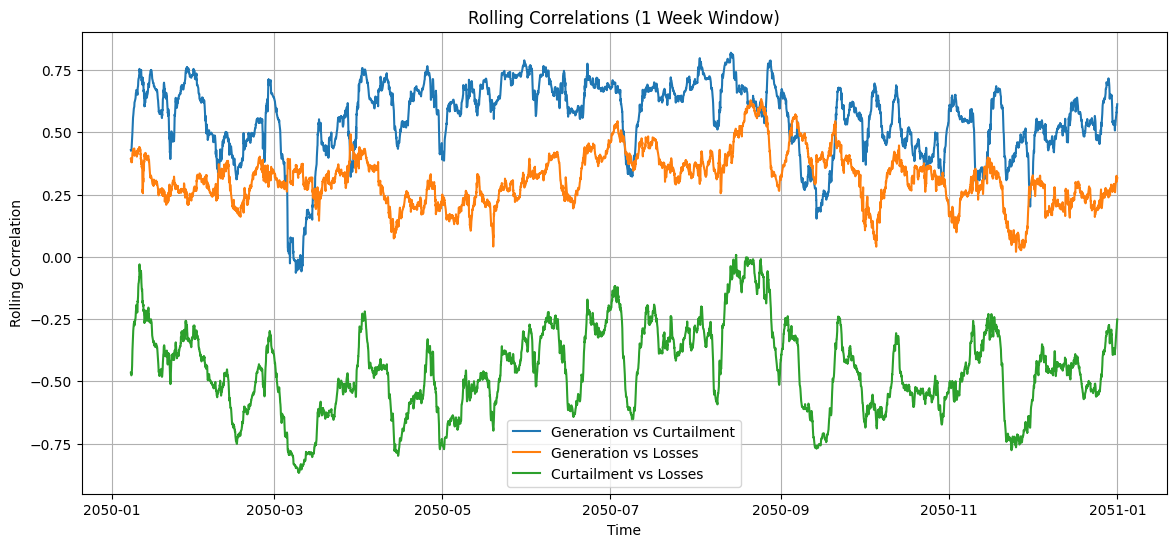

In [23]:
rolling_window = 24 * 7  # Example: 1 week window

rolling_corr_gen_cur = data['Generation'].rolling(rolling_window).corr(data['Curtailment'])
rolling_corr_gen_losses = data['Generation'].rolling(rolling_window).corr(data['Losses'])
rolling_corr_cur_losses = data['Curtailment'].rolling(rolling_window).corr(data['Losses'])

plt.figure(figsize=(14, 6))
plt.plot(rolling_corr_gen_cur, label='Generation vs Curtailment')
plt.plot(rolling_corr_gen_losses, label='Generation vs Losses')
plt.plot(rolling_corr_cur_losses, label='Curtailment vs Losses')
plt.xlabel('Time')
plt.ylabel('Rolling Correlation')
plt.title('Rolling Correlations (1 Week Window)')
plt.legend()
plt.grid(True)
plt.show()

In [62]:
# Combine into a DataFrame
data = pd.DataFrame({
    'Generation': total_hourly_gen.values,
    'Demand': total_hourly_load.values,
    'Transmission': total_hourly_p_trans.values,
    'Curtailment': total_hourly_cur.values

})

In [64]:
X = data[['Generation', 'Demand', 'Curtailment', 'Transmission']]
X = sm.add_constant(X)  # Adds a constant term to the predictor
# Calculate VIF
vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

        feature         VIF
0         const  271.377794
1    Generation   28.661975
2        Demand    8.624316
3   Curtailment   31.566090
4  Transmission   12.782260


In [61]:
# Prepare the data for regression
X = data[['Generation', 'Demand']]  # Independent variables
X = sm.add_constant(X)  # Adds a constant term to the predictor
y = data['Transmission']  # Dependent variable
z = data['Curtailment']  # Dependent variable

# Fit the regression model
model_trans = sm.OLS(y, X).fit()
model_cur = sm.OLS(z, X).fit()

# Print the regression results
print(f'DEMAND AND GENERATION TO TRANSMISSION')
print(model_trans.summary())
print(f'DEMAND AND GENERATION TO CURTAILMENT')
print(model_cur.summary())



DEMAND AND GENERATION TO TRANSMISSION
                            OLS Regression Results                            
Dep. Variable:           Transmission   R-squared:                       0.120
Model:                            OLS   Adj. R-squared:                  0.119
Method:                 Least Squares   F-statistic:                     594.4
Date:                Wed, 03 Jul 2024   Prob (F-statistic):          8.62e-243
Time:                        10:25:40   Log-Likelihood:            -1.5153e+05
No. Observations:                8760   AIC:                         3.031e+05
Df Residuals:                    8757   BIC:                         3.031e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.

Summary statistics of the hourly 'p_trans_rel_gen' data:
count    8760.000000
mean        1.496717
std         0.948654
min         0.439636
25%         0.956834
50%         1.178031
75%         1.534005
max        10.643679
dtype: float64

Outliers detected using Z-score method:
                     p_trans_rel_gen   z_score
snapshot                                      
2050-01-04 02:00:00         4.727294  3.405628
2050-01-10 03:00:00         4.517648  3.184623
2050-01-12 07:00:00         5.115218  3.814572
2050-01-12 21:00:00         4.351391  3.009357
2050-01-14 10:00:00         5.282560  3.990982
...                              ...       ...
2050-12-21 02:00:00         4.463837  3.127895
2050-12-22 07:00:00         5.134630  3.835036
2050-12-22 08:00:00         7.578994  6.411850
2050-12-23 12:00:00         4.587434  3.258190
2050-12-29 07:00:00         6.187087  4.944522

[215 rows x 2 columns]

Outliers detected using IQR method:
                     p_trans_rel_gen   z_score


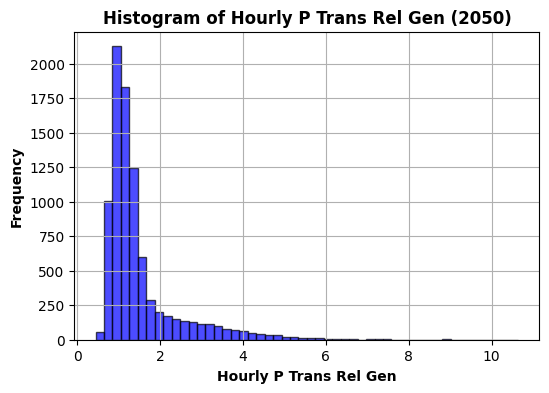

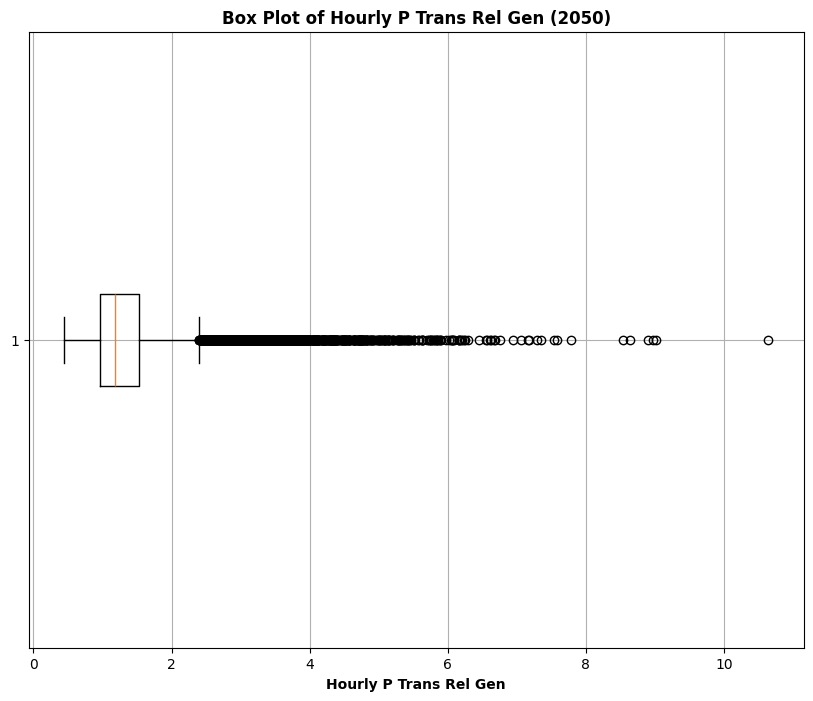

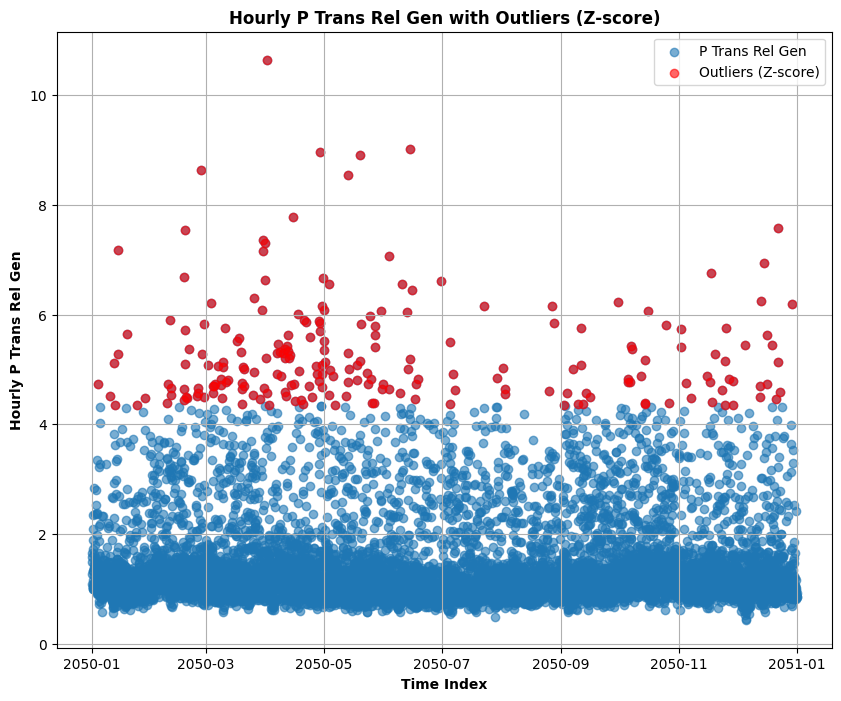

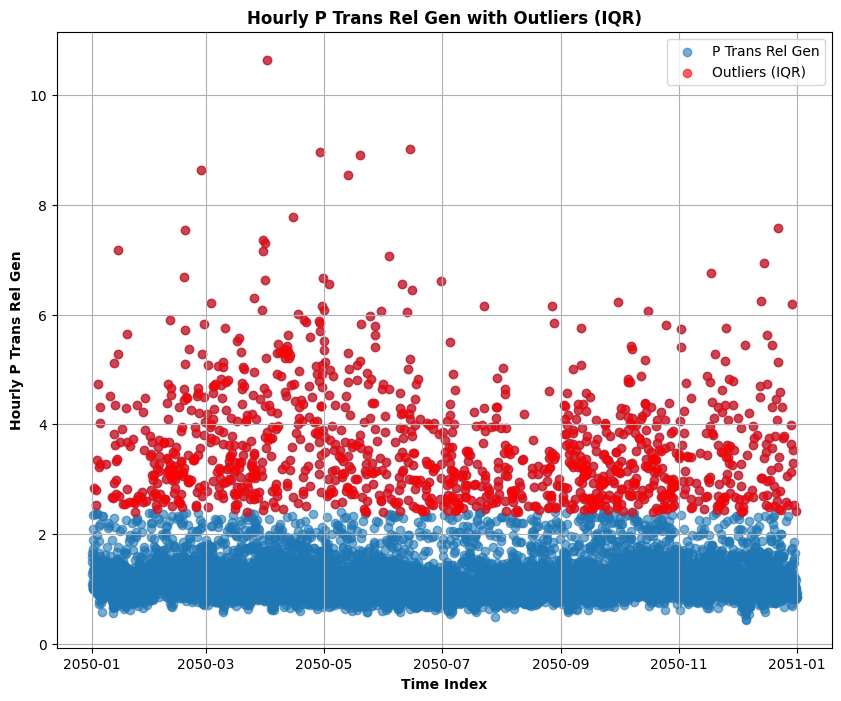

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import zscore

# Assuming `n` is your network data object
# If there are multiple columns, sum them up
hourly_p_trans_rel_gen_series =hourly_p_trans_rel_gen

# Step 2: Calculate Summary Statistics
print("Summary statistics of the hourly 'p_trans_rel_gen' data:")
print(hourly_p_trans_rel_gen_series.describe())

# Step 3: Identify Outliers

# Method 1: Z-Score Method
df = pd.DataFrame(hourly_p_trans_rel_gen_series, columns=['p_trans_rel_gen'])
df['z_score'] = zscore(df['p_trans_rel_gen'])
outliers_zscore = df[np.abs(df['z_score']) > 3]
print("\nOutliers detected using Z-score method:")
print(outliers_zscore)

# Method 2: IQR Method
Q1 = df['p_trans_rel_gen'].quantile(0.25)
Q3 = df['p_trans_rel_gen'].quantile(0.75)
IQR = Q3 - Q1
outliers_iqr = df[(df['p_trans_rel_gen'] < (Q1 - 1.5 * IQR)) | (df['p_trans_rel_gen'] > (Q3 + 1.5 * IQR))]
print("\nOutliers detected using IQR method:")
print(outliers_iqr)

# Step 4: Visualization

# Histogram
plt.figure(figsize=(6, 4))
plt.hist(hourly_p_trans_rel_gen_series, bins=50, color='blue', edgecolor='black', alpha=0.7)
plt.xlabel('Hourly P Trans Rel Gen', fontweight='bold')
plt.ylabel('Frequency', fontweight='bold')
plt.title('Histogram of Hourly P Trans Rel Gen (2050)', fontweight='bold')
plt.grid(True)
plt.show()

# Box Plot
plt.figure(figsize=(10, 8))
plt.boxplot(hourly_p_trans_rel_gen_series, vert=False)
plt.xlabel('Hourly P Trans Rel Gen', fontweight='bold')
plt.title('Box Plot of Hourly P Trans Rel Gen (2050)', fontweight='bold')
plt.grid(True)
plt.show()

# Scatter Plot of P Trans Rel Gen vs. Z-score
plt.figure(figsize=(10, 8))
plt.scatter(df.index, df['p_trans_rel_gen'], label='P Trans Rel Gen', alpha=0.6)
plt.scatter(outliers_zscore.index, outliers_zscore['p_trans_rel_gen'], color='red', label='Outliers (Z-score)', alpha=0.6)
plt.xlabel('Time Index', fontweight='bold')
plt.ylabel('Hourly P Trans Rel Gen', fontweight='bold')
plt.title('Hourly P Trans Rel Gen with Outliers (Z-score)', fontweight='bold')
plt.legend()
plt.grid(True)
plt.show()

# Scatter Plot of P Trans Rel Gen vs. IQR
plt.figure(figsize=(10, 8))
plt.scatter(df.index, df['p_trans_rel_gen'], label='P Trans Rel Gen', alpha=0.6)
plt.scatter(outliers_iqr.index, outliers_iqr['p_trans_rel_gen'], color='red', label='Outliers (IQR)', alpha=0.6)
plt.xlabel('Time Index', fontweight='bold')
plt.ylabel('Hourly P Trans Rel Gen', fontweight='bold')
plt.title('Hourly P Trans Rel Gen with Outliers (IQR)', fontweight='bold')
plt.legend()
plt.grid(True)
plt.show()


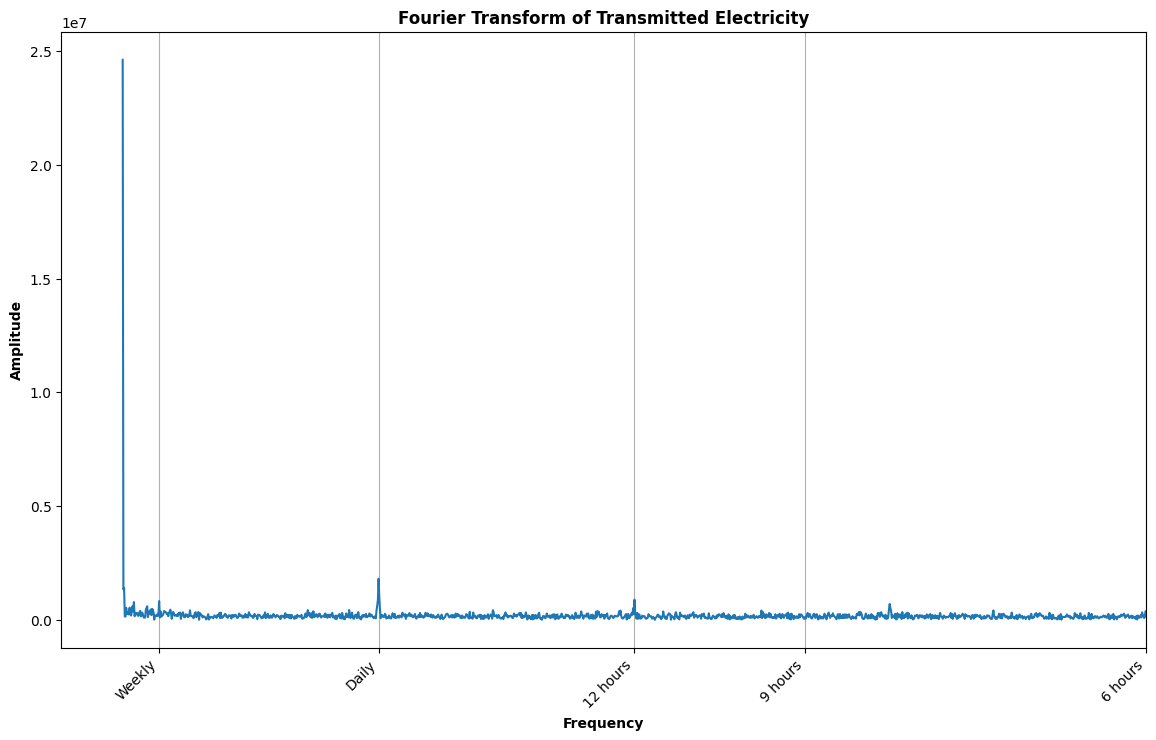

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
# Convert to numpy array
hourly_p_trans_rel_gen_array = total_hourly_p_trans.values

# Step 2: Perform Fourier Transform
# Number of sample points
N = len(hourly_p_trans_rel_gen_array)
# Sample spacing (assuming hourly data, so 1 hour)
T = 1.0

# Perform FFT
yf = fft(hourly_p_trans_rel_gen_array)
xf = fftfreq(N, T)[:N//2]
# Calculate the frequencies for 3-hour, 6-hour, 12-hour, daily, and weekly intervals
three_hour_freq = 1 / 3.0
six_hour_freq = 1 / 6.0
nine_hour_freq = 1 / 9.0
half_daily_freq = 1 / 12.0
daily_freq = 1 / 24.0
weekly_freq = 1 / (24.0 * 7)

frequencies = [three_hour_freq, six_hour_freq, nine_hour_freq,half_daily_freq, daily_freq, weekly_freq]
labels = ['3 hours', '6 hours', '9 hours', '12 hours', 'Daily', 'Weekly']
# Step 3: Plot the FFT results
fig, ax = plt.subplots(figsize=(14, 8))
ax.plot(xf, 2.0 / N * np.abs(yf[0:N // 2]))
# Set custom x-ticks and labels
ax.set_xticks(frequencies)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_xlim(-0.01, 1/6)

ax.set_xlabel('Frequency', fontweight='bold')
ax.set_ylabel('Amplitude', fontweight='bold')
ax.set_title(f'Fourier Transform of Transmitted Electricity', fontweight='bold')
ax.grid(True, axis='x')

plt.show()

In [27]:
total_hourly_p_trans.describe()

count    8.760000e+03
mean     1.231312e+07
std      8.387172e+06
min      3.398082e+06
25%      7.513475e+06
50%      9.587755e+06
75%      1.313377e+07
max      1.080407e+08
dtype: float64

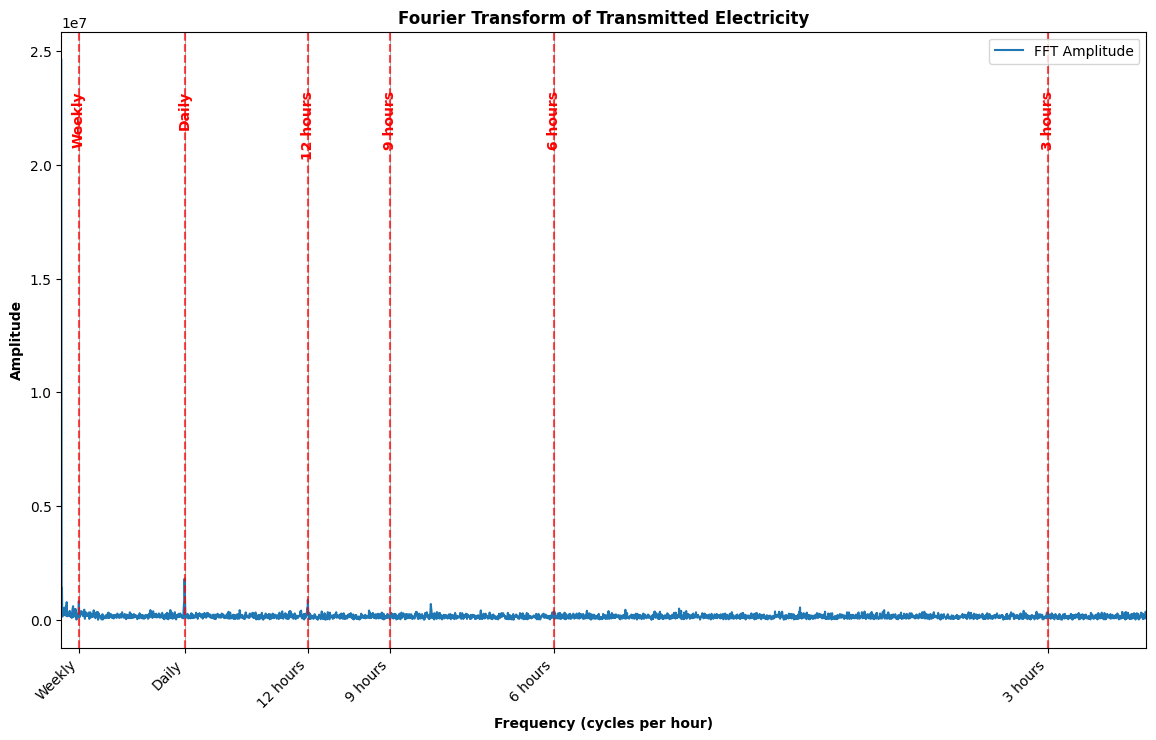

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq

# Convert to numpy array
hourly_p_trans_rel_gen_array = total_hourly_p_trans.values

# Perform Fourier Transform
N = len(hourly_p_trans_rel_gen_array)  # Number of sample points
T = 1.0  # Sample spacing (assuming hourly data, so 1 hour)

# Perform FFT
yf = fft(hourly_p_trans_rel_gen_array)
xf = fftfreq(N, T)[:N//2]

# Calculate the frequencies for 3-hour, 6-hour, 9-hour, 12-hour, daily, and weekly intervals
three_hour_freq = 1 / 3.0
six_hour_freq = 1 / 6.0
nine_hour_freq = 1 / 9.0
half_daily_freq = 1 / 12.0
daily_freq = 1 / 24.0
weekly_freq = 1 / (24.0 * 7)

frequencies = [three_hour_freq, six_hour_freq, nine_hour_freq, half_daily_freq, daily_freq, weekly_freq]
labels = ['3 hours', '6 hours', '9 hours', '12 hours', 'Daily', 'Weekly']

# Plot the FFT results
fig, ax = plt.subplots(figsize=(14, 8))
ax.plot(xf, 2.0 / N * np.abs(yf[0:N // 2]), label='FFT Amplitude')

# Highlight specific frequencies
for freq, label in zip(frequencies, labels):
    ax.axvline(x=freq, color='r', linestyle='--', alpha=0.7)
    ax.text(freq, ax.get_ylim()[1] * 0.9, label, color='r', ha='center', va='top', rotation=90, fontweight='bold')

# Set custom x-ticks and labels
ax.set_xticks(frequencies)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_xlim(0, max(frequencies)*1.1)  # Focus on relevant frequencies

# Add labels and title
ax.set_xlabel('Frequency (cycles per hour)', fontweight='bold')
ax.set_ylabel('Amplitude', fontweight='bold')
ax.set_title(f'Fourier Transform of Transmitted Electricity', fontweight='bold')

# Add grid and legend
ax.grid(True, axis='x')
ax.legend()

# Show plot
plt.show()

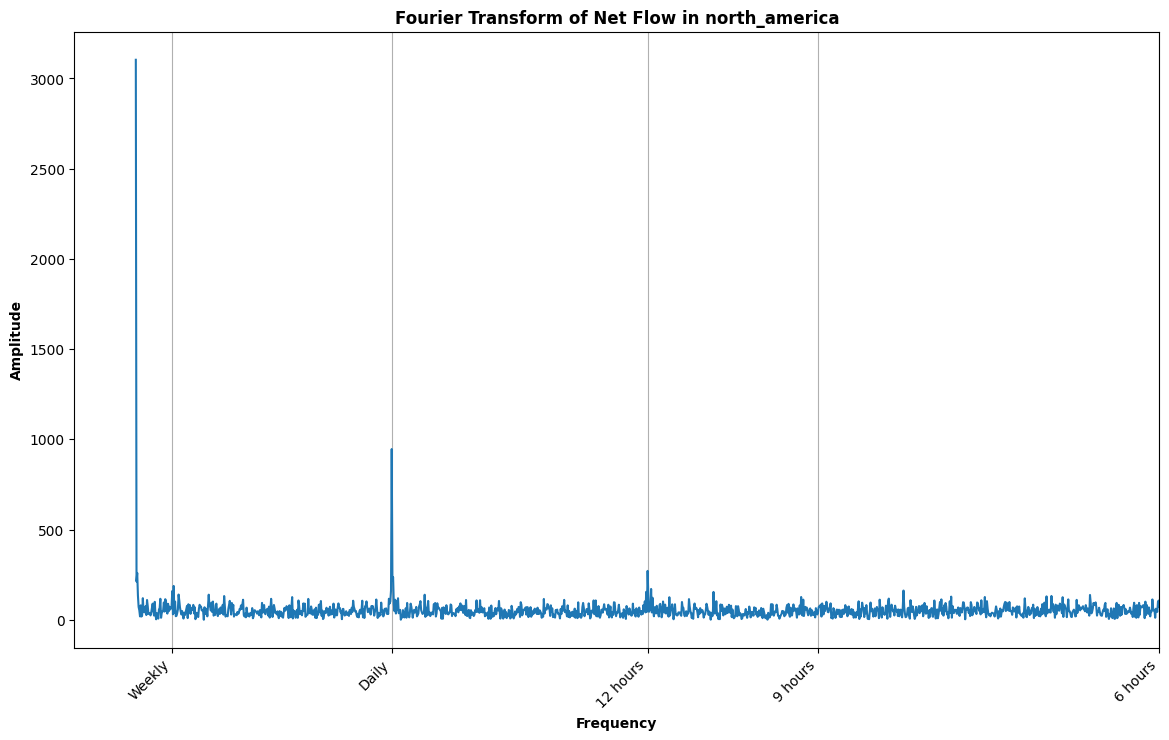

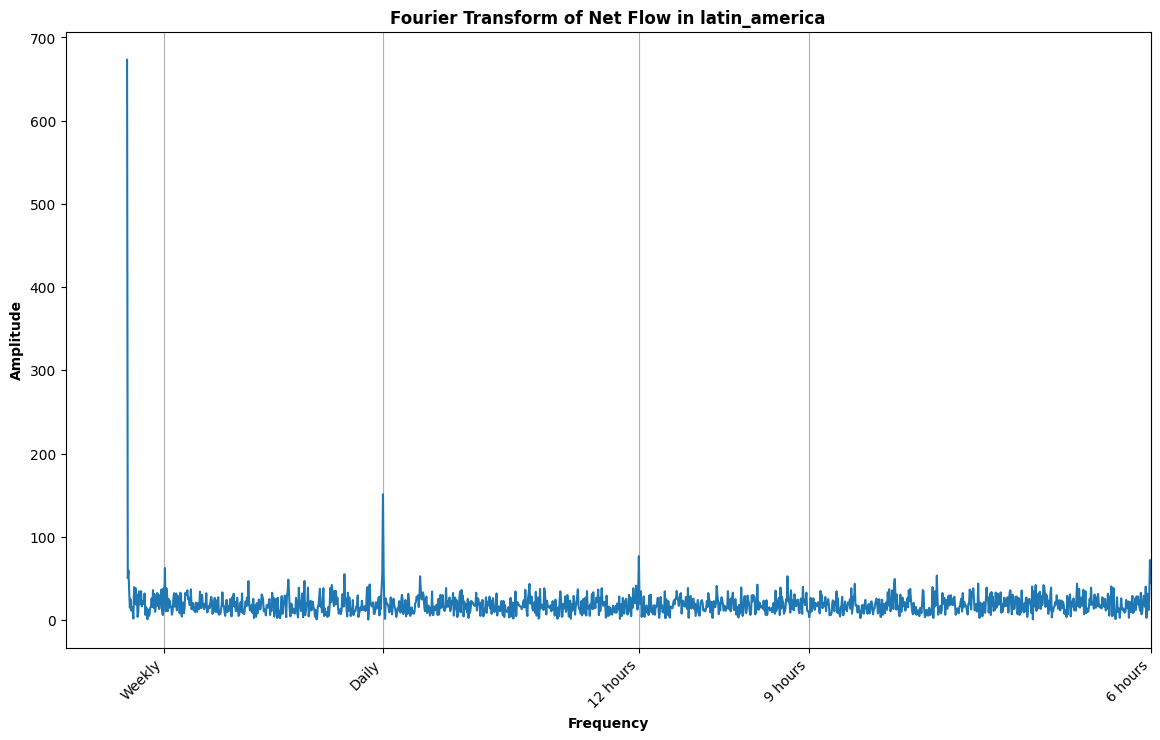

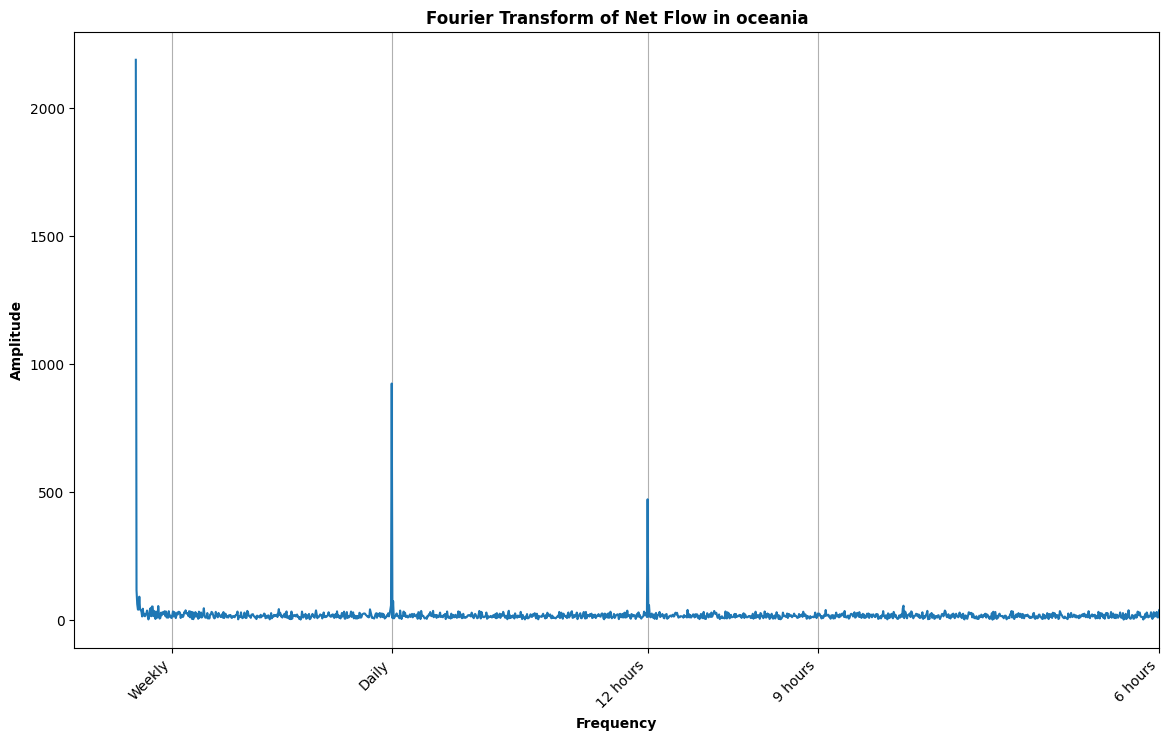

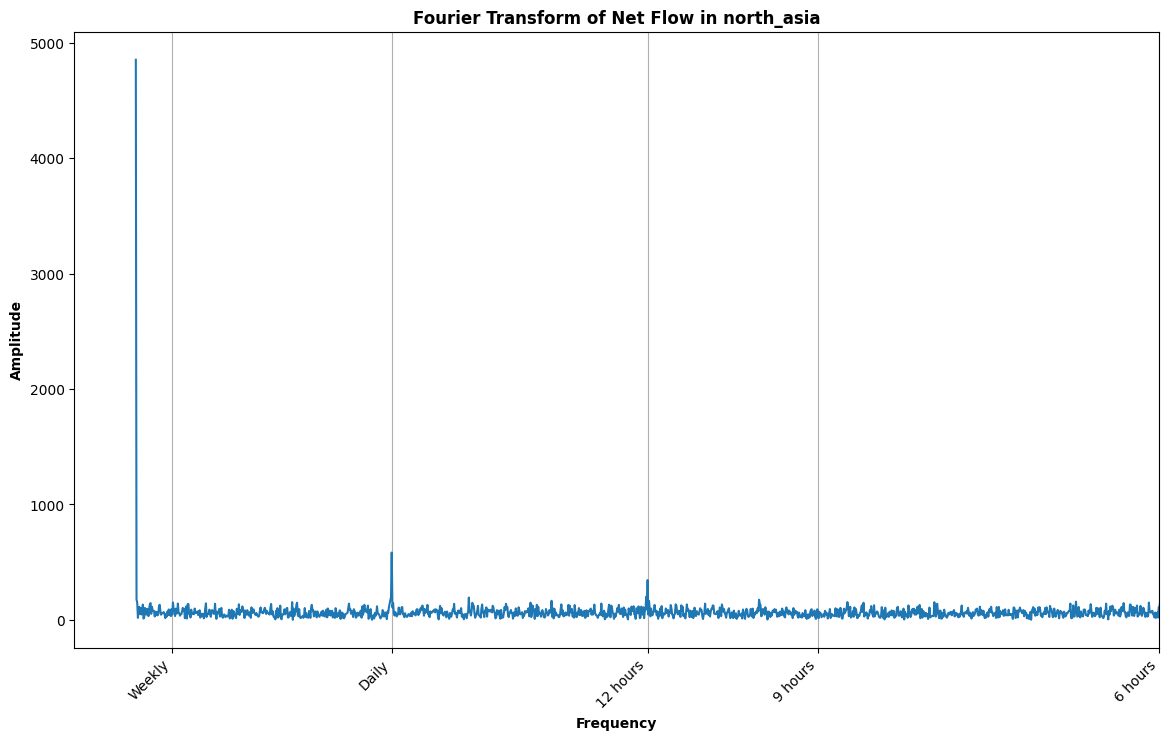

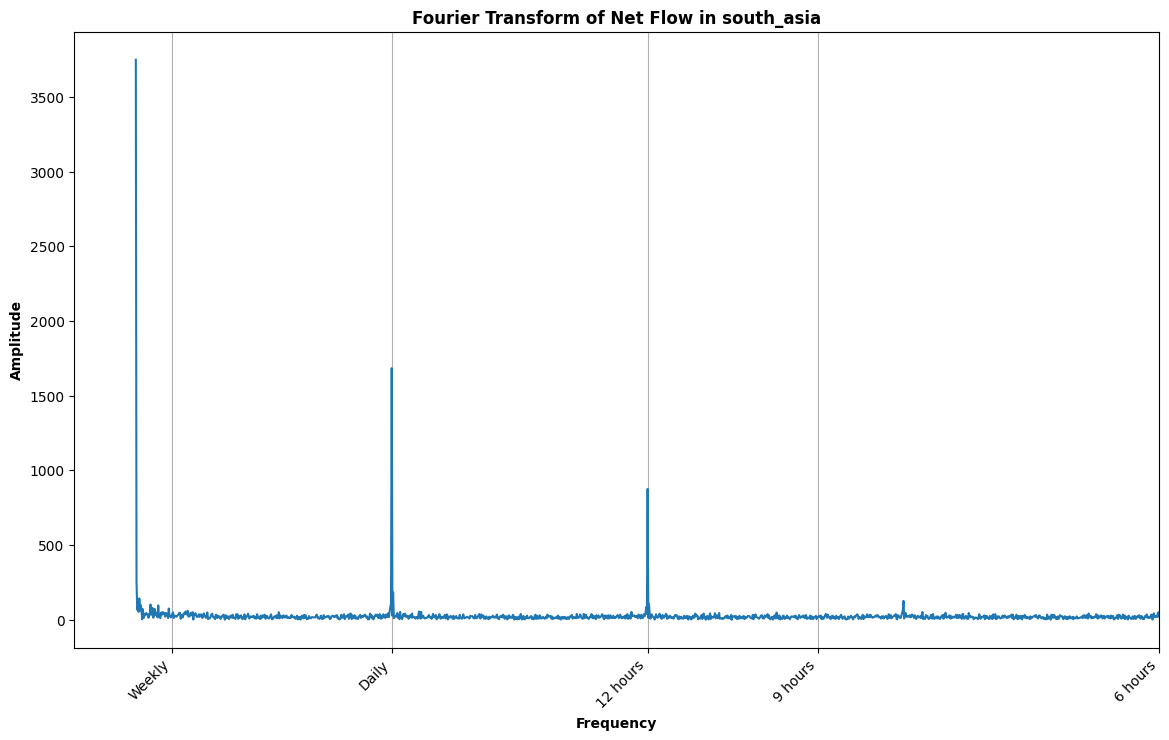

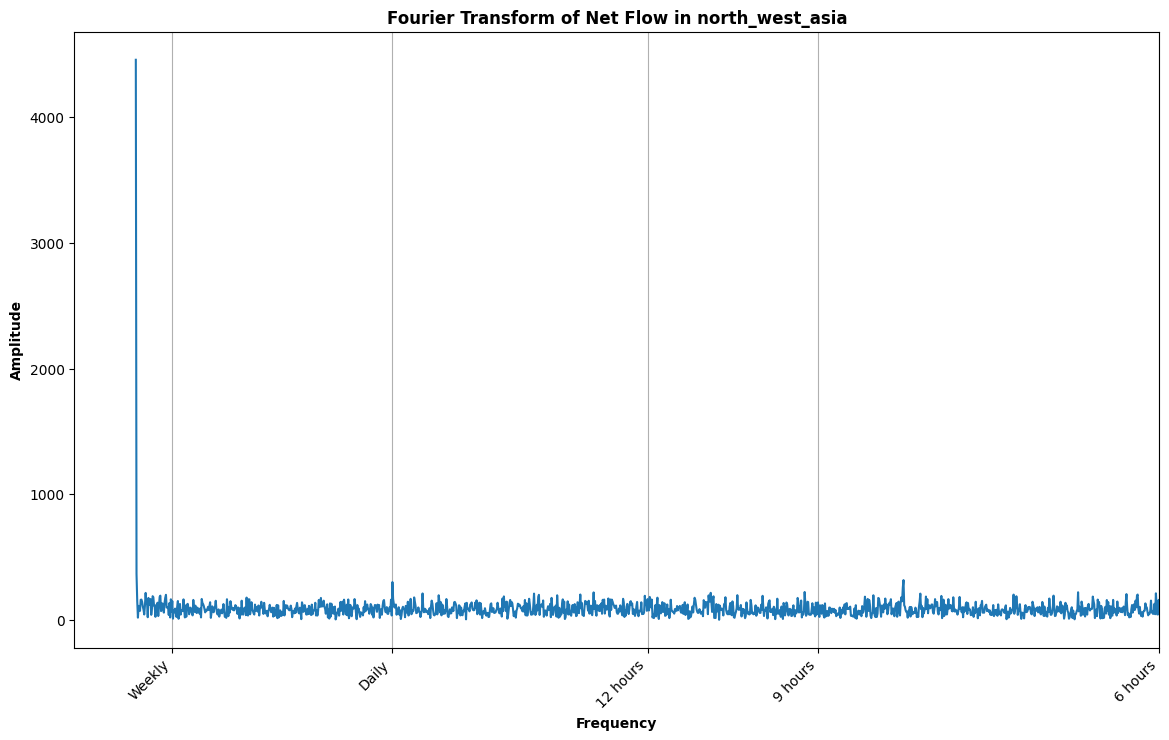

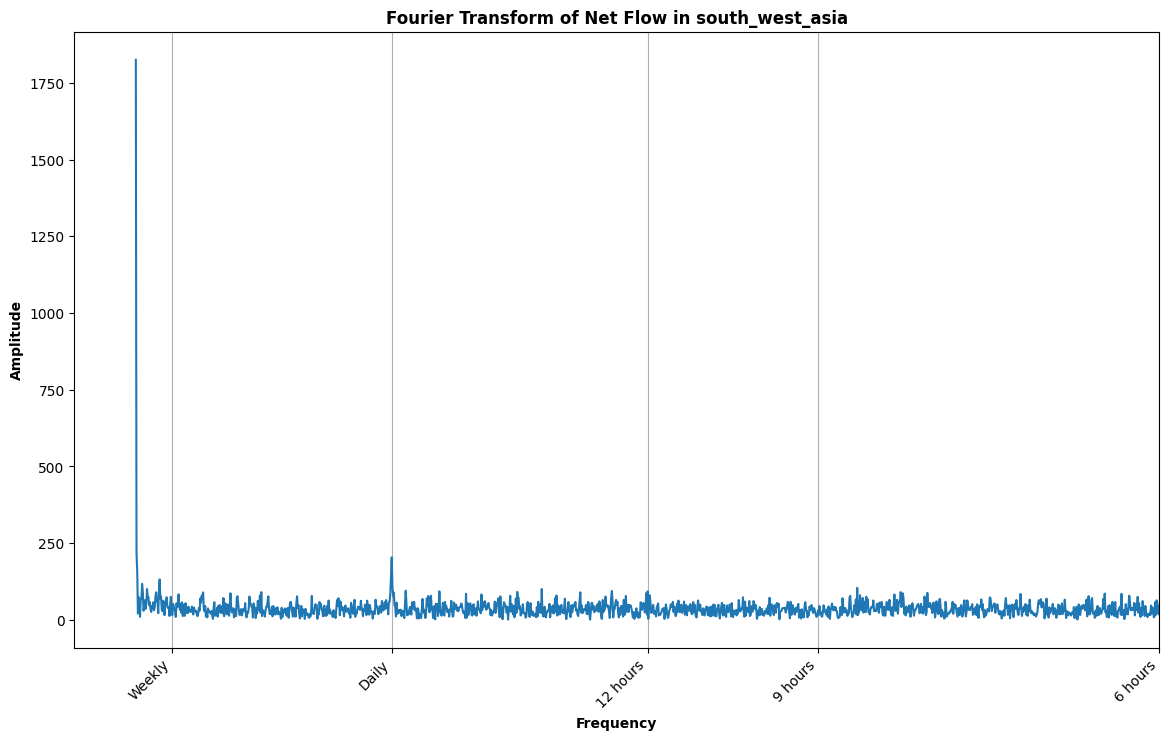

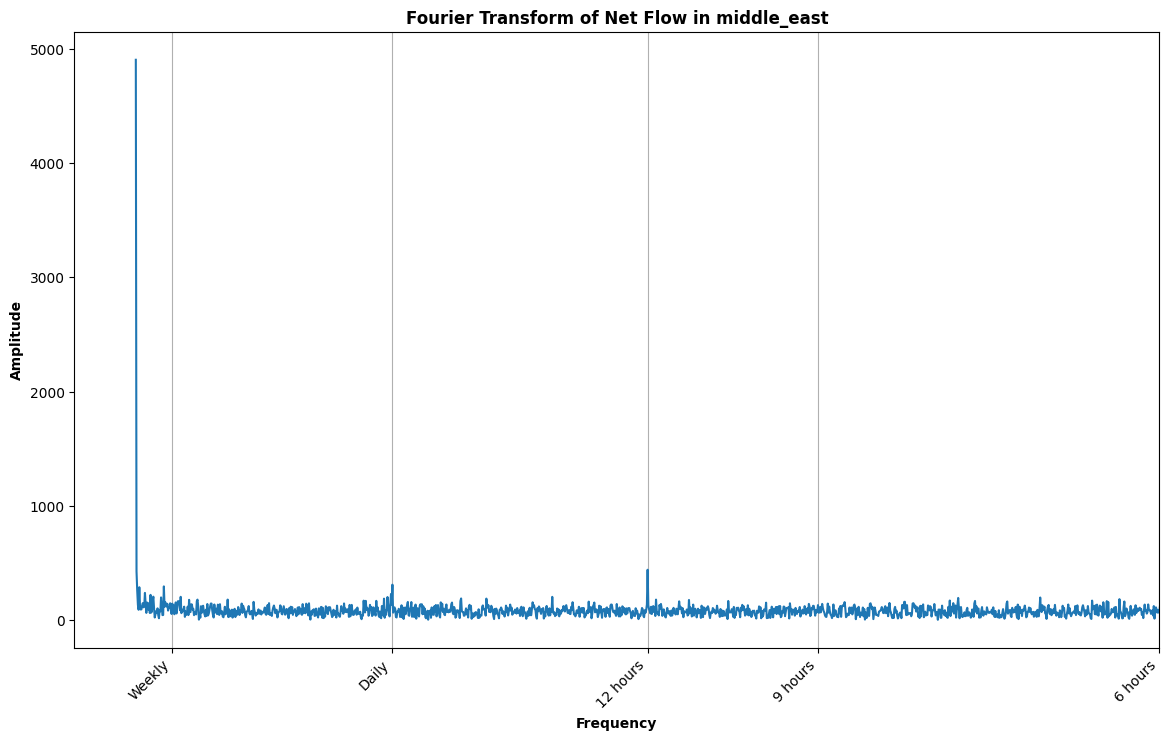

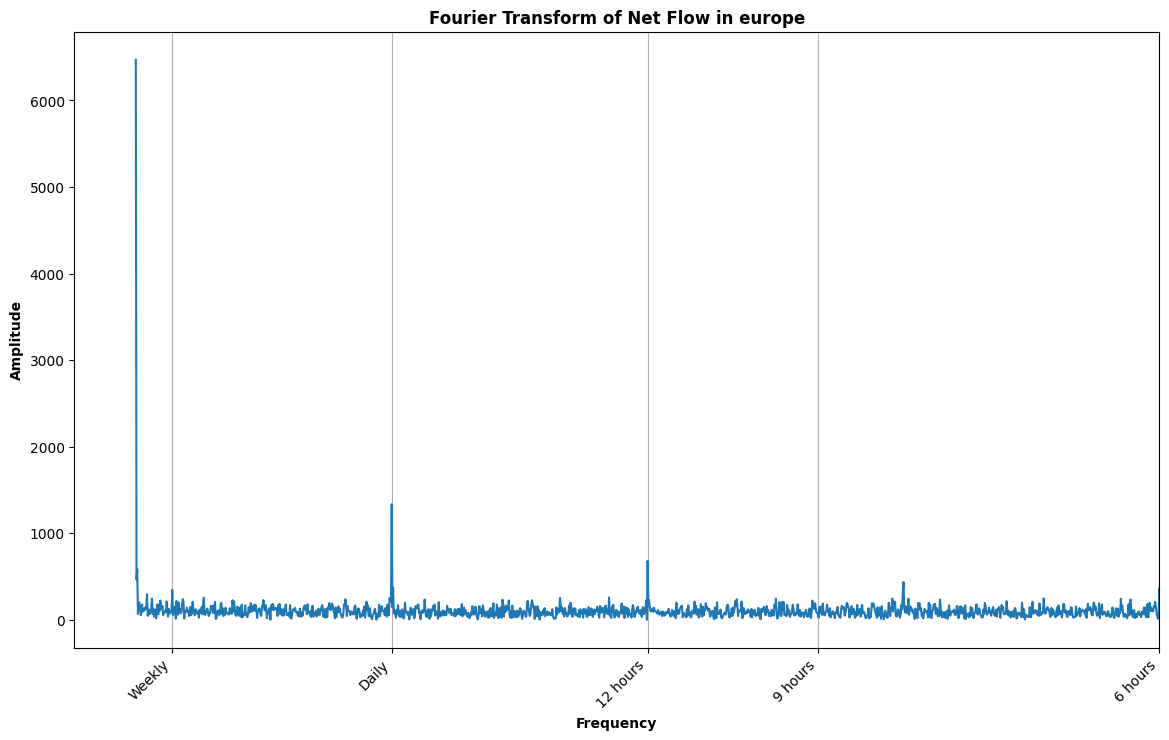

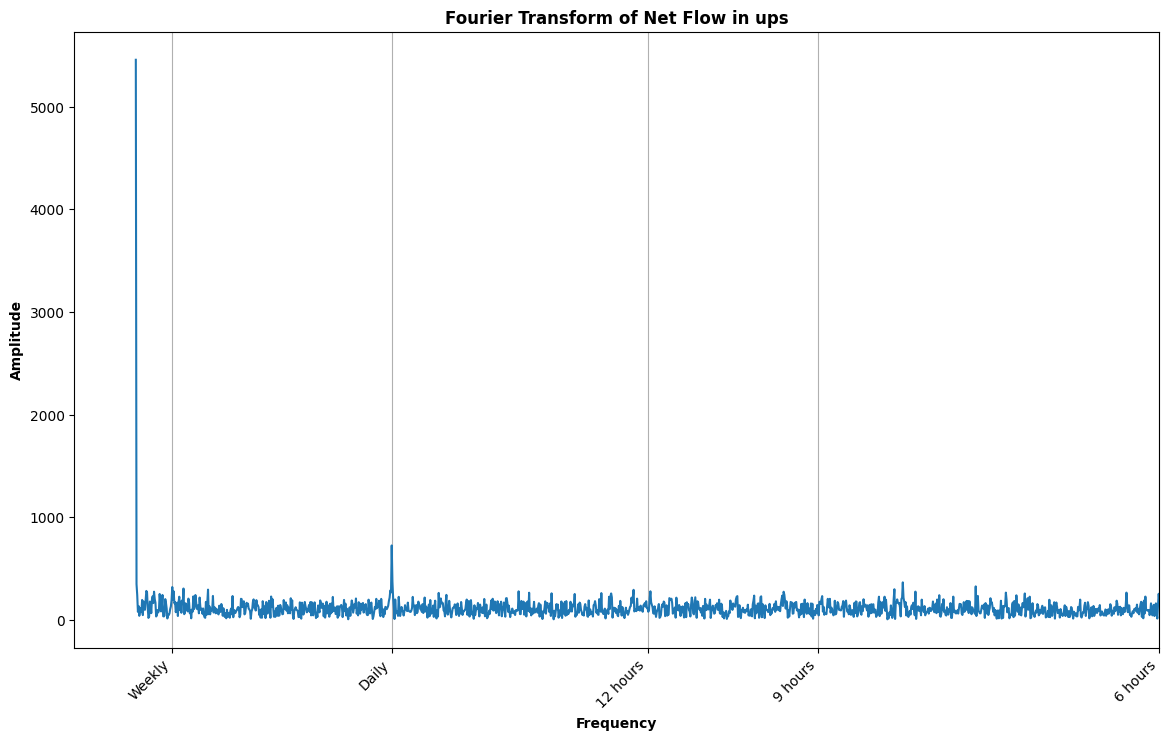

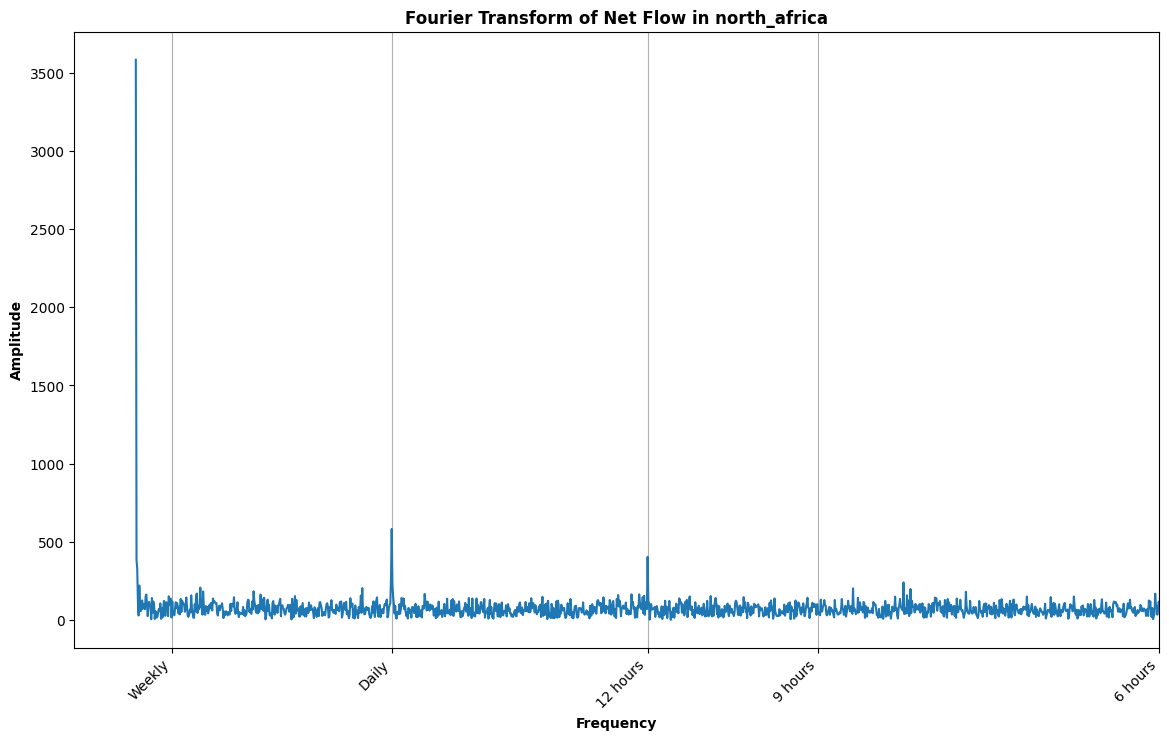

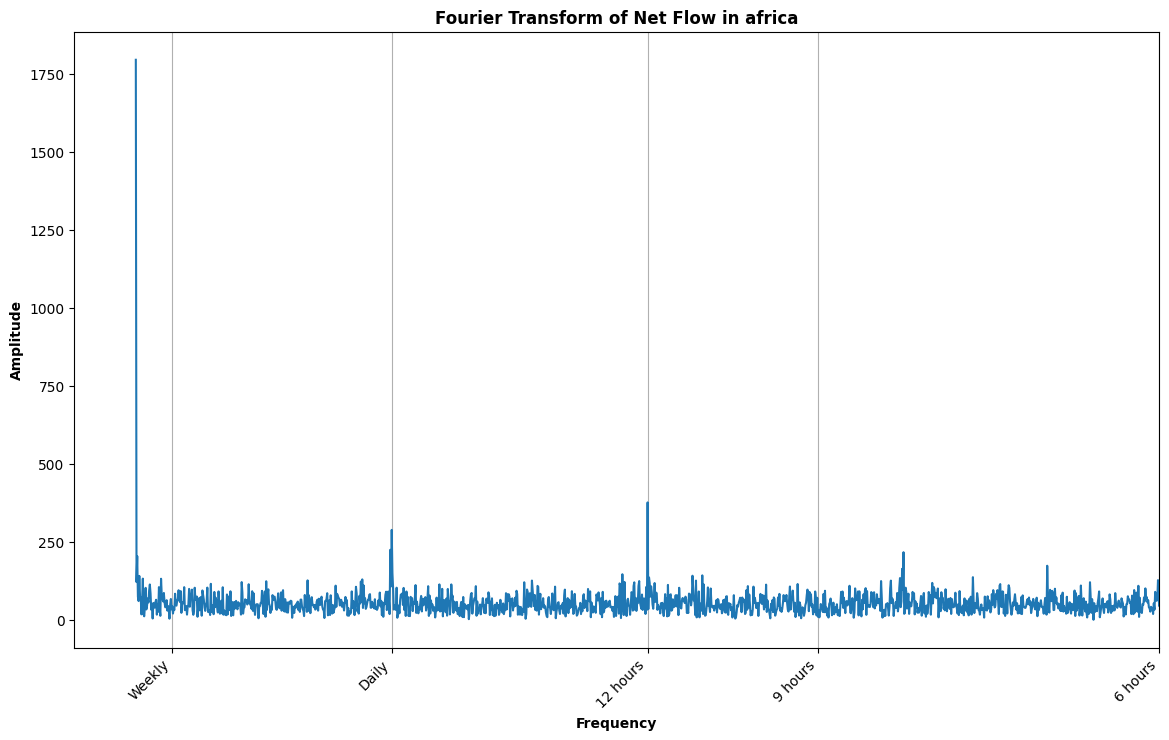

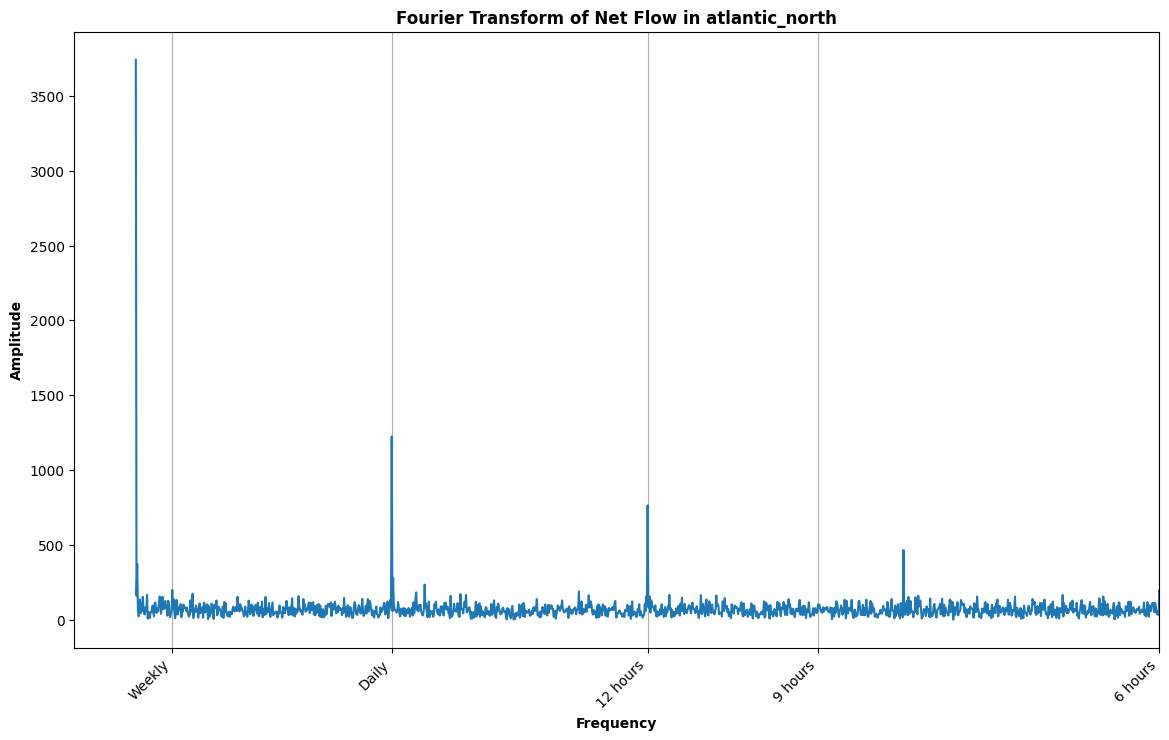

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq

# Assuming regions_dic is defined
for region_key, region_value in regions_dic.items():
    series = region_value["actualflow"]
    N = len(series)
    T = 1.0  # Sampling interval is 1 hour
    yf = fft(series)
    xf = fftfreq(N, T)[:N // 2]
    
    # Calculate the frequencies for 3-hour, 6-hour, 12-hour, daily, and weekly intervals
    three_hour_freq = 1 / 3.0
    six_hour_freq = 1 / 6.0
    nine_hour_freq = 1 / 9.0
    half_daily_freq = 1 / 12.0
    daily_freq = 1 / 24.0
    weekly_freq = 1 / (24.0 * 7)
    
    frequencies = [three_hour_freq, six_hour_freq, nine_hour_freq,half_daily_freq, daily_freq, weekly_freq]
    labels = ['3 hours', '6 hours', '9 hours', '12 hours', 'Daily', 'Weekly']
    
    fig, ax = plt.subplots(figsize=(14, 8))
    ax.plot(xf, 2.0 / N * np.abs(yf[0:N // 2]))
    
    # Set custom x-ticks and labels
    ax.set_xticks(frequencies)
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.set_xlim(-0.01, 1/6)
    
    ax.set_xlabel('Frequency', fontweight='bold')
    ax.set_ylabel('Amplitude', fontweight='bold')
    ax.set_title(f'Fourier Transform of Net Flow in {region_key}', fontweight='bold')
    ax.grid(True, axis='x')
    
    plt.show()


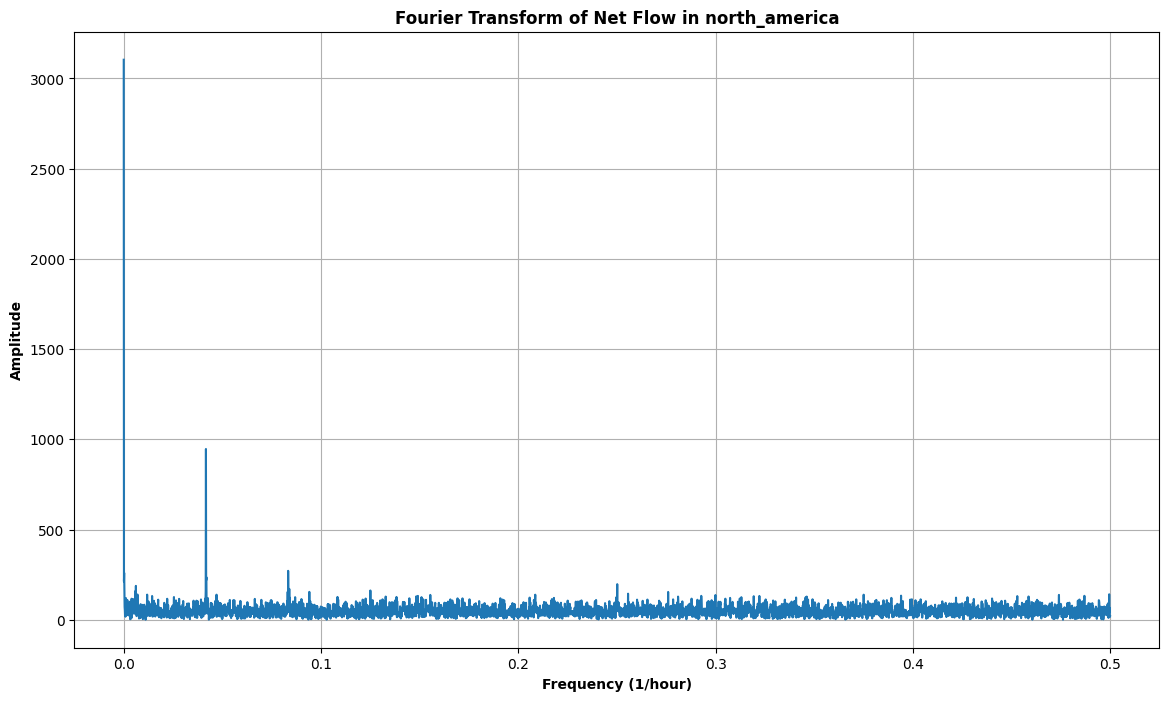

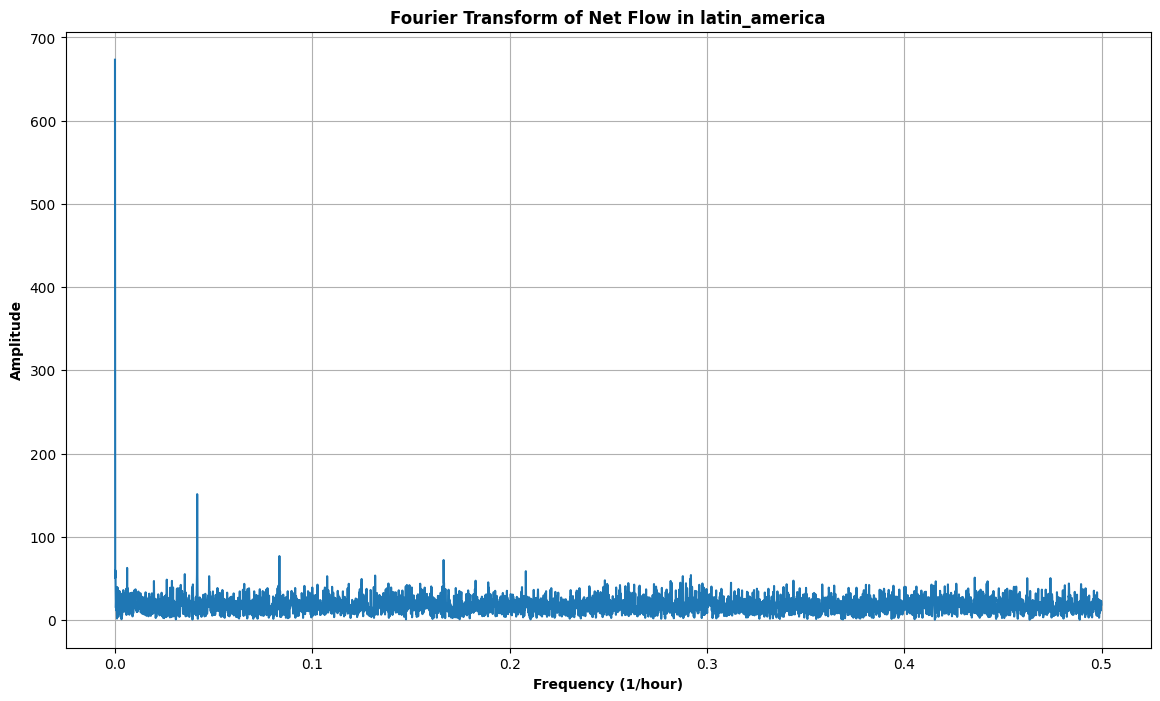

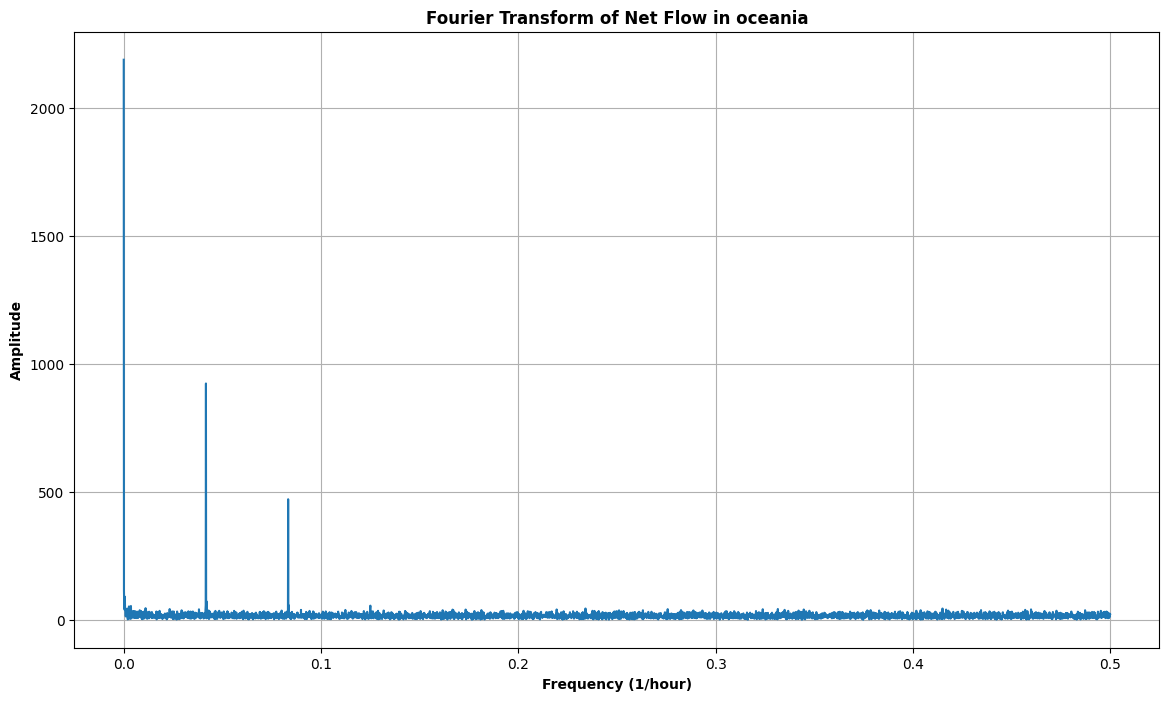

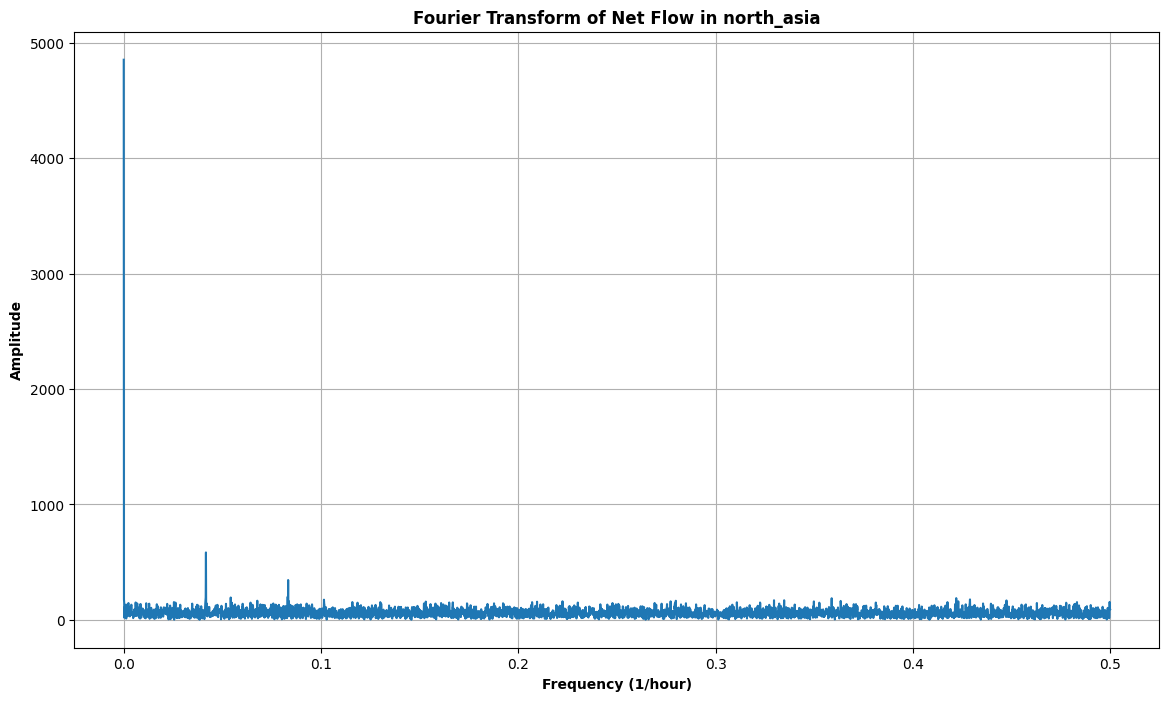

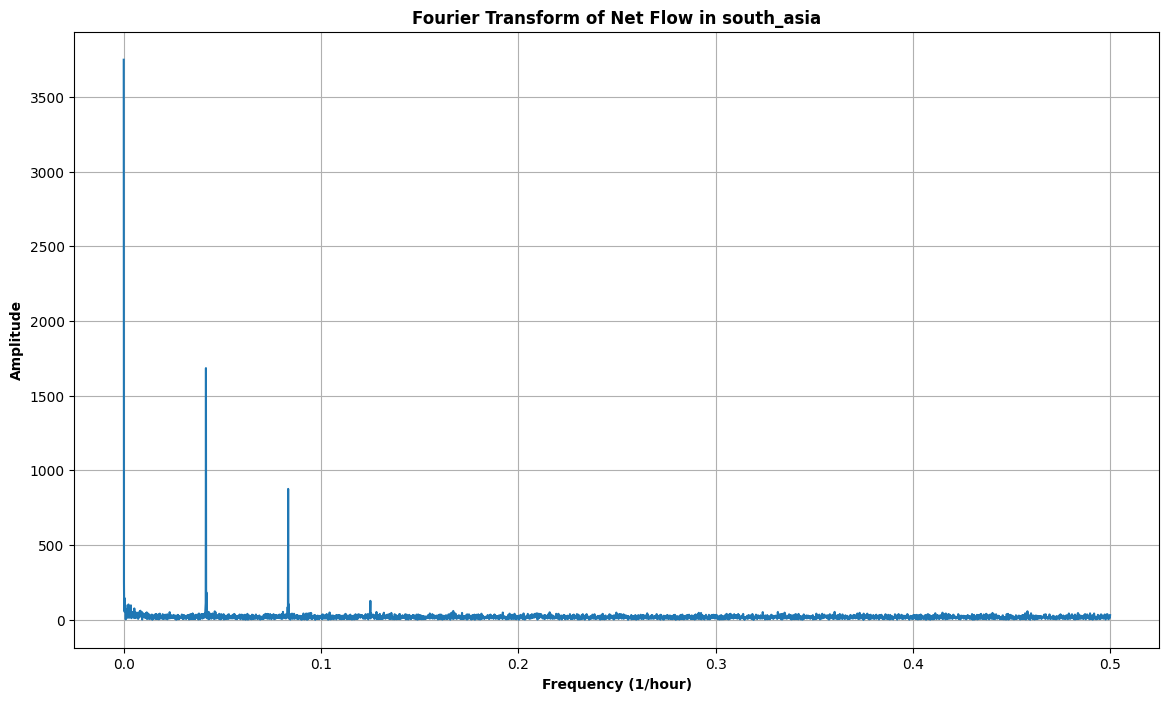

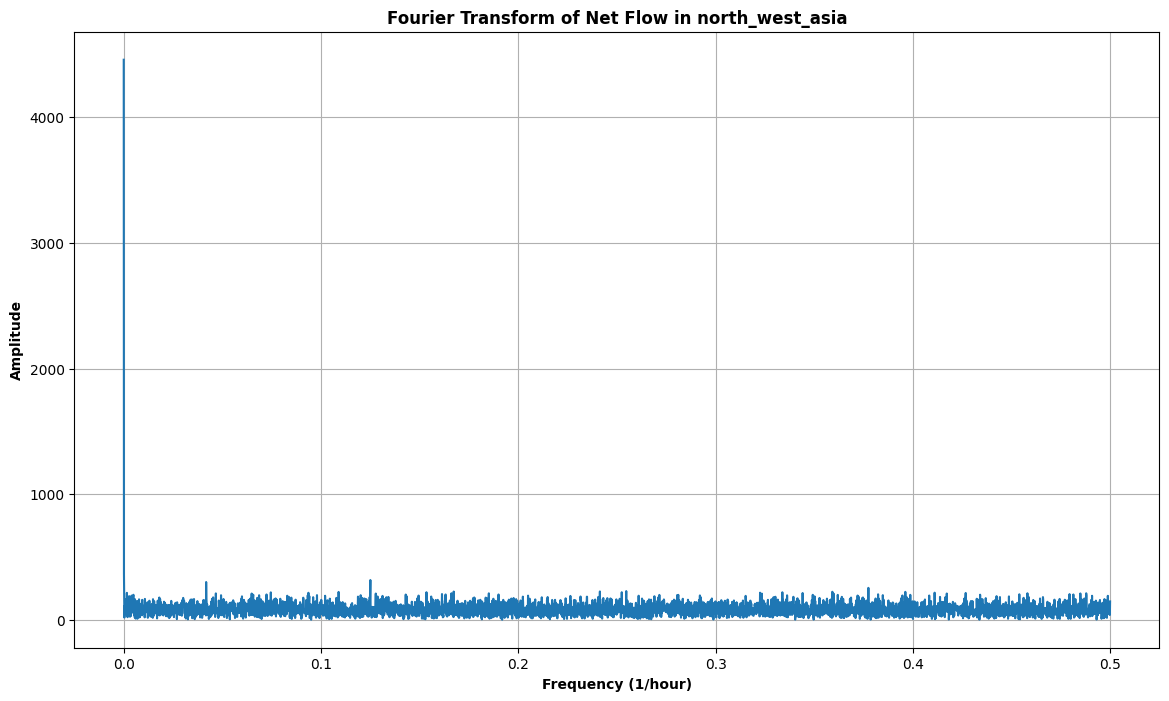

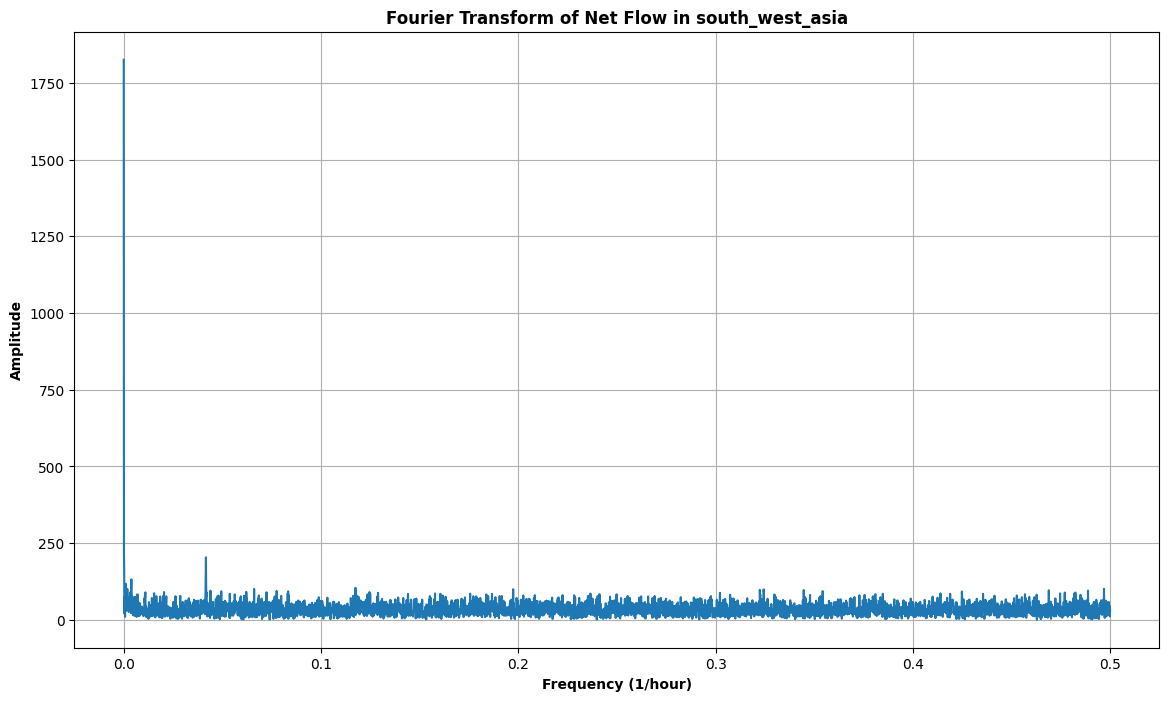

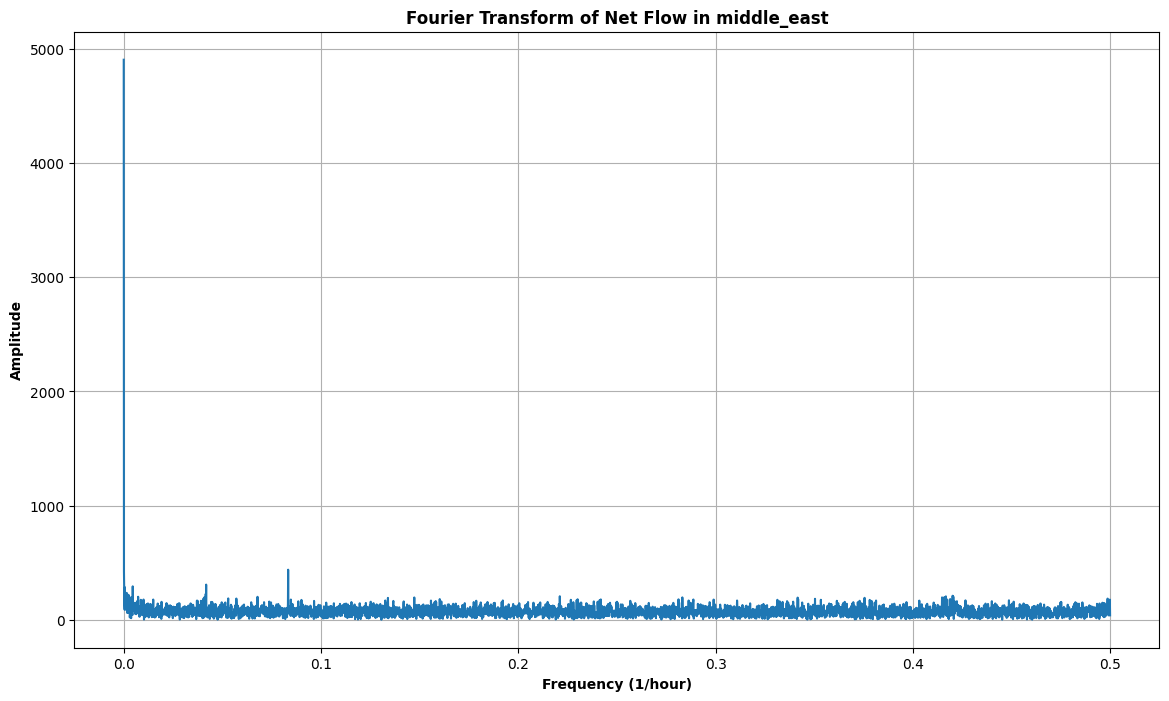

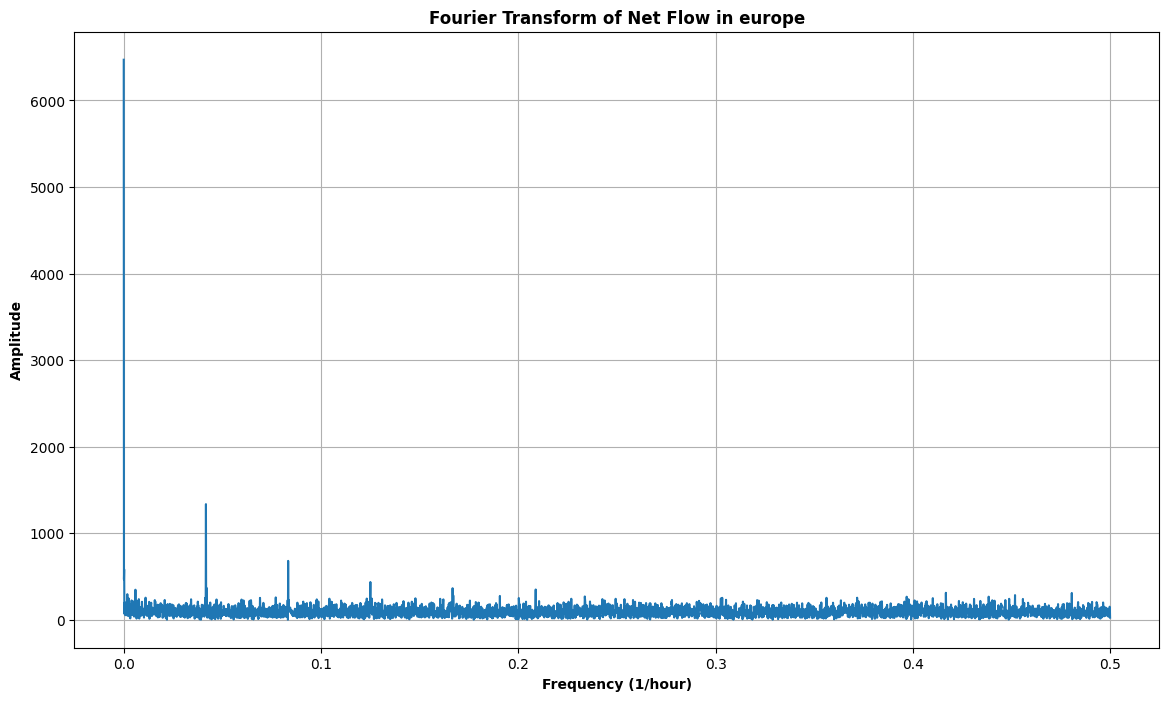

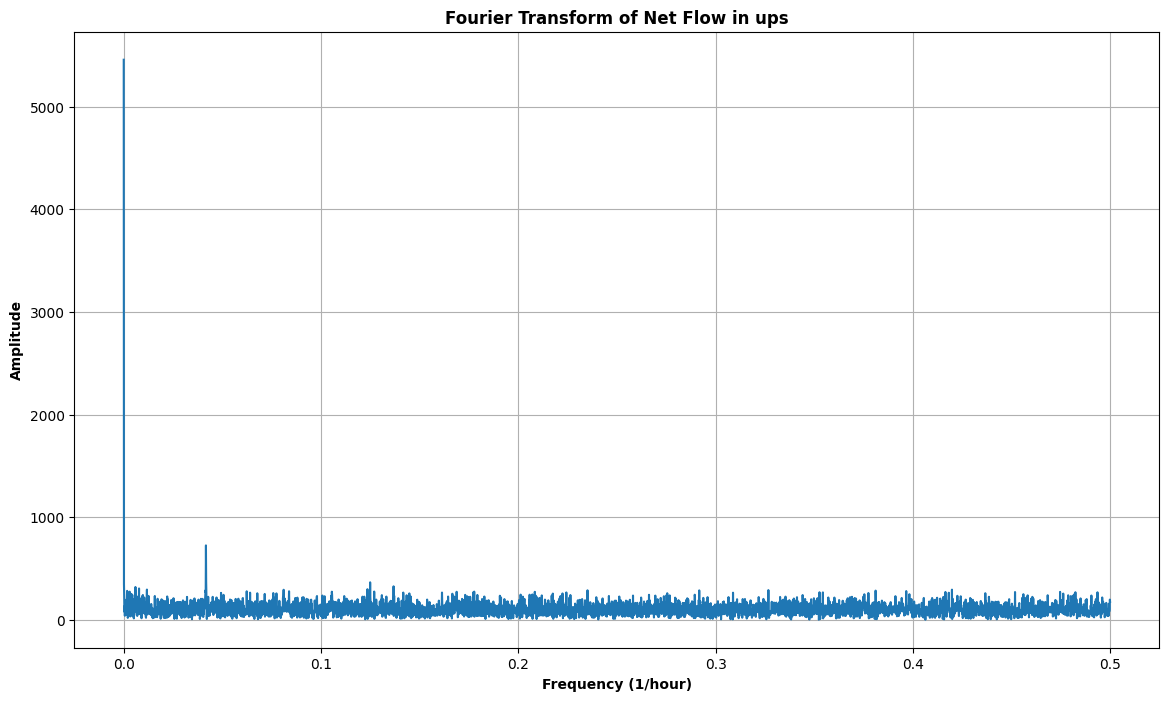

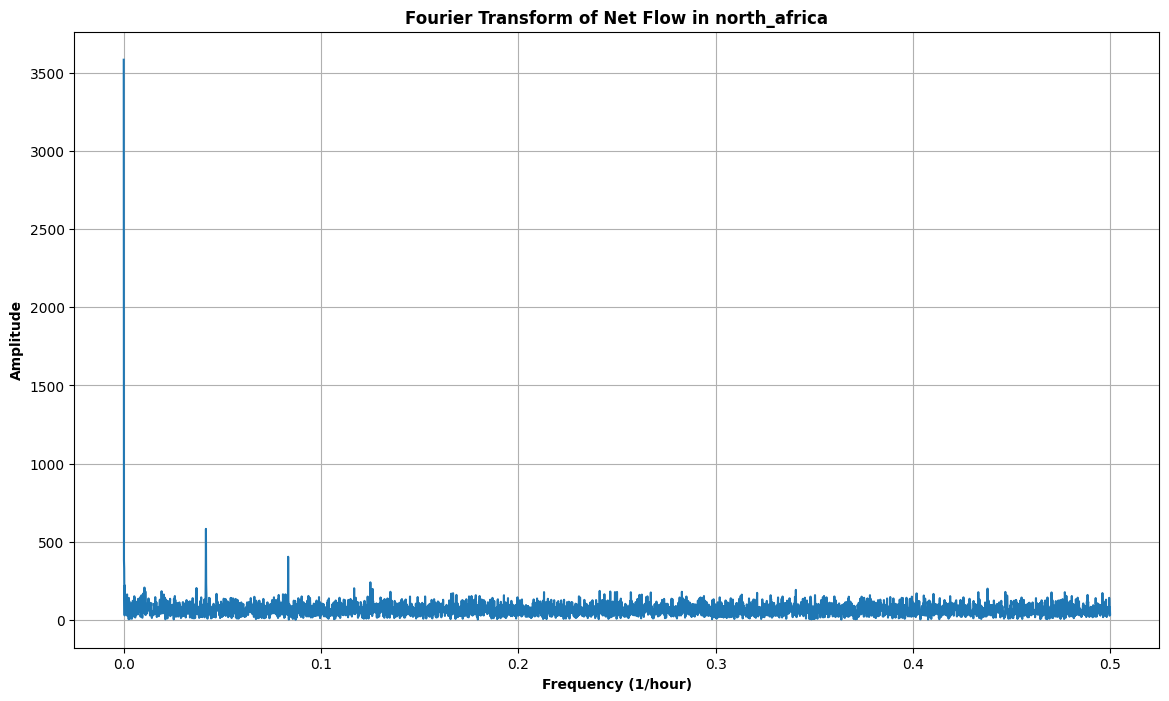

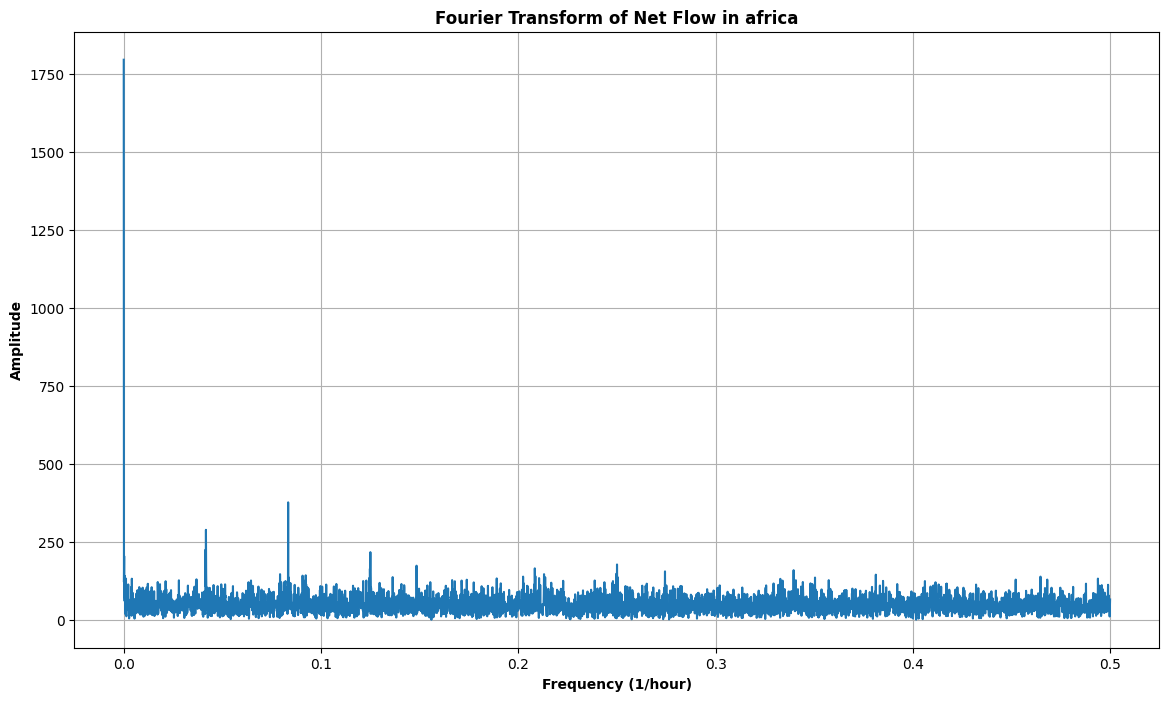

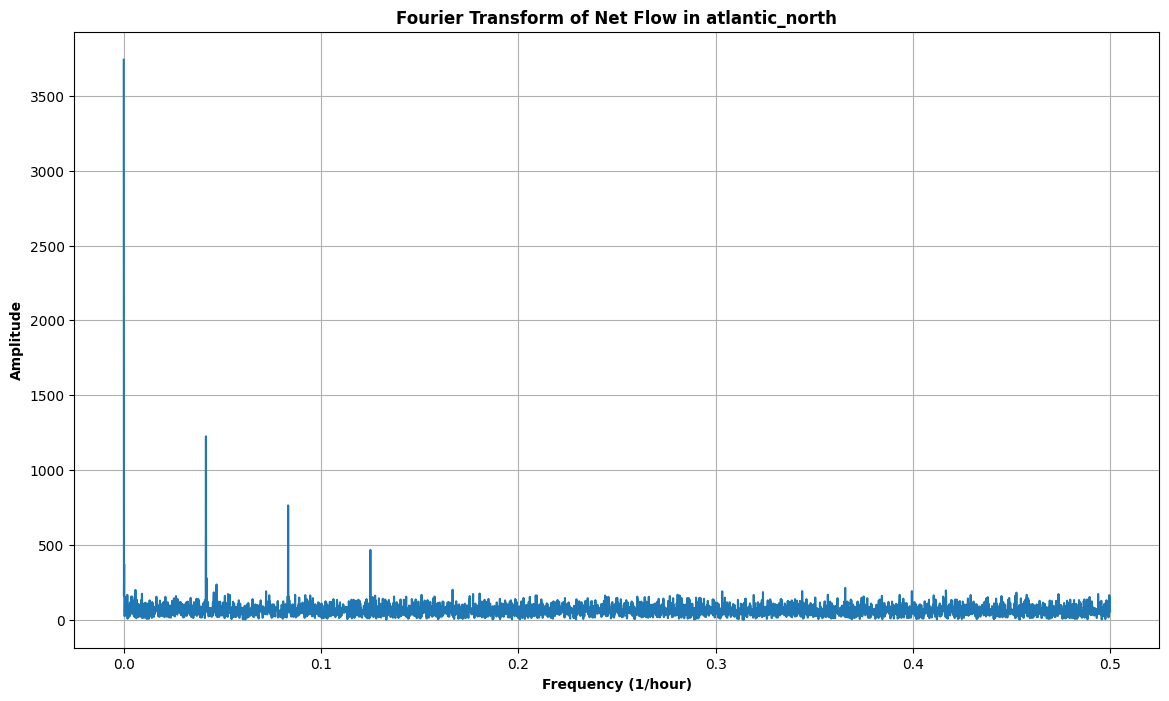

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq

daily_freq = 1 / 24.0
weekly_freq = 1 / (24.0 * 7)
monthly_freq = 1 / (24.0 * 30)
quarterly_freq = 1 / (24.0 * 90)

for region_key, region_value in regions_dic.items():
    series = region_value["actualflow"]
    N = len(series)
    T = 1.0
    yf = fft(series)
    xf = fftfreq(N, T)[:N//2]
    plt.figure(figsize=(14, 8))
    plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
    # Add vertical lines
    plt.grid()

    
    plt.xlabel('Frequency (1/hour)', fontweight='bold')
    plt.ylabel('Amplitude', fontweight='bold')
    plt.title(f'Fourier Transform of Net Flow in {region_key}', fontweight='bold')
    plt.show()

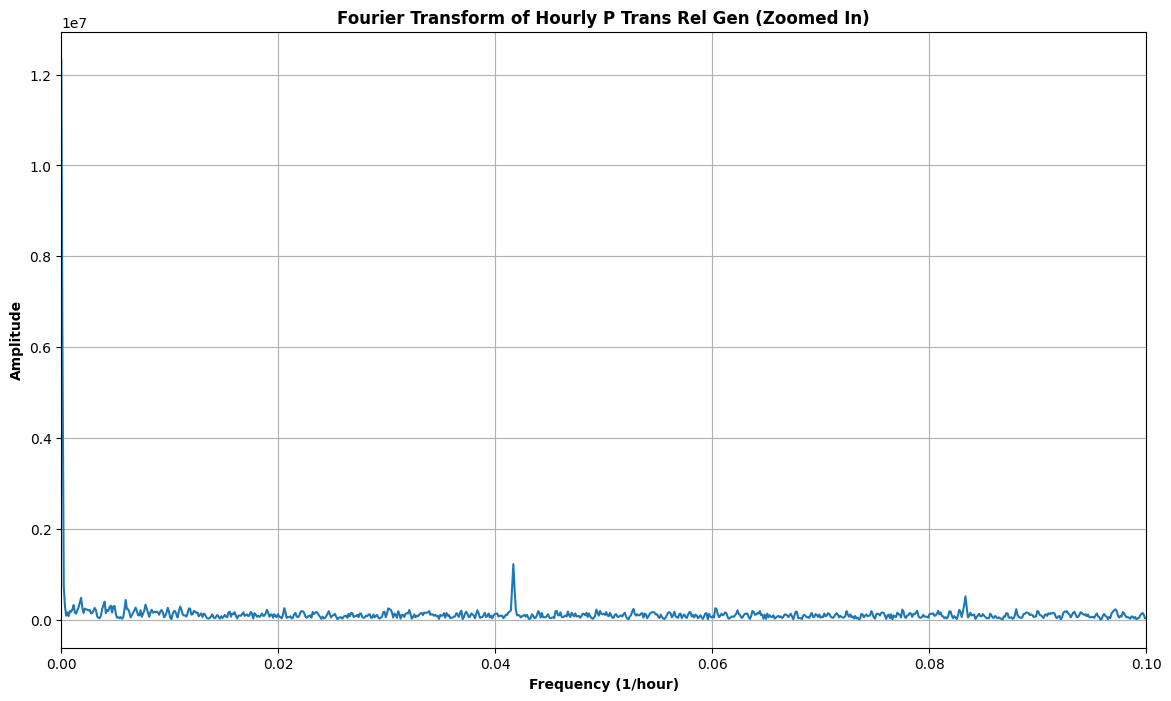

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy.signal import windows

# Convert to numpy array
hourly_p_trans_rel_gen_array = total_hourly_p_trans.values

# Step 2: Apply windowing
window = windows.hann(len(hourly_p_trans_rel_gen_array))
windowed_data = hourly_p_trans_rel_gen_array * window

# Step 3: Perform Fourier Transform
N = len(windowed_data)
T = 1.0  # Sample spacing (assuming hourly data, so 1 hour)

yf = fft(windowed_data)
xf = fftfreq(N, T)[:N//2]

# Step 4: Plot the FFT results (zoomed in)
plt.figure(figsize=(14, 8))
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.xlim(0, 0.1)  # Adjust this range based on where you expect to see peaks
plt.grid()
plt.xlabel('Frequency (1/hour)', fontweight='bold')
plt.ylabel('Amplitude', fontweight='bold')
plt.title('Fourier Transform of Hourly P Trans Rel Gen (Zoomed In)', fontweight='bold')
plt.show()


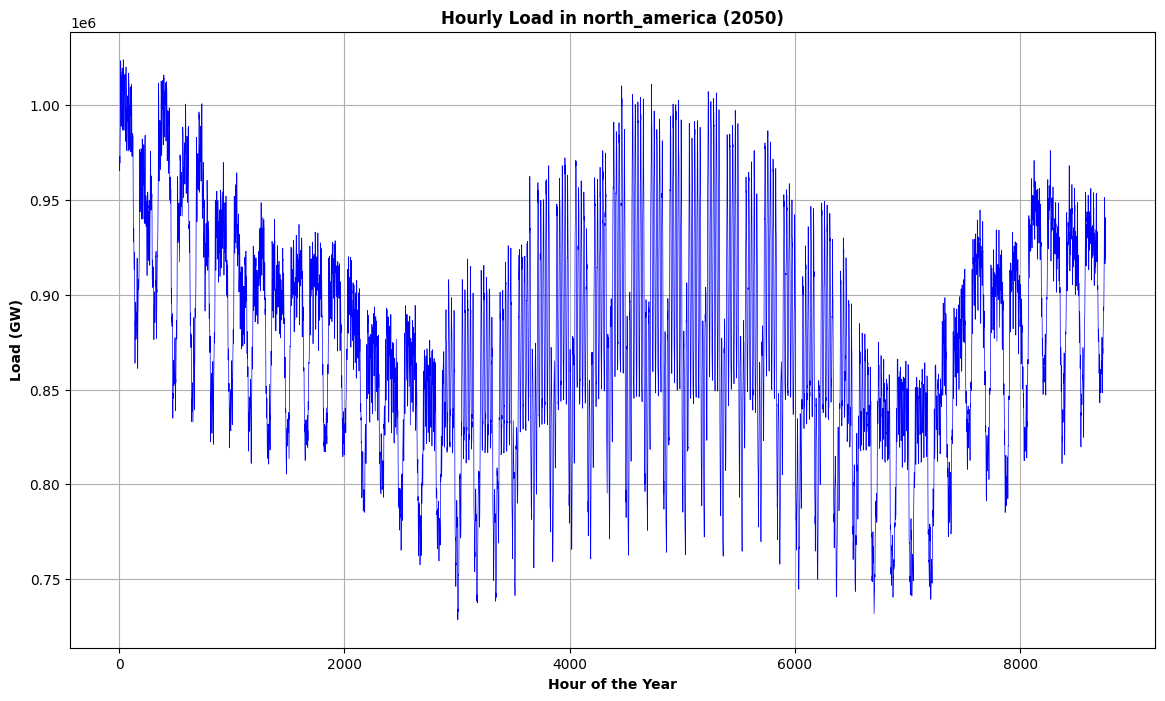

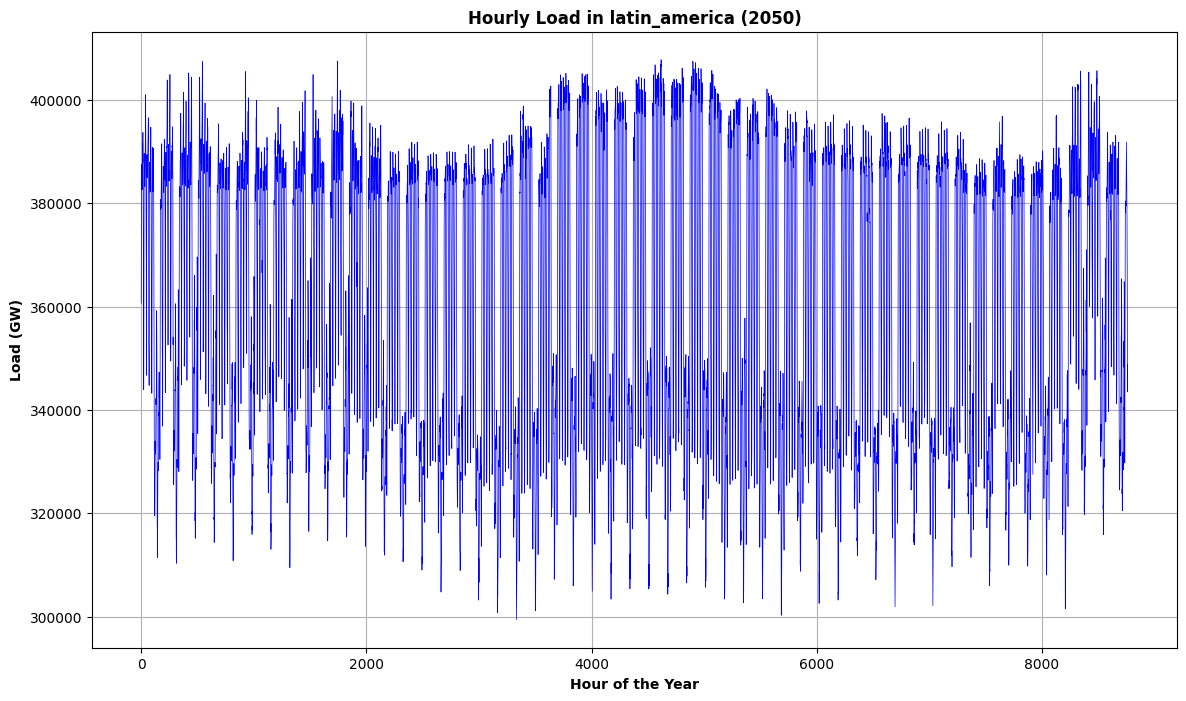

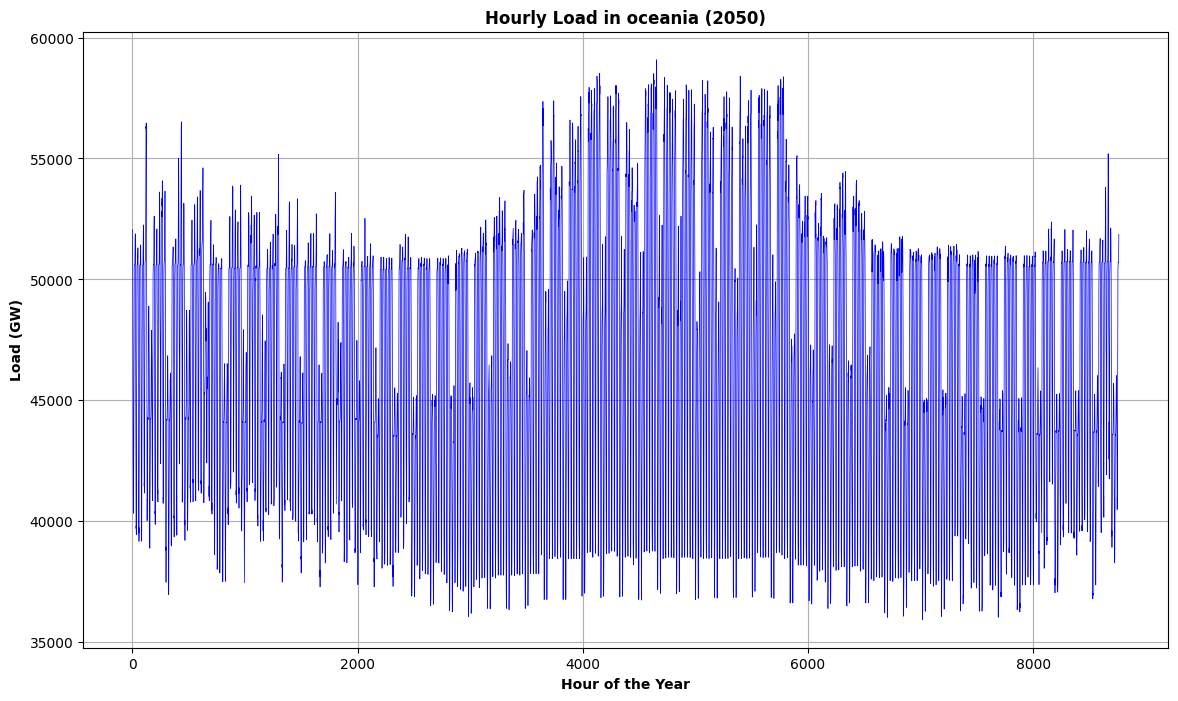

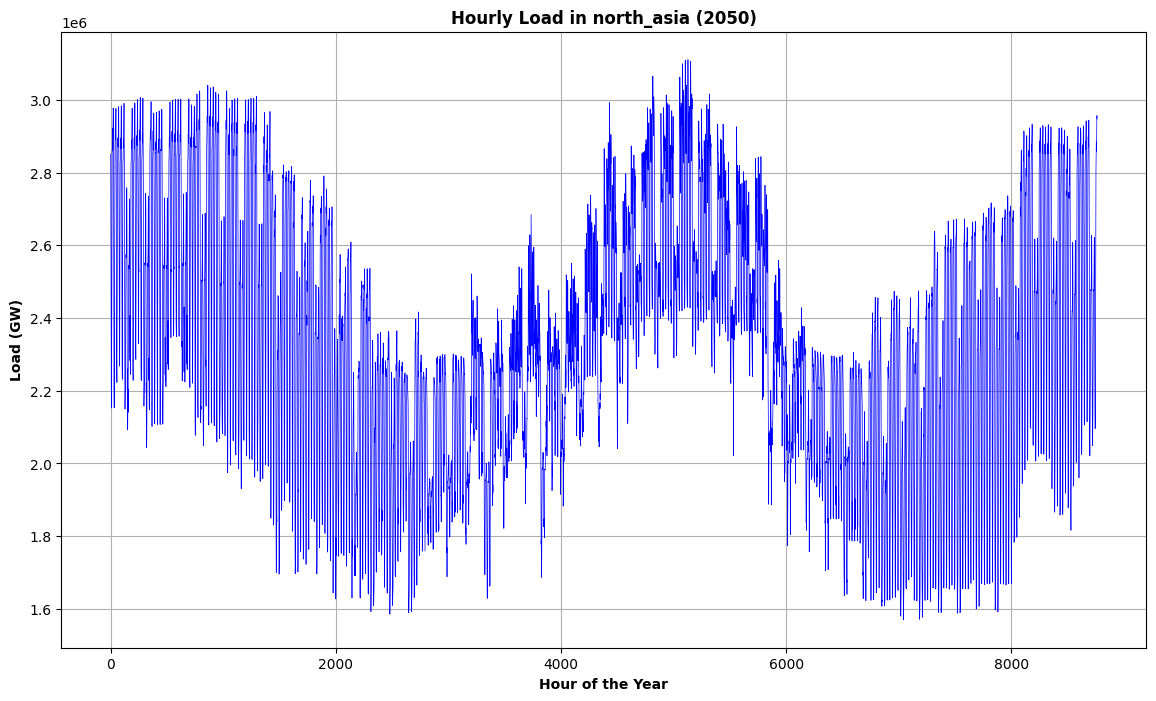

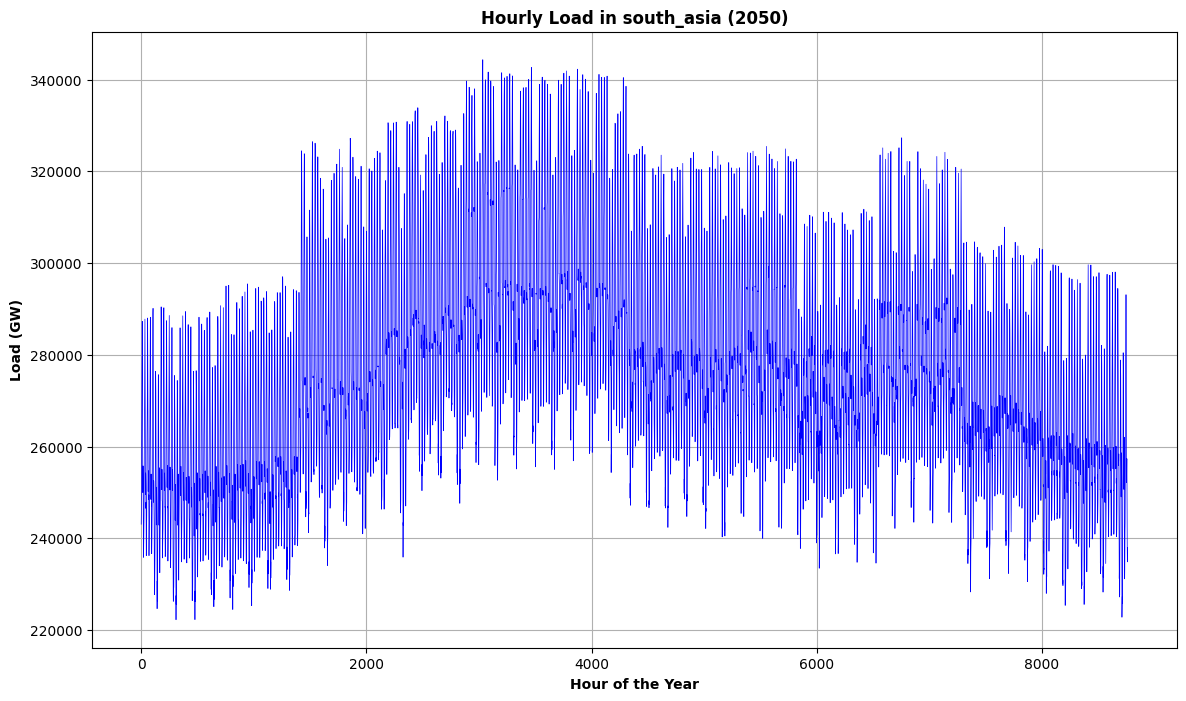

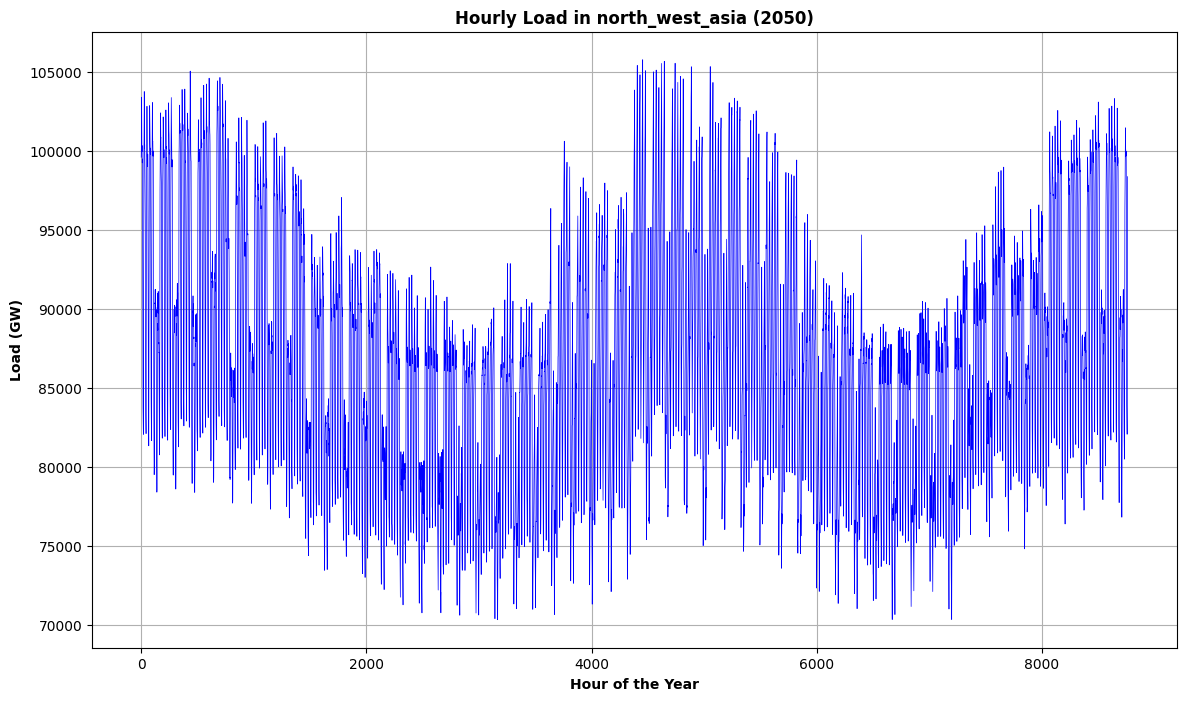

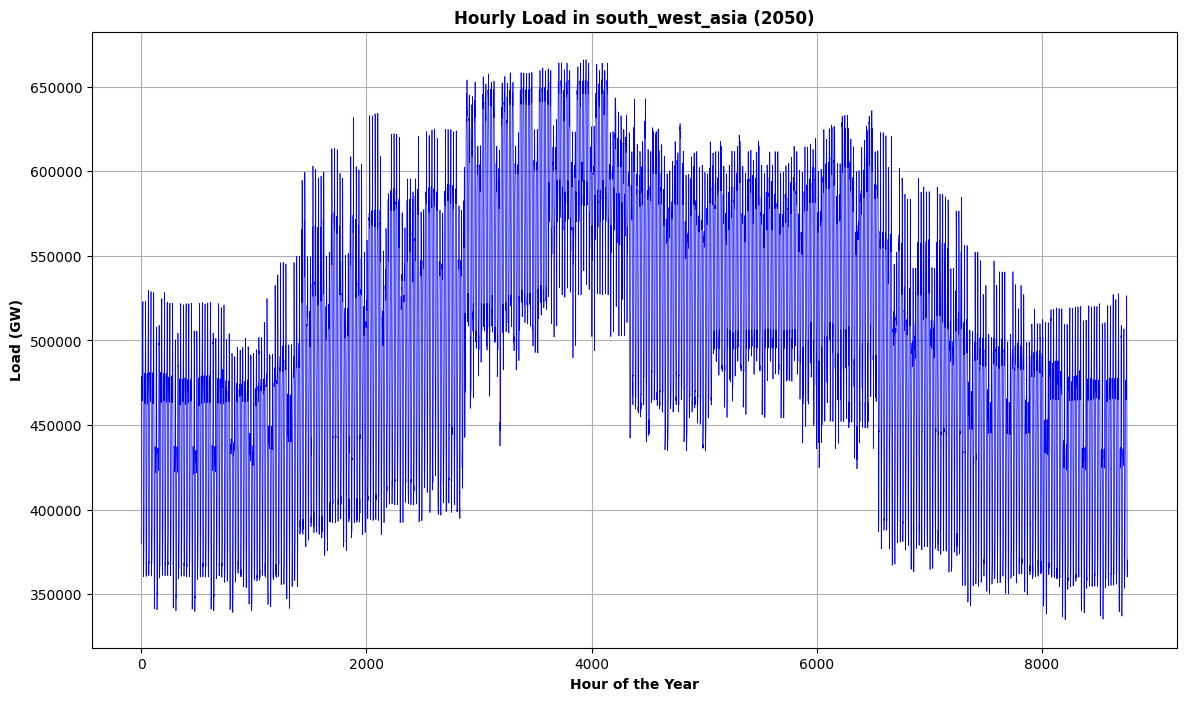

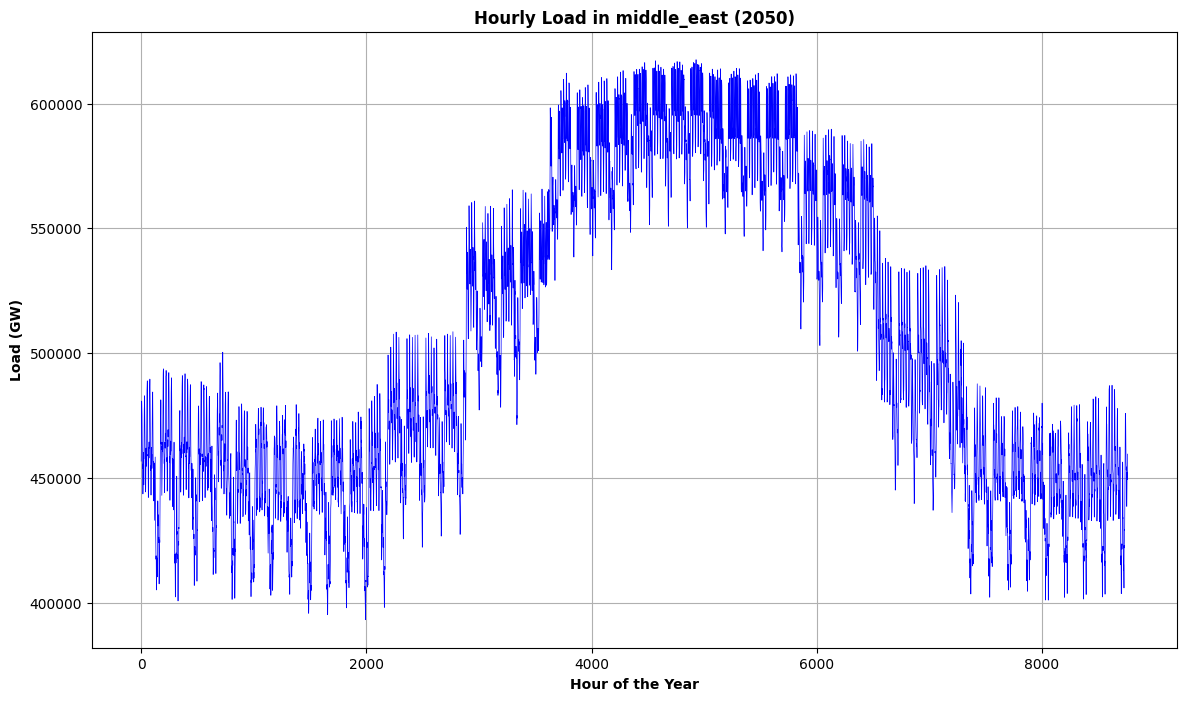

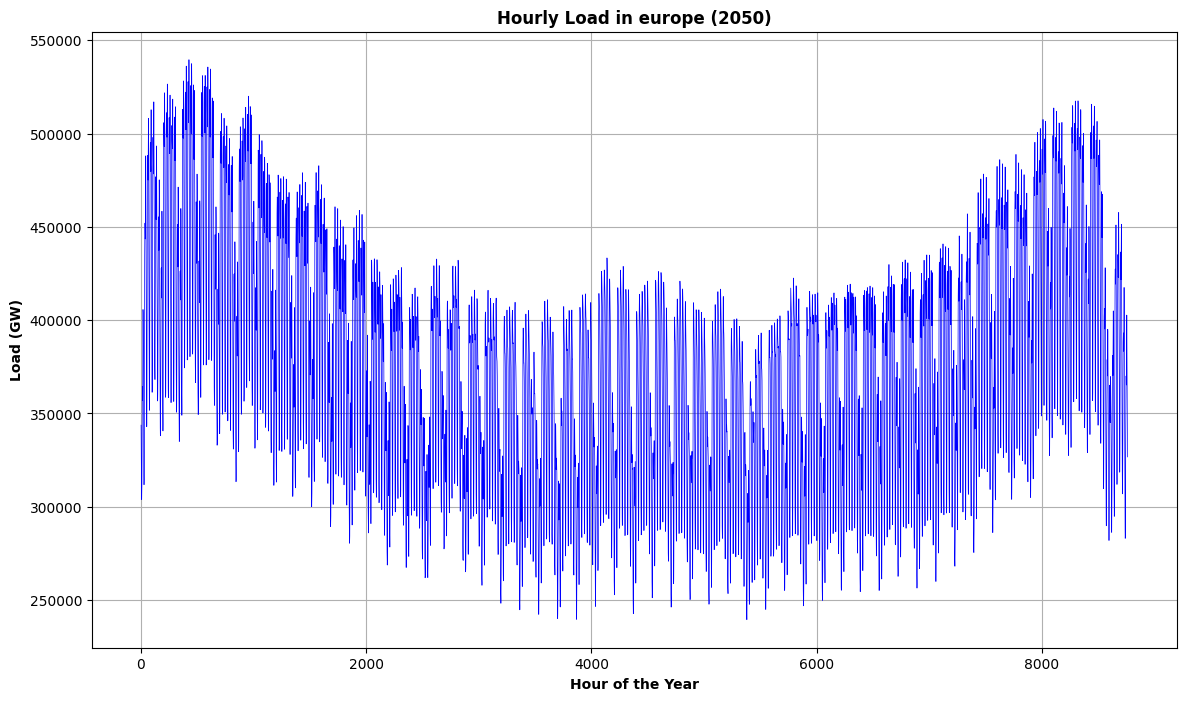

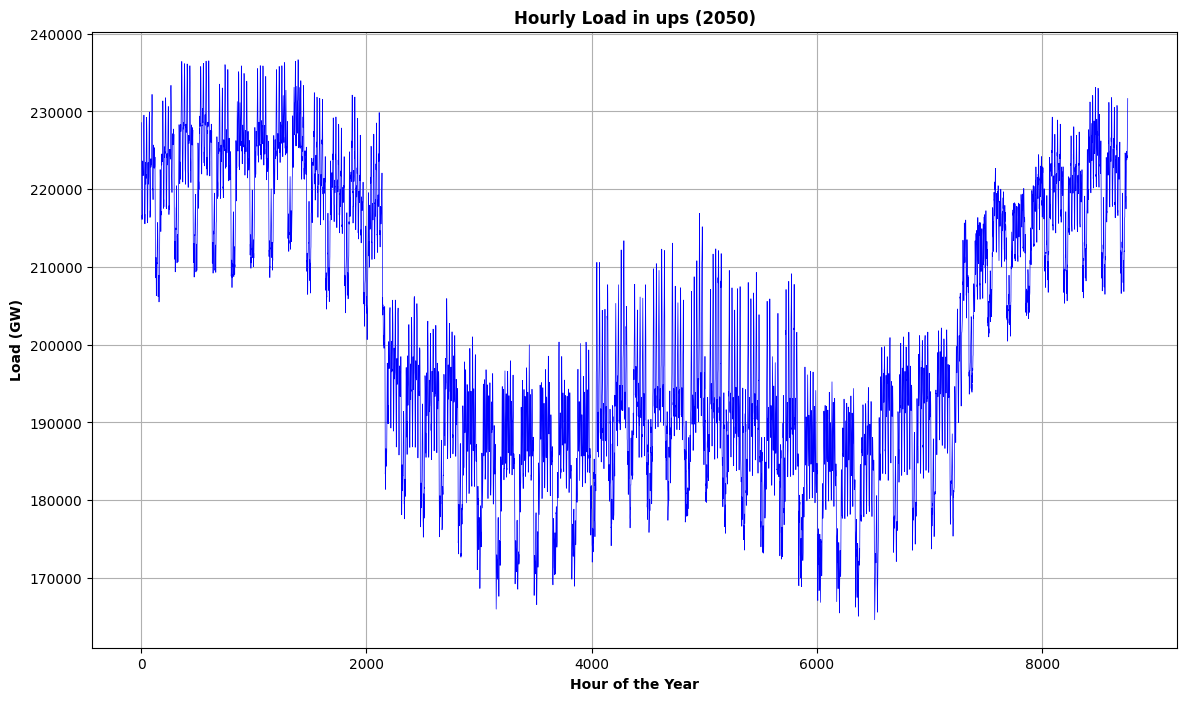

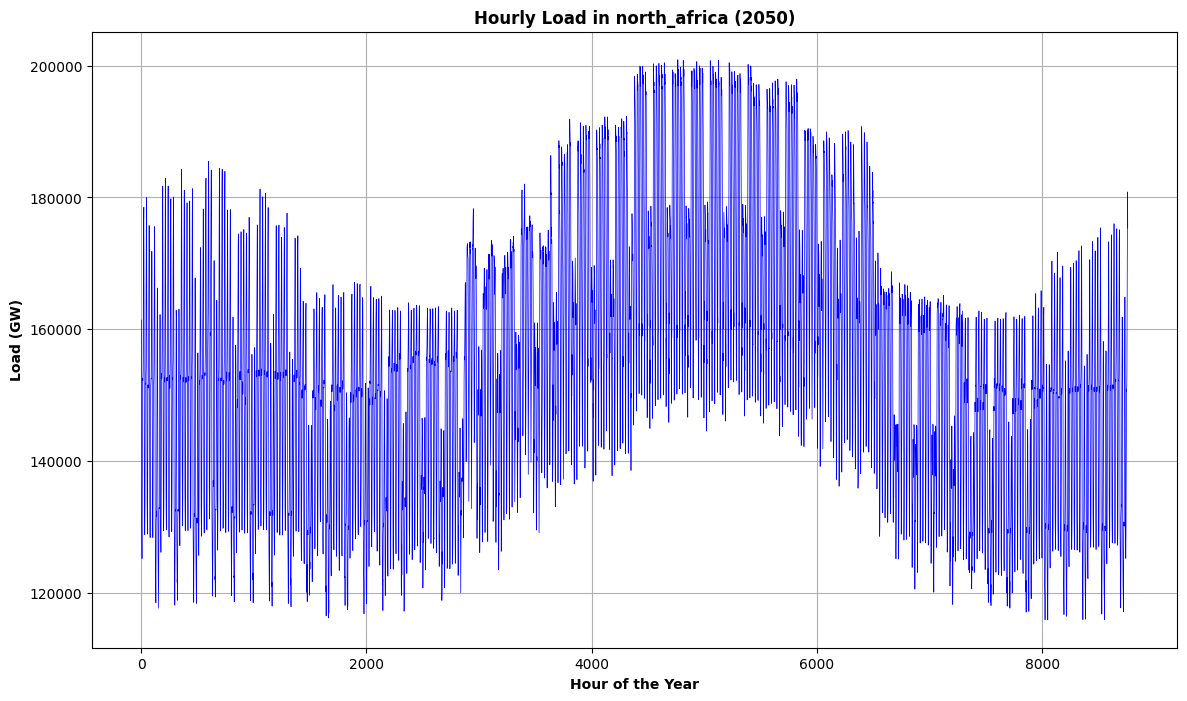

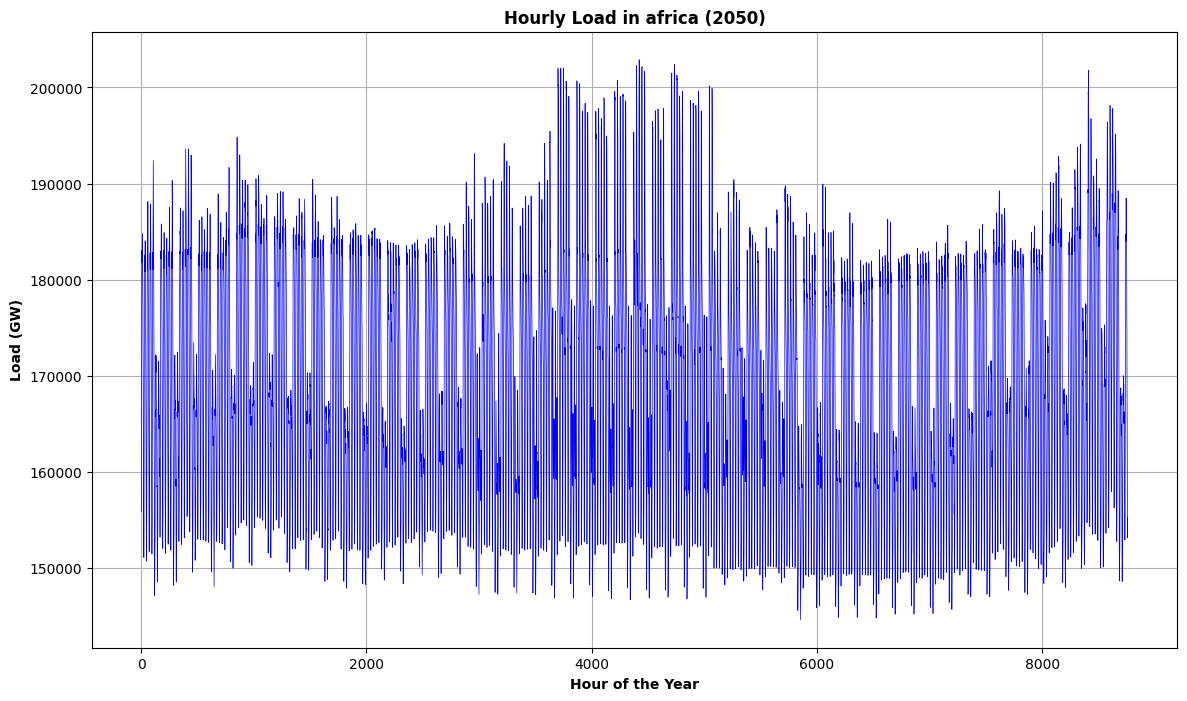

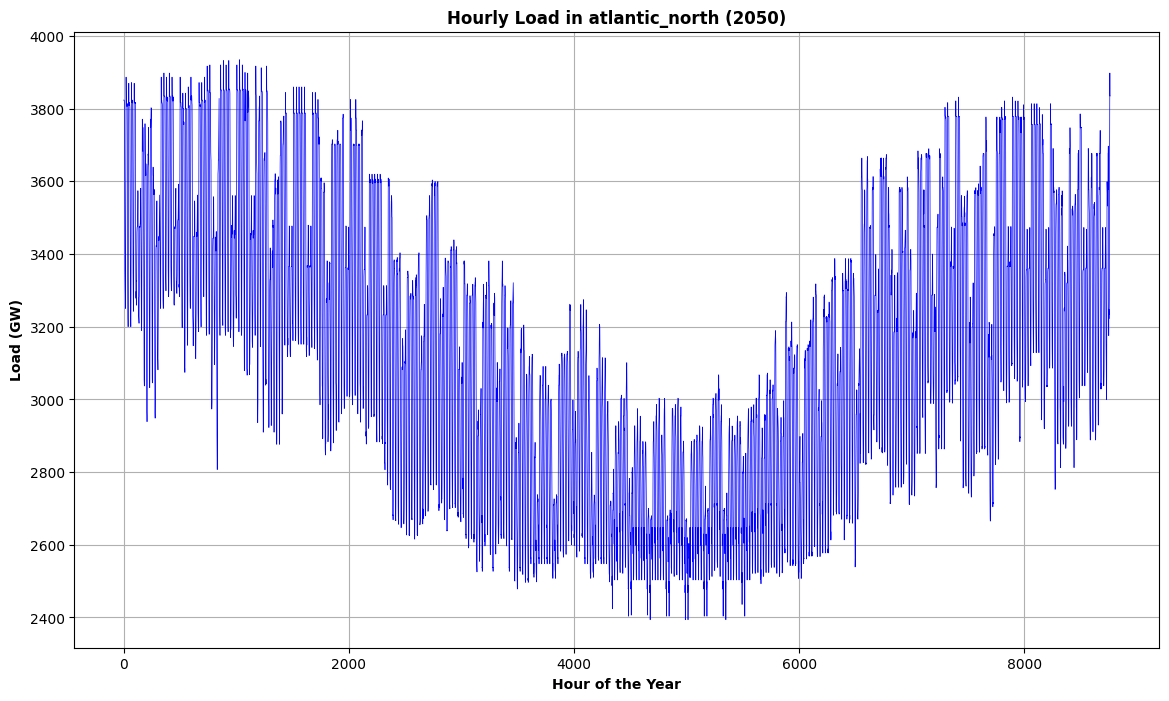

In [32]:
# Function to plot hourly load values for a region
def plot_hourly_load(region_key, region_name):
    # Extract the hourly load data for the region
    hourly_load = n.loads_t.p.filter(like=f"load_{region_key}")

    # If there are multiple columns for different loads in the region, sum them up
    hourly_load_series = hourly_load.sum(axis=1)

    # Create a DataFrame to hold the hourly load with a datetime index
    hourly_load_df = pd.DataFrame(hourly_load_series, columns=['load'])

    # Create a new column for the hour of the year
    hourly_load_df['hour_of_year'] = range(1, len(hourly_load_df) + 1)

    # Plot the hourly load values
    plt.figure(figsize=(14, 8))
    plt.plot(hourly_load_df['hour_of_year'], hourly_load_df['load'], color='blue', linewidth=0.5)
    plt.xlabel('Hour of the Year', fontweight='bold')
    plt.ylabel('Load (GW)', fontweight='bold')
    plt.title(f'Hourly Load in {region_key} (2050)', fontweight='bold')
    plt.grid(True)
    plt.show()

# Loop through each region and plot the hourly load
for region_key, region_value in regions_dic.items():
    plot_hourly_load(region_key, region_value['bus'])

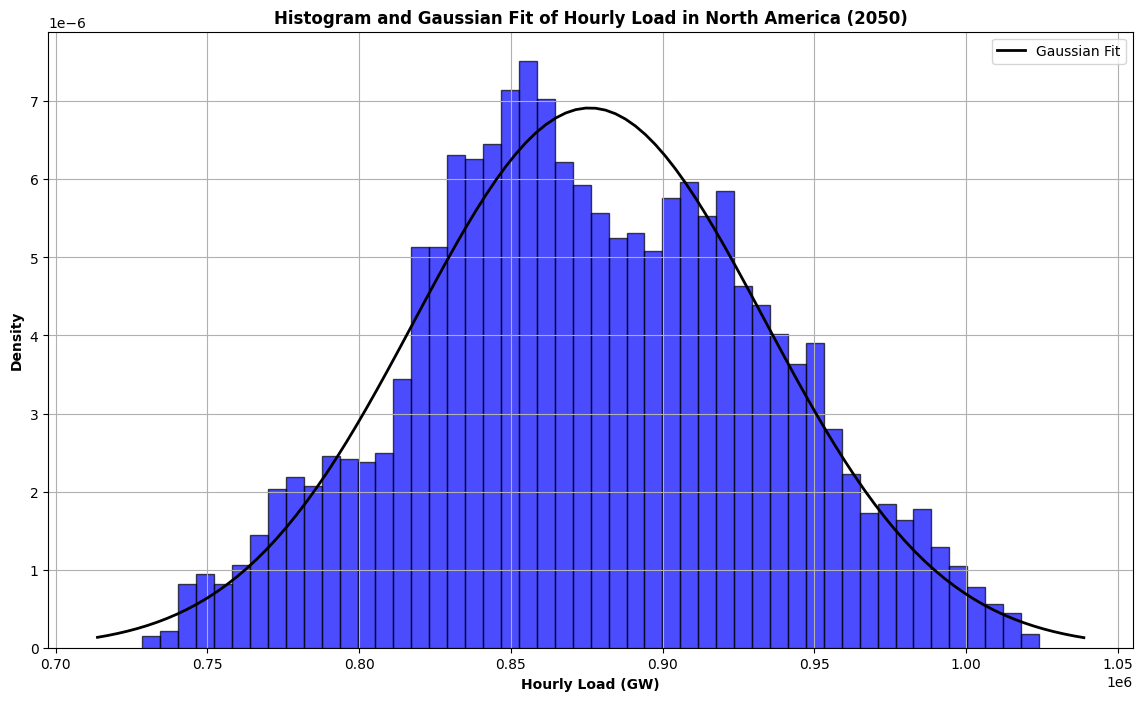

In [33]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import norm

# Assuming `n` is your network data object and `north_america` is the region key

# Extract the hourly load data for North America
hourly_load = n.loads_t.p.filter(like="load_north_america")

# Convert the DataFrame to a Series by summing across all load columns (if there are multiple columns for different loads in North America)
hourly_load_series = hourly_load.sum(axis=1)

# Calculate the mean and standard deviation of the load data
mu, std = norm.fit(hourly_load_series)

# Plot the histogram of the hourly load
plt.figure(figsize=(14, 8))
count, bins, ignored = plt.hist(hourly_load_series, bins=50, density=True, color='blue', edgecolor='black', alpha=0.7)

# Plot the Gaussian distribution curve
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2, label='Gaussian Fit')

# Add labels and title
plt.xlabel('Hourly Load (GW)', fontweight='bold')
plt.ylabel('Density', fontweight='bold')
plt.title('Histogram and Gaussian Fit of Hourly Load in North America (2050)', fontweight='bold')
plt.legend()
plt.grid(True)

# Show plot
plt.show()


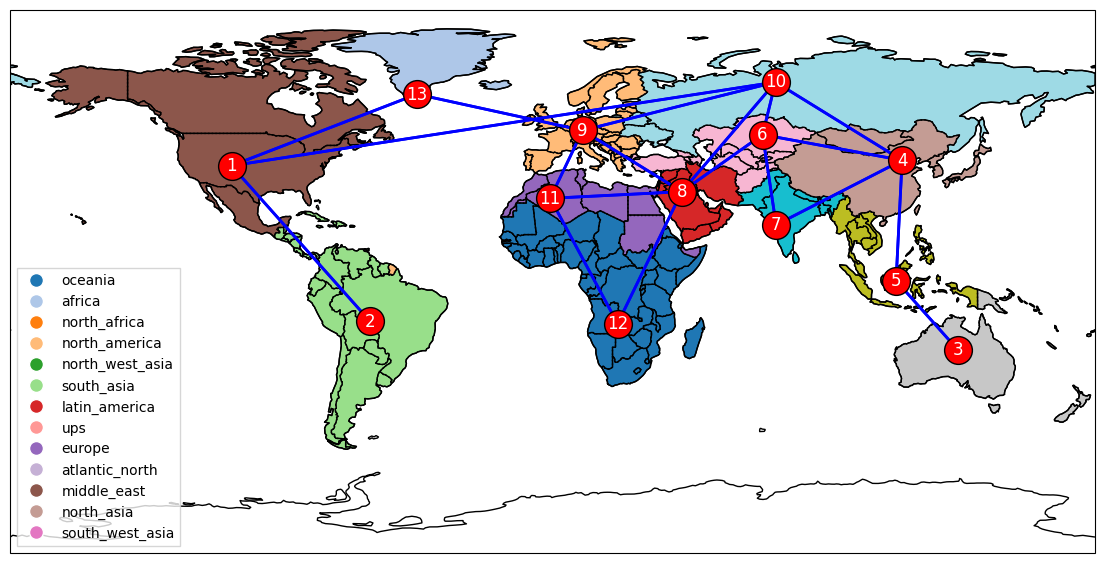

In [34]:
import warnings
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from pyproj import Geod
import geopandas as gpd
from cartopy.geodesic import Geodesic

warnings.filterwarnings("ignore", category=UserWarning)
plt.rc("figure", figsize=(14, 10))

# Load the naturalearth_lowres dataset
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Create a column in the world dataframe that matches the bus to country dictionary
world['bus'] = None
for key, value in regions_dic.items():
    for country in value["countries"]:
        world.loc[world['name'] == country, 'bus'] = key

# Plotting the network with results
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([-180, 180, -90, 90])  # Adjust extent as needed

# Add base map features
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Plot country regions without legend
world.plot(ax=ax, column='bus', cmap='tab20', legend=False, edgecolor='black', transform=ccrs.PlateCarree())

# Create a custom legend
unique_regions = world['bus'].dropna().unique()
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=plt.cm.tab20(i), markersize=10, label=region) for i, region in enumerate(unique_regions)]
ax.legend(handles=handles, loc='lower left', bbox_to_anchor=(0.0, 0.0), fancybox=False, shadow=False, ncol=1)

for i, bus in enumerate(n.buses.index, start=1):
    x, y = n.buses.loc[bus, ['x', 'y']]
    ax.scatter(x, y, s=400, color='red', edgecolor='k', zorder=5)
    ax.text(x, y, str(i), color='white', fontsize=12, ha='center', va='center', zorder=6)

# Plot links
for link in n.links.index:
    bus0 = n.links.loc[link, 'bus0']
    bus1 = n.links.loc[link, 'bus1']
    x0, y0 = n.buses.loc[bus0, ['x', 'y']]
    x1, y1 = n.buses.loc[bus1, ['x', 'y']]
    ax.plot([x0, x1], [y0, y1], color='blue', linewidth=2, zorder=4)


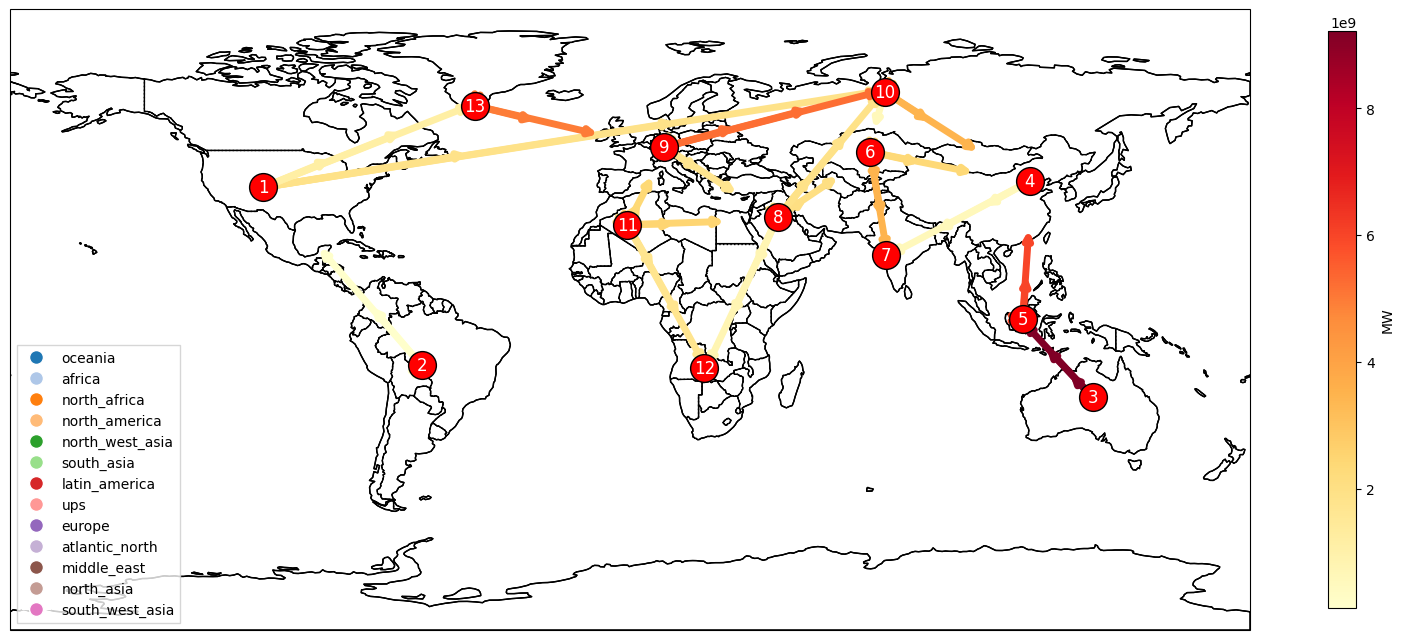

In [35]:
import warnings
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from pyproj import Geod
import geopandas as gpd
import numpy as np

warnings.filterwarnings("ignore", category=UserWarning)
plt.rc("figure", figsize=(20, 15))

# Load the naturalearth_lowres dataset
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Create a column in the world dataframe that matches the bus to country dictionary
world['bus'] = None
for key, value in regions_dic.items():
    for country in value["countries"]:
        world.loc[world['name'] == country, 'bus'] = key

# Plotting the network with results
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([-180, 180, -90, 90])  # Adjust extent as needed

# Add base map features
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Plot country regions without legend, setting facecolor to white
world.boundary.plot(ax=ax, edgecolor='black', linewidth=0.5, transform=ccrs.PlateCarree())
world.plot(ax=ax, color='white', edgecolor='black', transform=ccrs.PlateCarree())

# Create a custom legend
unique_regions = world['bus'].dropna().unique()
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=plt.cm.tab20(i), markersize=10, label=region) for i, region in enumerate(unique_regions)]
ax.legend(handles=handles, loc='lower left', bbox_to_anchor=(0.0, 0.0), fancybox=False, shadow=False, ncol=1)

for i, bus in enumerate(n.buses.index, start=1):
    x, y = n.buses.loc[bus, ['x', 'y']]
    ax.scatter(x, y, s=400, color='red', edgecolor='k', zorder=5)
    ax.text(x, y, str(i), color='white', fontsize=12, ha='center', va='center', zorder=6)

# Define the Geod object for WGS84
geod = Geod(ellps="WGS84")

# Placeholder data for the direction and color of arrows
# This should be replaced with actual data
arrow_directions = {link: True for link in n.links.index}  # Example boolean data for direction
arrow_colors = {value['name']: netflows_links[i] for i, (key, value) in enumerate(links_dic.items())}  # Example values for color

# Normalize the arrow color values for the colormap
norm = mcolors.Normalize(vmin=min(arrow_colors.values()), vmax=max(arrow_colors.values()))
cmap = cm.YlOrRd

# Function to calculate offset coordinates
def offset_coordinates(x0, y0, x1, y1, offset):
    dx, dy = x1 - x0, y1 - y0
    length = np.sqrt(dx**2 + dy**2)
    offset_x = -offset * dy / length
    offset_y = offset * dx / length
    return offset_x, offset_y

# Plot links with directional arrows and heatmap colors at 1/3, 2/3, and 3/3 points
for number, (key, value) in enumerate(links_dic.items()):
    bus0 = n.links.loc[f'{value['name']}_0', 'bus0']
    bus1 = n.links.loc[f'{value['name']}_0', 'bus1']
    x0, y0 = n.buses.loc[bus0, ['x', 'y']]
    x1, y1 = n.buses.loc[bus1, ['x', 'y']]
    
    offset_x, offset_y = offset_coordinates(x0, y0, x1, y1, 0.5)  # Adjust offset as needed
    
    # Calculate points at 1/3, 2/3, and 3/3 of the way along the line
    points = [
        (x0 + (x1 - x0) / 3 + offset_x, y0 + (y1 - y0) / 3 + offset_y),
        (x0 + 2 * (x1 - x0) / 3 + offset_x, y0 + 2 * (y1 - y0) / 3 + offset_y),
        (x1 + offset_x, y1 + offset_y)
    ]

    for point in points:
        # Determine the direction of the arrow
        if flow_statements[number]:
            start, end = (x0, y0), point # outflow
        else:
            start, end = (x1, y1), point
        
        # Determine the color of the arrow
        color = cmap(norm(arrow_colors[value['name']]))
        
        # Plot the arrow
        ax.annotate('', xy=end, xytext=start,
                    arrowprops=dict(arrowstyle='->', color=color, linewidth=5))

# Create a color bar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', shrink=0.5)
cbar.set_label('MW')

plt.show()
